In [12]:
from importlib import reload
import numpy as np
import os
import random
import pickle
import multiprocessing
import functools
import seaborn
import logging
import typhon
import cmocean
from pylab import cm
from os.path import join
from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from scipy.signal import detrend
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import processing_tools as ptools
import analysis_tools as atools
from importlib import reload
from moisture_space import utils, plots
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# Config

In [248]:
models = ['ICON', 'NICAM', 'GEOS', 'IFS', 'MPAS', 'FV3', 'UM', 'SAM']
runs = {
    'ICON': ['2.5km'],
    'NICAM': ['3.5km'],
    'SAM': ['4.0km'],
    'UM': ['5.0km'],
    'FV3': ['3.25km'],
    'GEOS': ['3.0km'],
    'IFS': ['4.0km'],
    'MPAS': ['3.75km']    
}
exps = []
for m in models:
    for run in runs[m]:
        exps.append(m+'-'+run)
        
# NICAM excluded!
variability_exclude = ['NICAM-3.5km']
models_variability = [m for m in exps if not m in variability_exclude]
time_period = ['0810', '0908']
variables_3D = ['TEMP', 'PRES', 'QV', 'QI', 'QC', 'RH', 'ICQI', 'CFI', 'ICQC', 'CFL', 'W']
variables_2D = ['OLR', 'IWV', 'UTH', 'IWP', 'H_tropo', 'H_RH_peak']
datapath = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/{}/random_samples/'
filenames = '{}-{}_{}_sample_{}_{}-{}.nc'
num_profiles = int(1 * 1e7)
perc_values = np.arange(1, 100.5, 1.0)
num_percs = len(perc_values)
iwv_bin_bnds = np.arange(0, 101, 1)
bins = range(len(iwv_bin_bnds) - 1) 
exp = 0
height = {}
num_levels = {}
for m in models:
    for run in runs[m]:
        key = m+'-'+run
        filename = filenames.format(m, run, variables_3D[0], num_profiles, time_period[0], time_period[1])
        filename = join(datapath.format(m), filename)
        #xarr = xr.open_dataset(filename)
        with(Dataset(filename)) as ds:
            height[key] = ds.variables['height'][:].filled(np.nan)
        num_levels[key] = len(height[key])

# Read random samples from files

In [249]:
perc_mean = {}
perc_std = {}
perc_median = {}
perc_quart25 = {}
perc_quart75 = {}
perc_min = {}
perc_max = {}
percentiles = {}
bin_mean = {}
bin_std = {}
bin_median = {}
bin_quart25 = {}
bin_quart75 = {}
bin_min = {}
bin_max = {}
bin_count = {}
for m in models:
    for run in runs[m]:
        with open(join(datapath.format(m), f"{m}-{run}_{time_period[0]}-{time_period[1]}_perc_means_{num_profiles}_0exp.pkl"), "rb" ) as infile:
            perc = pickle.load(infile)
        key = m+'-'+run
        perc_mean[key] = perc['mean']
        perc_std[key] = perc['std']
        perc_median[key] = perc['median']
        perc_quart25[key] = perc['quart25']
        perc_quart75[key] = perc['quart75']
        perc_min[key] = perc['min']
        perc_max[key] = perc['max']
        percentiles[key] = perc['percentiles']

        with open(join(datapath.format(m), f"{m}-{run}_{time_period[0]}-{time_period[1]}_bin_means_{num_profiles}_0exp.pkl"), "rb" ) as infile:
            binned = pickle.load(infile)

        bin_mean[key] = binned['mean']
        bin_std[key] = binned['std']
        bin_median[key] = binned['median']
        bin_quart25[key] = binned['quart25']
        bin_quart75[key] = binned['quart75']
        bin_min[key] = binned['min']
        bin_max[key] = binned['max']
        bin_count[key] = binned['count']

        if m == 'ICON':
            perc_mean[key]['OLR'] *= -1
            perc_median[key]['OLR'] *= -1
            bin_mean[key]['OLR'] *= -1
            bin_median[key]['OLR'] *= -1


# Selection of bins with a certain amount of profiles for plotting

In [250]:
bin_mean_plot = {}
bin_std_plot = {}
count_thres = 300
for m in models:
    for run in runs[m]:
        key = m+'-'+run
        bin_mean_plot[key] = {}
        bin_mean_plot[key]['OLR'] = bin_mean[key]['OLR'].copy()
        bin_mean_plot[key]['OLR'][bin_count[key] < count_thres] = np.nan
        bin_std_plot[key] = {}
        bin_std_plot[key]['OLR'] = bin_std[key]['OLR'].copy()
        bin_std_plot[key]['OLR'][bin_count[key] < count_thres] = np.nan
        for var in variables_3D:
            bin_mean_plot[key][var] = bin_mean[key][var].copy()
            bin_mean_plot[key][var][:, bin_count[key] < count_thres] = np.nan
            bin_std_plot[key][var] = bin_std[key][var].copy()
            bin_std_plot[key][var][:, bin_count[key] < count_thres] = np.nan

# Interpolate profiles to common height

In [251]:
perc_mean_interp = {}
bin_mean_plot_interp = {}
h = np.arange(100, 20100, 400)
for m in models:
    for run in runs[m]:
        key = m+'-'+run
        perc_mean_interp[key] = {}
        bin_mean_plot_interp[key] = {}
        for var in variables_3D:
            perc_mean_interp[key][var] = utils.interpolate_vertically(perc_mean[key][var].T, height[key], h)
            bin_mean_plot_interp[key][var] = utils.interpolate_vertically(bin_mean_plot[key][var], height[key], h)

# Calculate inter-model variability

In [252]:
model_array = {}
model_array_bins = {}

for var in variables_3D:
    model_array[var] = np.zeros((len(models_variability), len(h), len(perc_values)))
    model_array_bins[var] = np.zeros((len(models_variability), len(h), len(bins)))
    for n, m in enumerate(models_variability):
        model_array[var][n] = perc_mean_interp[m][var]
        model_array_bins[var][n] = bin_mean_plot_interp[m][var]

# Calculate EOFs and expansion coefficients

In [192]:
# reshape model_arrays
array_reshaped = model_array['RH'].reshape((len(models_variability), len(h) * len(perc_values)))
# detrend
array_detrended = detrend(array_reshaped, axis=0, type='constant').T
# covariance matrix
cov_matrix = np.cov(array_detrended)
# Eigenvalues and -vectors
RH_eigvals, RH_EOFs = np.linalg.eig(cov_matrix)
# reshape
RH_EOF_frac = RH_eigvals / np.sum(RH_eigvals)   
# calculate expansion coefficients corresponding to first N EOFs
N = 3
expansion_coeff = np.ones((N, len(models_variability))) * np.nan
for i in range(N):
    expansion_coeff[i] = np.matmul(array_detrended.T, RH_EOFs[:, i])

/work/um0878/sw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


# Calculate streamfunction

In [253]:
reload(utils)
streamfunction = {}
for m in exps:
    streamfunction[m] = np.zeros((len(h), num_percs))
    perc_mean_interp[m]['DENS'] = utils.calc_density_moist_air(
        perc_mean_interp[m]['PRES'],
        perc_mean_interp[m]['TEMP'],
        perc_mean_interp[m]['QV']
    )
    for i in range(1, num_percs):
        streamfunction[m][:, i] = streamfunction[m][:, i-1] + perc_mean_interp[m]['DENS'][:, i] * perc_mean_interp[m]['W'][:, i]

# Find boundaries of UTH layer

In [ ]:
reload(atools)
lower_bnd = {}
upper_bnd = {}
uth = {}
    
for m in models:
    for run in runs[m]:
        key = m+'-'+run
        bin_mean_plot[key]['UTH_bnds'] = utils.calc_UTH_boundaries(
            bin_mean_plot[key]['RH'], 
            bin_mean_plot[key]['QV'], 
            bin_mean_plot[key]['TEMP'], 
            bin_mean_plot[key]['PRES'], 
            height[key]
        )

        perc_mean[key]['UTH_bnds'] = utils.calc_UTH_boundaries(
            perc_mean[key]['RH'], 
            perc_mean[key]['QV'], 
            perc_mean[key]['TEMP'], 
            perc_mean[key]['PRES'], 
            height[key]
        )   

# Plots

## PDF of IWV

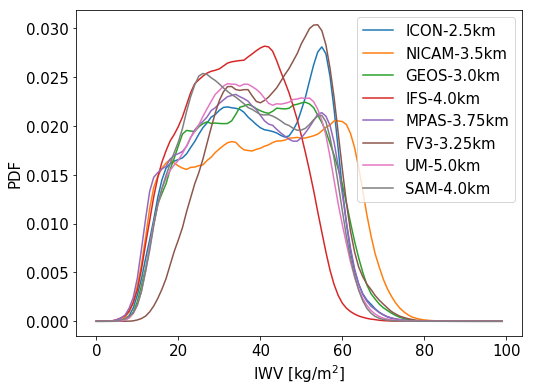

In [13]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(8, 6))
for m in exps:
    ax.plot(bins, bin_count[m]/np.sum(bin_count[m]), label=m)
ax.set_xlabel('IWV [kg/m$^2$]')
ax.set_ylabel('PDF')
ax.legend()

## Mean profiles

DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to STIXGeneral ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
DEBUG:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=15.0 to STIXGeneral ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=15.0 to STIXGeneral ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with s

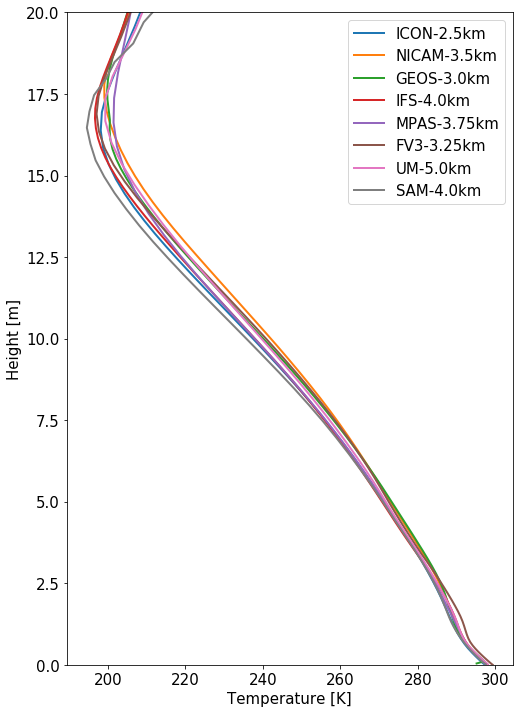

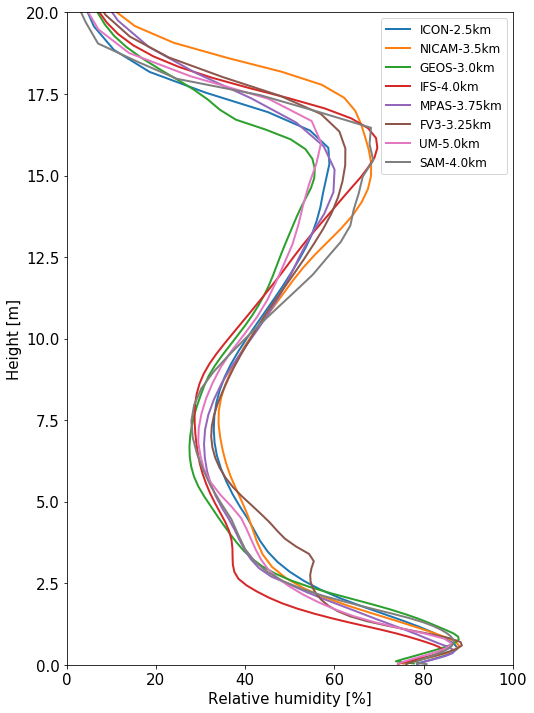

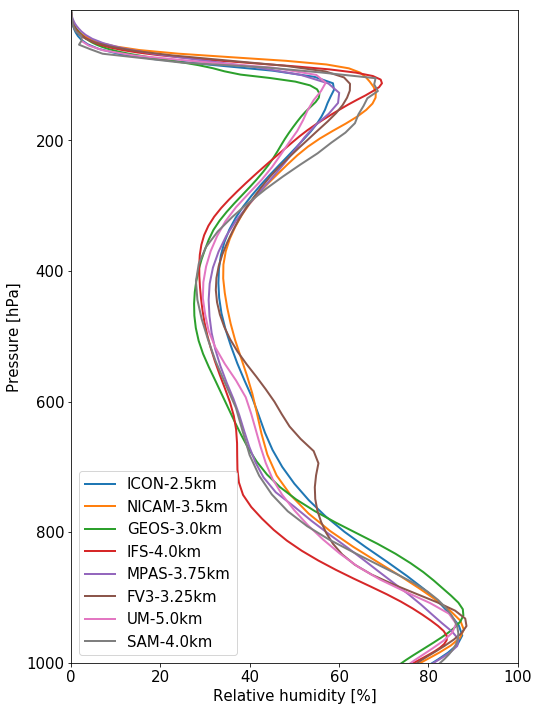

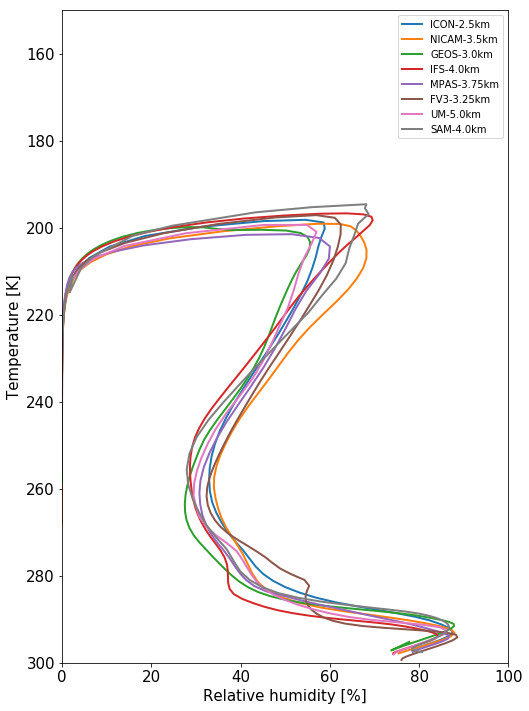

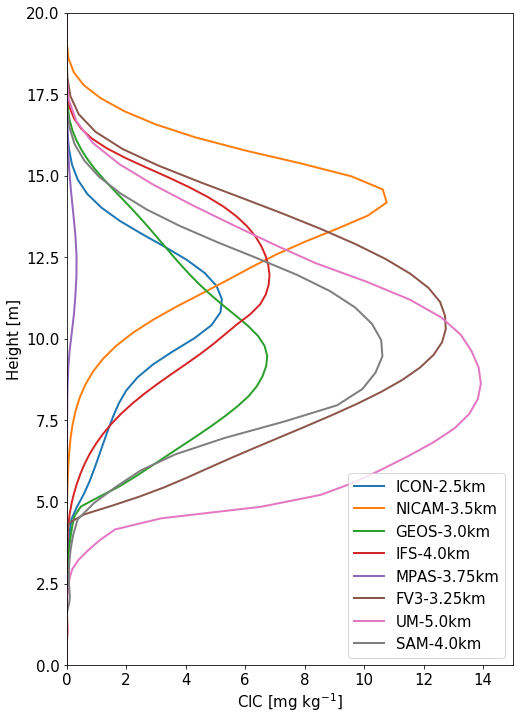

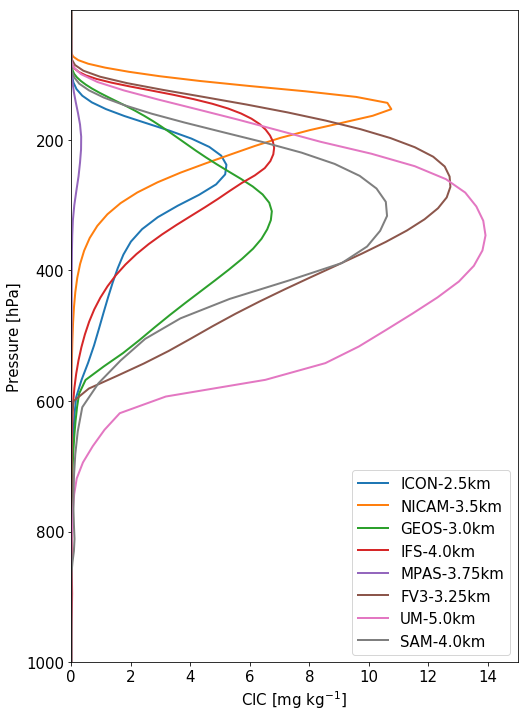

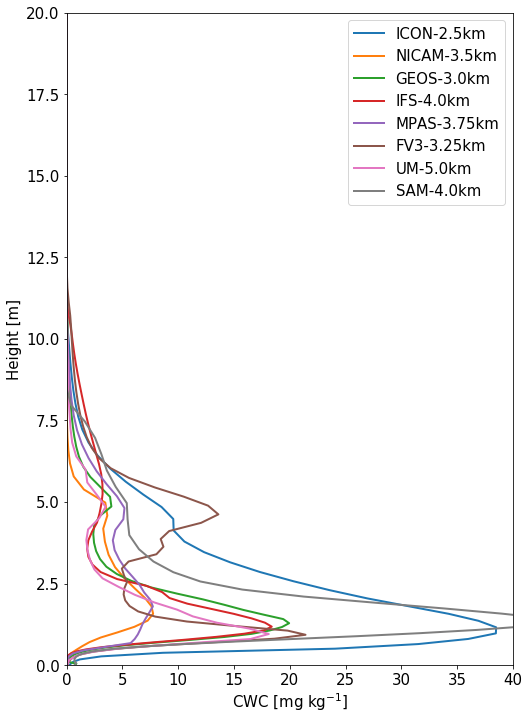

In [11]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(8, 12))
for m in exps:
    mean_temp = np.nanmean(perc_mean[m]['TEMP'], axis=0)
    plt.plot(mean_temp, height[m] * 1e-3, lw=2, label=m)
ax.set_ylim(0, 20)
#ax.set_xlim(0, 100)
ax.set_ylabel('Height [m]')
ax.set_xlabel('Temperature [K]')
ax.legend()

fig, ax = plt.subplots(figsize=(8, 12))
for i, m in enumerate(exps):
    mean_rh = np.mean(perc_mean[m]['RH'] * 100, axis=0)
    ax.plot(mean_rh, height[m] * 1e-3, lw=2, label=m, color=f'C{i}')
ax.set_ylim(0, 20)
ax.set_xlim(0, 100)
ax.set_ylabel('Height [m]')
ax.set_xlabel('Relative humidity [%]')
ax.legend(fontsize=12)


fig, ax = plt.subplots(figsize=(8, 12))
for m in exps:
    mean_rh = np.nanmean(perc_mean[m]['RH'] * 100, axis=0)
    plt.plot(mean_rh, np.nanmean(perc_mean[m]['PRES'], axis=0) * 1e-2, lw=2, label=m)
ax.set_ylim(1000, 1)
ax.set_xlim(0, 100)
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Relative humidity [%]')
ax.legend()

fig, ax = plt.subplots(figsize=(8, 12))
for m in exps:
    mean_rh = np.nanmean(perc_mean[m]['RH'] * 100, axis=0)
    plt.plot(mean_rh, np.nanmean(perc_mean[m]['TEMP'], axis=0), lw=2, label=m)
ax.set_ylim(300, 150)
ax.set_xlim(0, 100)
ax.set_ylabel('Temperature [K]')
ax.set_xlabel('Relative humidity [%]')
ax.legend(fontsize=10)

fig, ax = plt.subplots(figsize=(8,12))
for m in exps:
    mean_qi = np.nanmean(perc_mean[m]['QI'] * 1e6, axis=0)
    plt.plot(mean_qi, height[m] * 1e-3, lw=2, label=m)
ax.set_ylim(0, 20)
ax.set_xlim(0, 15)
ax.set_ylabel('Height [m]')
ax.set_xlabel('CIC [mg kg$^{-1}$]')
ax.legend()

fig, ax = plt.subplots(figsize=(8,12))
for m in exps:
    mean_qi = np.nanmean(perc_mean[m]['QI'] * 1e6, axis=0)
    plt.plot(mean_qi, np.nanmean(perc_mean[m]['PRES'], axis=0) * 1e-2, lw=2, label=m)
ax.set_ylim(1000, 1)
ax.set_xlim(0, 15)
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('CIC [mg kg$^{-1}$]')
ax.legend()

fig, ax = plt.subplots(figsize=(8, 12))
for m in exps:
    mean_qc = np.nanmean(perc_mean[m]['QC'] * 1e6, axis=0)
    plt.plot(mean_qc, height[m] * 1e-3, lw=2, label=m)
ax.set_ylim(0, 20)
ax.set_xlim(0, 40)
ax.set_ylabel('Height [m]')
ax.set_xlabel('CWC [mg kg$^{-1}$]')
ax.legend()



## Tropopause height

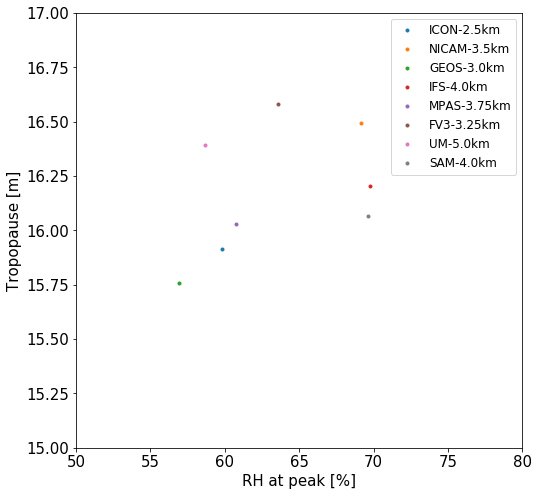

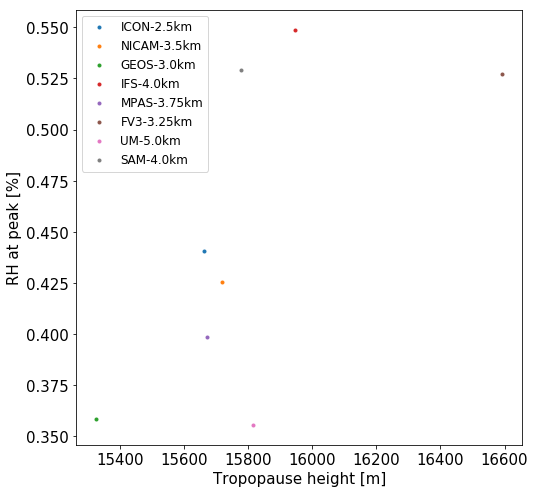

In [15]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(8, 8))
for i, m in enumerate(exps):
    mean_h_tropo = np.nanmean(perc_mean[m]['H_tropo'] * 1e-3)
    rh_peak_height, rh_at_peak = utils.rh_peak_height(perc_mean[m]['RH'].T, height[m])
    mean_rh_peak = np.mean(rh_peak_height) * 1e-3
    mean_rh_at_peak = np.mean(rh_at_peak) * 1e2
    ax.plot(mean_rh_at_peak, mean_h_tropo, '.', label=m, color=f'C{i}')
    #ax.plot([0, 100], [mean_rh_peak, mean_rh_peak], color=f'C{i}')
ax.set_ylim(15, 17)
ax.set_xlim(50, 80)
ax.set_xlabel('RH at peak [%]')
ax.set_ylabel('Tropopause [m]')
ax.legend(fontsize=12)

fig, ax = plt.subplots(figsize=(8, 8))
for i, m in enumerate(exps):
    h_tropo = perc_mean[m]['H_tropo'] 
    mean_h_tropo = np.nanmean(h_tropo) * 1e-3
    rh_peak_height, rh_at_peak = utils.rh_peak_height(perc_mean[m]['RH'].T, height[m])
    mean_rh_peak = np.mean(rh_peak_height) * 1e-3
    mean_rh_at_peak = np.mean(rh_at_peak) * 1e2
    ax.plot(np.mean(h_tropo[:30]), np.mean(rh_at_peak[:30]), '.', label=m, color=f'C{i}')
    #ax.plot([0, 100], [mean_rh_peak, mean_rh_peak], color=f'C{i}')
#ax.set_xlim(13, 17)
#ax.set_ylim(50, 80)
ax.set_ylabel('RH at peak [%]')
ax.set_xlabel('Tropopause height [m]')
ax.legend(fontsize=12)

## 2D Variables in moisture space

DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to DejaVu Sans ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to STIXGeneral ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
DEBUG:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=20.0 to STIXGeneral ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=20.0 to STIXGeneral ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with s

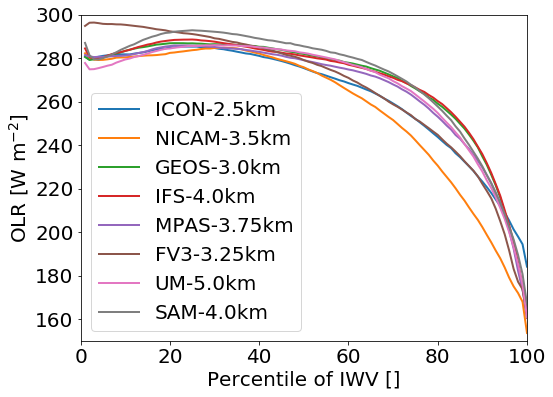

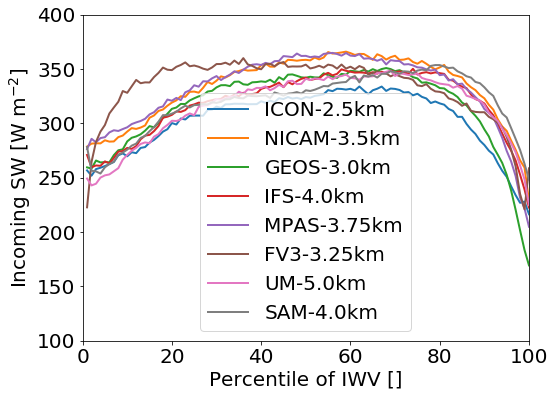

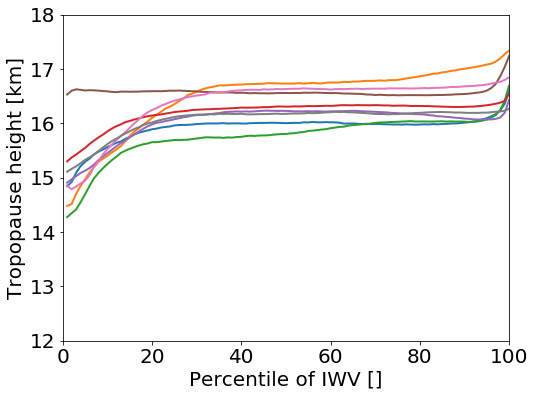

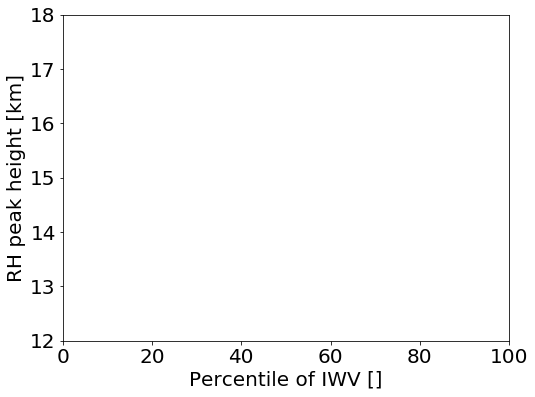

In [16]:
reload(utils)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(8, 6))
x_lims = [0, 100]
y_lims = [150, 300]
for m in exps:
    plots.moisture_space_line(ax, perc_values, perc_mean[m]['OLR'],\
                              x_lims, y_lims, 'Percentile of IWV []', 'OLR [W m$^{-2}$]', lw=2, label=m)
    tick_labels = np.arange(10, 81, 10)
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
y_lims = [100, 400]
for m in exps:
    stoa = perc_mean[m]['STOA']
    if np.mean(stoa) < 0:
        stoa = stoa * -1
    plots.moisture_space_line(ax, perc_values, stoa,\
                              x_lims, y_lims, 'Percentile of IWV []', 'Incoming SW [W m$^{-2}$]', lw=2, label=m)
    tick_labels = np.arange(10, 81, 10)
ax.legend()

x_lims = [0, 100]
y_lims = [12, 18]
fig, ax = plt.subplots(figsize=(8, 6))
for m in exps:
    plots.moisture_space_line(ax, perc_values, perc_mean[m]['H_tropo'] * 1e-3,\
                          x_lims, y_lims, 'Percentile of IWV []', 'Tropopause height [km]', lw=2, label=m)

#     ax.fill_between(perc_values, (perc_mean[m]['H_tropo'] -  perc_std[m]['H_tropo']) * 1e-3, (perc_mean[m]['H_tropo'] +  perc_std[m]['H_tropo']) * 1e-3, alpha=0.3)
    
x_lims = [0, 100]
y_lims = [12, 18]
fig, ax = plt.subplots(figsize=(8, 6))
for m in exps:
    plots.moisture_space_line(ax, perc_values, perc_mean[m]['H_RH_peak'] * 1e-3,\
                          x_lims, y_lims, 'Percentile of IWV []', 'RH peak height [km]', lw=2, label=m)

#ax.legend()
#ax.legend()

### RH, QI, OLR and W in moisture space (Percentiles)

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec000.ss001.ax002, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec000.ss003.ax004, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec000.ss005.ax006, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec000.ss003.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.010241
DEBUG:right 0.024143
DEBUG:bottom 0.090278
DEBUG:LayoutBox:    gridspec000.ss005.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec000.ss056.ax057, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

DEBUG:LayoutBox:   gridspec014.ss086.ax087, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:LayoutBox:   gridspec014.ss088.ax089, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:LayoutBox:   gridspec014.ss090.ax091, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:newpos (0.1753788893711405, 0.767390849469776, 0.35358864776234616, 0.2143795671968912)
DEBUG:newpo

DEBUG:newpos (0.8039039183063268, 0.7673908494697756, 0.07615067756558644, 0.21437956719689114)
DEBUG:newpos (0.8963832417052464, 0.7673908494697756, 0.07615067756558644, 0.21437956719689114)
DEBUG:newpos (0.007053211805555515, 0.45884378227288375, 0.07615067756558636, 0.21437956719689116)
DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec035.ss036.ax037, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec035.ss038.ax039, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec035.ss040.ax041, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec035.ss038.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.010241
DEBUG:right 0.024143
DEBUG:bottom 0.090278
DEBUG:LayoutBox:   

DEBUG:bottom 0.011285
DEBUG:LayoutBox:   gridspec049.ss146.ax147, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:LayoutBox:   gridspec049.ss148.ax149, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:LayoutBox:   gridspec049.ss150.ax151, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:newpos (0.17537888937114243, 0.767390849469776, 0.3535886477623456, 0.2143795

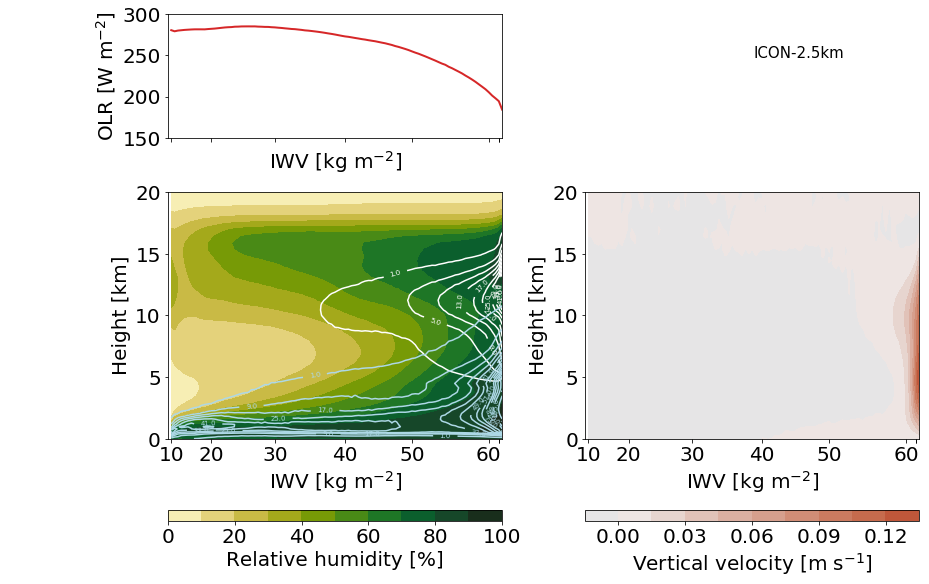

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec007.ss008.ax009, (left: 0.092) (bot: 0.698) (right: 0.536)  (top: 1.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec007.ss010.ax011, (left: 0.112) (bot: 0.142) (right: 0.536)  (top: 0.691) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec007.ss012.ax013, (left: 0.555) (bot: 0.142) (right: 0.980)  (top: 0.691) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec007.ss010.cbar, (left: 0.092) (bot: 0.012) (right: 0.553)  (top: 0.131) 
DEBUG:left 0.010241
DEBUG:right 0.024143
DEBUG:bottom 0.090278
DEBUG:LayoutBox:    gridspec007.ss012.cbar, (left: 0.555) (bot: 0.000) (right: 1.000)  (top: 0.131) 
DEBUG:left 0.007053
DEBUG:right 0.027466
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec007.ss068.ax069, (left: -0.000) (bot: 0.756) (right: 0.090)  (top: 0.993) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEB

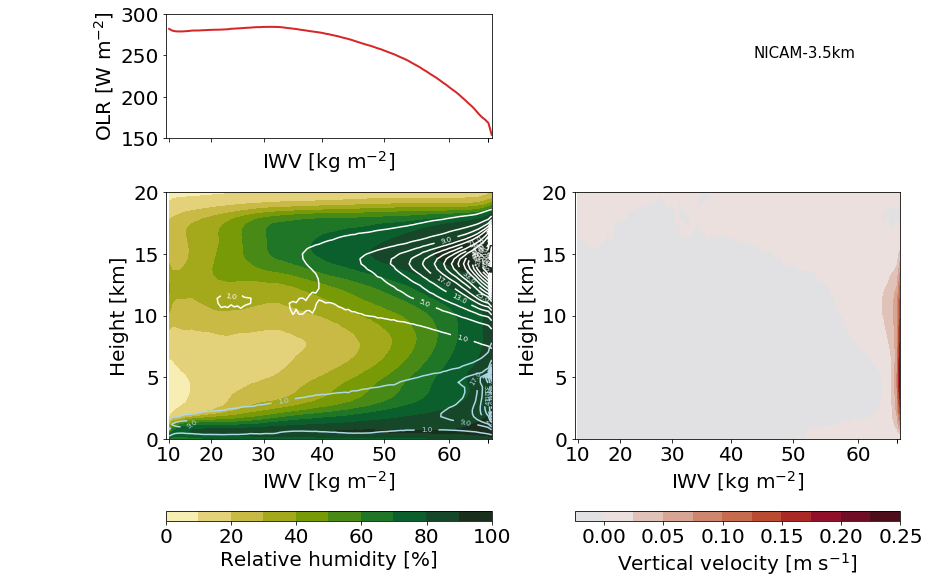

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec014.ss015.ax016, (left: 0.092) (bot: 0.698) (right: 0.536)  (top: 1.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec014.ss017.ax018, (left: 0.112) (bot: 0.142) (right: 0.536)  (top: 0.691) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec014.ss019.ax020, (left: 0.555) (bot: 0.142) (right: 0.980)  (top: 0.691) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec014.ss017.cbar, (left: 0.092) (bot: 0.012) (right: 0.553)  (top: 0.131) 
DEBUG:left 0.010241
DEBUG:right 0.024143
DEBUG:bottom 0.090278
DEBUG:LayoutBox:    gridspec014.ss019.cbar, (left: 0.582) (bot: 0.000) (right: 1.000)  (top: 0.131) 
DEBUG:left 0.036554
DEBUG:right 0.027466
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec014.ss080.ax081, (left: -0.000) (bot: 0.756) (right: 0.090)  (top: 0.993) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEB

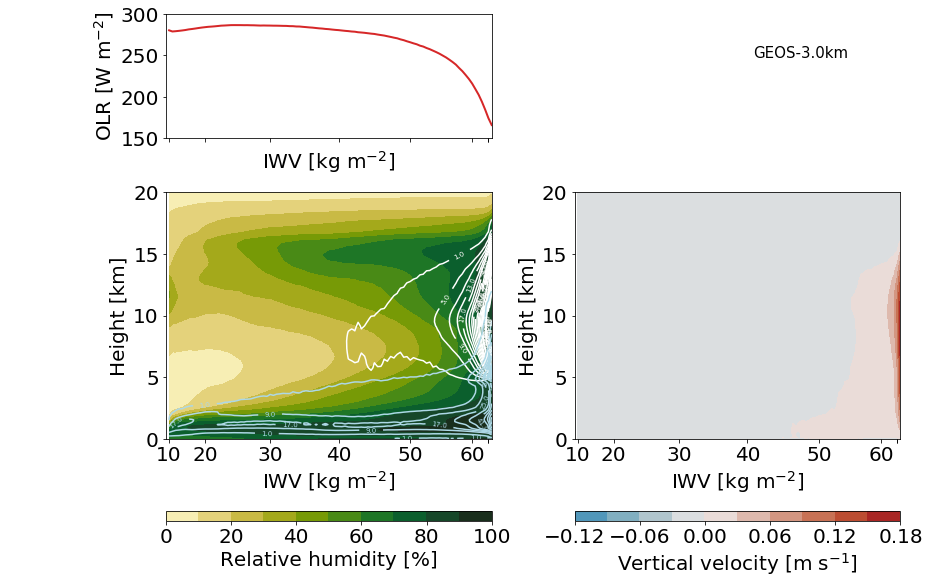

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec021.ss022.ax023, (left: 0.094) (bot: 0.698) (right: 0.544)  (top: 1.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec021.ss024.ax025, (left: 0.113) (bot: 0.143) (right: 0.550)  (top: 0.692) 
DEBUG:left 0.063612
DEBUG:right 0.013561
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec021.ss026.ax027, (left: 0.563) (bot: 0.143) (right: 1.000)  (top: 0.692) 
DEBUG:left 0.063612
DEBUG:right 0.013561
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec021.ss024.cbar, (left: 0.094) (bot: 0.012) (right: 0.561)  (top: 0.132) 
DEBUG:left 0.010241
DEBUG:right 0.024143
DEBUG:bottom 0.090278
DEBUG:LayoutBox:    gridspec021.ss026.cbar, (left: 0.590) (bot: 0.000) (right: 0.993)  (top: 0.132) 
DEBUG:left 0.036621
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec021.ss092.ax093, (left: 0.000) (bot: 0.756) (right: 0.092)  (top: 0.993) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

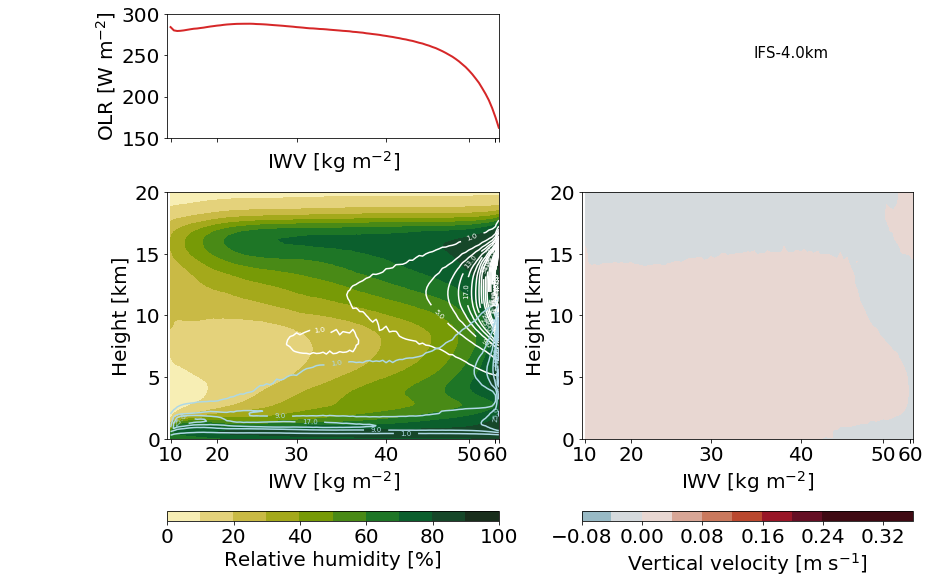

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec028.ss029.ax030, (left: 0.092) (bot: 0.698) (right: 0.536)  (top: 1.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec028.ss031.ax032, (left: 0.112) (bot: 0.142) (right: 0.536)  (top: 0.691) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec028.ss033.ax034, (left: 0.555) (bot: 0.142) (right: 0.980)  (top: 0.691) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec028.ss031.cbar, (left: 0.092) (bot: 0.012) (right: 0.553)  (top: 0.131) 
DEBUG:left 0.010241
DEBUG:right 0.024143
DEBUG:bottom 0.090278
DEBUG:LayoutBox:    gridspec028.ss033.cbar, (left: 0.582) (bot: 0.000) (right: 1.000)  (top: 0.131) 
DEBUG:left 0.036621
DEBUG:right 0.027466
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec028.ss104.ax105, (left: 0.000) (bot: 0.756) (right: 0.090)  (top: 0.993) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

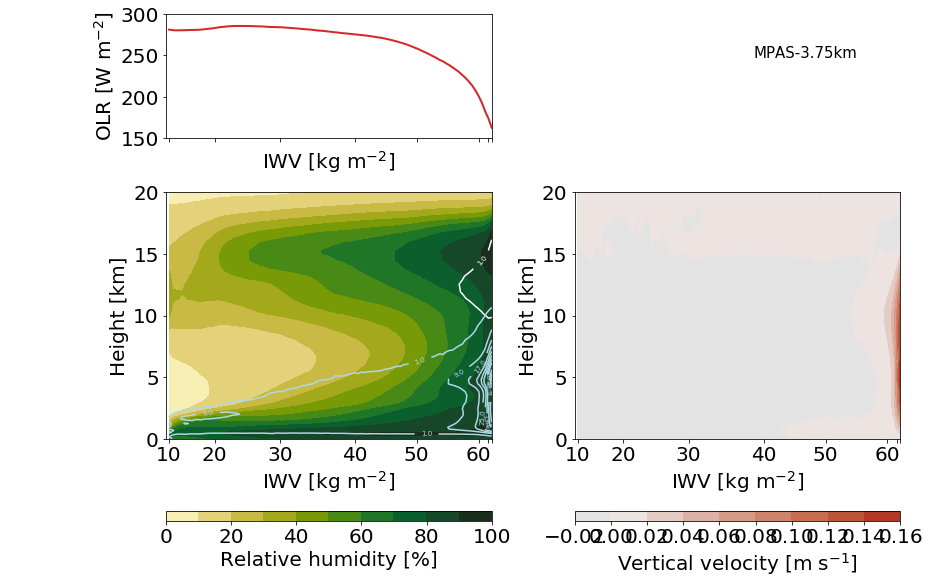

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec035.ss036.ax037, (left: 0.095) (bot: 0.698) (right: 0.547)  (top: 1.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec035.ss038.ax039, (left: 0.114) (bot: 0.143) (right: 0.547)  (top: 0.692) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec035.ss040.ax041, (left: 0.567) (bot: 0.143) (right: 1.000)  (top: 0.692) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec035.ss038.cbar, (left: 0.095) (bot: 0.012) (right: 0.564)  (top: 0.132) 
DEBUG:left 0.010241
DEBUG:right 0.024143
DEBUG:bottom 0.090278
DEBUG:LayoutBox:    gridspec035.ss040.cbar, (left: 0.567) (bot: 0.000) (right: 1.000)  (top: 0.132) 
DEBUG:left 0.036621
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec035.ss116.ax117, (left: 0.000) (bot: 0.756) (right: 0.093)  (top: 0.993) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

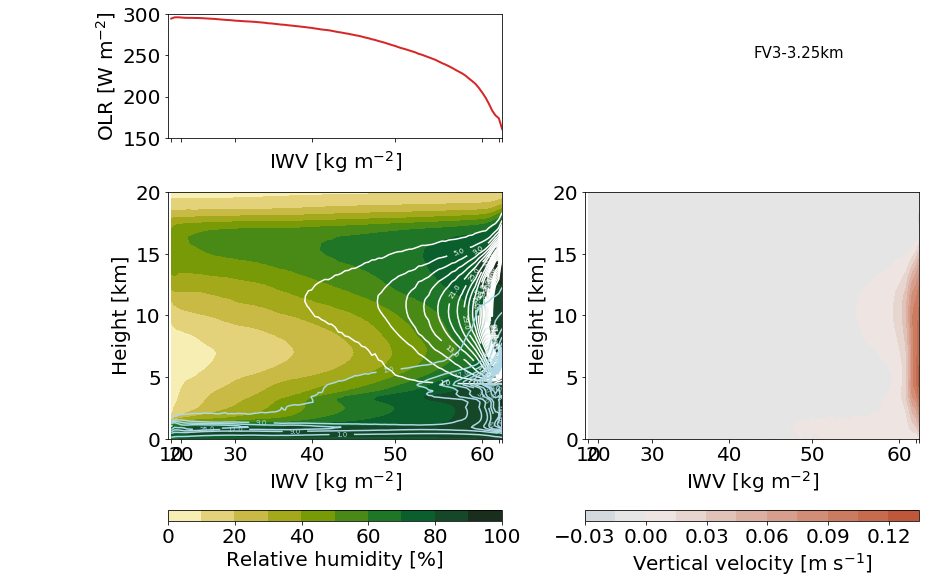

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec042.ss043.ax044, (left: 0.097) (bot: 0.698) (right: 0.557)  (top: 1.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec042.ss045.ax046, (left: 0.116) (bot: 0.143) (right: 0.557)  (top: 0.692) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec042.ss047.ax048, (left: 0.559) (bot: 0.143) (right: 1.000)  (top: 0.692) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec042.ss045.cbar, (left: 0.097) (bot: 0.012) (right: 0.557)  (top: 0.132) 
DEBUG:left 0.010241
DEBUG:right 0.007053
DEBUG:bottom 0.090278
DEBUG:LayoutBox:    gridspec042.ss047.cbar, (left: 0.559) (bot: 0.000) (right: 1.000)  (top: 0.132) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec042.ss128.ax129, (left: -0.000) (bot: 0.756) (right: 0.094)  (top: 0.993) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEB

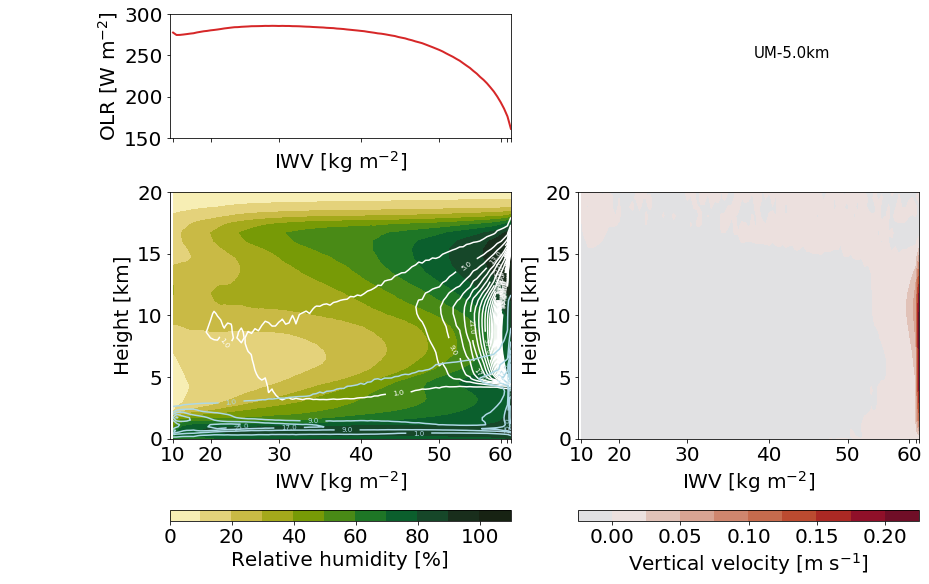

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec049.ss050.ax051, (left: 0.092) (bot: 0.698) (right: 0.536)  (top: 1.000) 
DEBUG:left 0.082900
DEBUG:right 0.007053
DEBUG:bottom 0.069271
DEBUG:LayoutBox:   gridspec049.ss052.ax053, (left: 0.112) (bot: 0.142) (right: 0.536)  (top: 0.691) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec049.ss054.ax055, (left: 0.555) (bot: 0.142) (right: 0.980)  (top: 0.691) 
DEBUG:left 0.063612
DEBUG:right 0.007053
DEBUG:bottom 0.102257
DEBUG:LayoutBox:    gridspec049.ss052.cbar, (left: 0.092) (bot: 0.012) (right: 0.553)  (top: 0.131) 
DEBUG:left 0.010241
DEBUG:right 0.024143
DEBUG:bottom 0.090278
DEBUG:LayoutBox:    gridspec049.ss054.cbar, (left: 0.555) (bot: 0.000) (right: 1.000)  (top: 0.131) 
DEBUG:left 0.007053
DEBUG:right 0.027466
DEBUG:bottom 0.102257
DEBUG:LayoutBox:   gridspec049.ss140.ax141, (left: -0.000) (bot: 0.756) (right: 0.090)  (top: 0.993) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEB

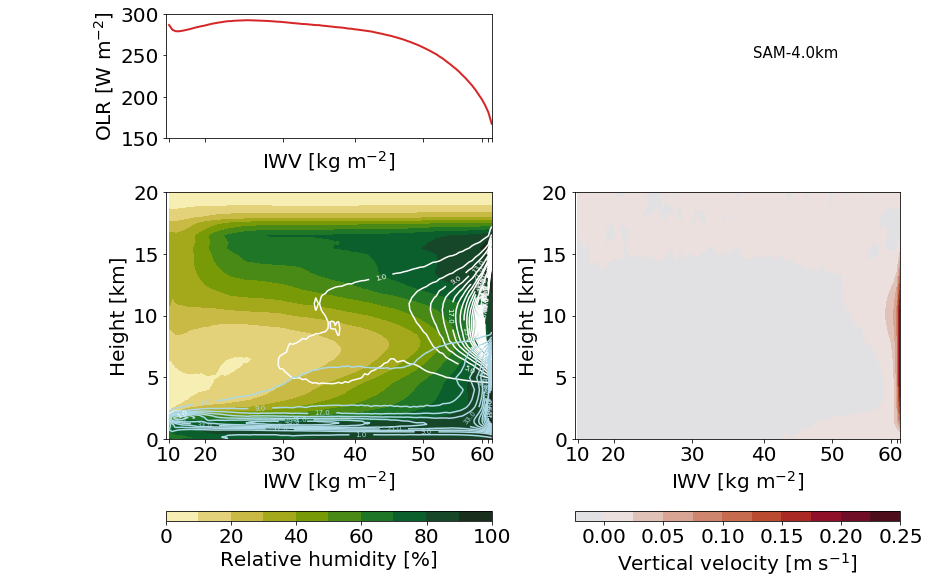

In [17]:

for m in exps:
    fig = plt.figure(figsize=(1.6 * 8, 8), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=9, nrows=3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 1:5])
    ax2 = fig.add_subplot(gs[1:, 1:5])
    ax3 = fig.add_subplot(gs[1:, 5:9])
    plt.annotate(m, xy=(0.81, 0.9), xycoords='figure fraction', fontsize=15)
    
    x_lims = [0, 100]
    y_lims = [150, 300]
    plots.moisture_space_line(ax1, perc_values, perc_mean[m]['OLR'],\
                              x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'OLR [W m$^{-2}$]', color='C3', lw=2)

    x_lims = [0, 100]
    y_lims = [0, 20]
    x_label = 'IWV [kg m$^{-2}$]'
    y_label = 'Height [km]'
    plots.moisture_space_contourf(fig, ax2, perc_values, height[m] * 1e-3, perc_mean[m]['RH'].T * 1e2, 10,\
                                  x_lims, y_lims, x_label, y_label, 'Relative humidity [%]',\
                                  cmap='speed', vmin=0, vmax=100)
    
    contours_ci = np.arange(1, 100, 4)
    contours_cl = np.arange(1, 120, 8)
    ci = plots.moisture_space_contour(fig, ax2, perc_values, height[m] * 1e-3, perc_mean[m]['QI'].T * 1e6, contours_ci,\
                                  x_lims, y_lims, x_label, y_label, 'w')
    cl = plots.moisture_space_contour(fig, ax2, perc_values, height[m] * 1e-3, perc_mean[m]['QC'].T * 1e6, contours_cl,\
                                  x_lims, y_lims, x_label, y_label, 'lightblue')
    
    ax2.clabel(ci, fontsize=7, fmt='%.1f')
    ax2.clabel(cl, fontsize=7, fmt='%.1f')
    #plots.moisture_space_line(ax2, perc_values, perc_mean[m]['UTH_bnds'][0] * 1e-3,\
    #                          x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'OLR [W m$^{-2}$]', color='k', lw=1)
    #plots.moisture_space_line(ax2, perc_values, perc_mean[m]['UTH_bnds'][1] * 1e-3,\
    #                          x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'Height [m]', color='k', lw=1)
    
    plots.moisture_space_contourf(fig, ax3, perc_values, height[m] * 1e-3, perc_mean[m]['W'].T, 10,\
                                  x_lims, y_lims, x_label, y_label, 'Vertical velocity [m s$^{-1}$]',\
                                 cmap='difference', vmin=-0.25, vmax=0.25)
    
    tick_labels = np.arange(10, 81, 10)
    tick_idx = []
    for t in tick_labels:
        tick_idx.append(np.argmin(np.abs(percentiles[m] - t)))
    ax1.set_xticks(tick_idx)
    ax1.set_xticklabels([])
    ax2.set_xticks(tick_idx)
    ax2.set_xticklabels(tick_labels)
    for label in ax2.xaxis.get_ticklabels()[-2:]:
        label.set_visible(False)
    ax3.set_xticks(tick_idx)
    ax3.set_xticklabels(tick_labels)
    for label in ax3.xaxis.get_ticklabels()[-2:]:
        label.set_visible(False)



### Moisture space overview plot

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec152.ss153.ax154, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.103723
DEBUG:right 0.010748
DEBUG:bottom 0.082639
DEBUG:LayoutBox:   gridspec152.ss155.ax156, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.079572
DEBUG:right 0.010748
DEBUG:bottom 0.117362
DEBUG:LayoutBox:   gridspec152.ss157.ax158, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0 to DejaVu Sans ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.097223
DEBUG:LayoutBox:    gridspec152.ss155.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.101852
DEBUG:LayoutBox:   gridspec152.ss157.ax159, (left: 0.000) (

DEBUG:LayoutBox:   gridspec184.ss224.ax225, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.010748
DEBUG:right 0.010748
DEBUG:bottom 0.015047
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:newpos (0.10372270171957676, 0.8554703218341301, 0.6568909314403591, 0.12948282631401814)
DEBUG:newpos (0.10372270171957676, 0.2791921471036646, 0.6568909314403591, 0.4661381747304653)
DEBUG:newpos (0.807255044917688, 0.2791921471036646, 0.1642227328600898, 0.4661381747304653)
DEBUG:newpos (0.10372270171957676, 0.10185240740740775, 0.6568909314403591, 0.03284454657201796)
DEBUG:newpos (0.807255044917688, 0.2791921471036646, 0.1642227328600898, 0.4661381747304653)
DEBUG:newpos (0.8072550449176878, 0.8554703218341299, 0.1642227328600898, 0.12948282631401814)
DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec192.ss193.ax194, (le

DEBUG:LayoutBox:   gridspec152.ss157.ax158, (left: 0.794) (bot: 0.050) (right: 1.000)  (top: 0.728) 
DEBUG:left 0.012747
DEBUG:right 0.028454
DEBUG:bottom 0.097061
DEBUG:LayoutBox:    gridspec152.ss155.cbar, (left: 0.024) (bot: 0.000) (right: 0.790)  (top: 0.150) 
DEBUG:left 0.012747
DEBUG:right 0.028454
DEBUG:bottom 0.101691
DEBUG:LayoutBox:   gridspec152.ss157.ax159, (left: 0.794) (bot: 0.050) (right: 1.000)  (top: 0.728) 
DEBUG:left 0.012747
DEBUG:right 0.010680
DEBUG:bottom 0.221007
DEBUG:LayoutBox:   gridspec152.ss216.ax217, (left: 0.796) (bot: 0.808) (right: 0.982)  (top: 0.959) 
DEBUG:left 0.010680
DEBUG:right 0.010680
DEBUG:bottom 0.014885
DEBUG:newpos (0.10365475055931306, 0.8199459076147616, 0.6581520865699866, 0.12001297039509565)
DEBUG:newpos (0.10365475055931306, 0.27808229397081646, 0.6581520865699866, 0.4320466934223442)
DEBUG:newpos (0.8070077072955448, 0.2780822939708167, 0.16453802164249665, 0.4320466934223442)
DEBUG:newpos (0.10365475055931306, 0.10169086751820786, 0

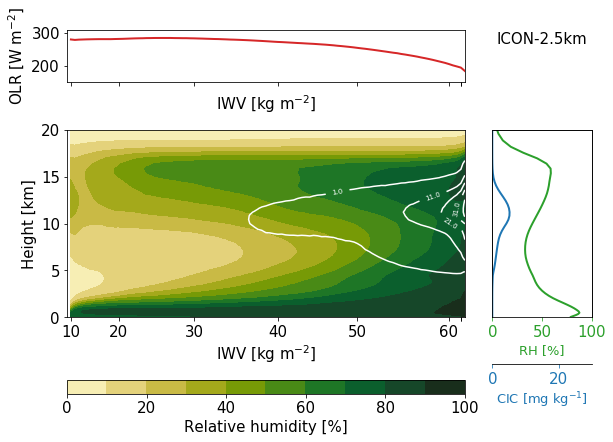

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec160.ss161.ax162, (left: 0.000) (bot: 0.773) (right: 0.771)  (top: 1.000) 
DEBUG:left 0.103723
DEBUG:right 0.010748
DEBUG:bottom 0.082639
DEBUG:LayoutBox:   gridspec160.ss163.ax164, (left: 0.024) (bot: 0.162) (right: 0.771)  (top: 0.766) 
DEBUG:left 0.079572
DEBUG:right 0.010748
DEBUG:bottom 0.117362
DEBUG:LayoutBox:   gridspec160.ss165.ax166, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.097223
DEBUG:LayoutBox:    gridspec160.ss163.cbar, (left: 0.024) (bot: 0.000) (right: 0.789)  (top: 0.150) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.101852
DEBUG:LayoutBox:   gridspec160.ss165.ax167, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.010748
DEBUG:bottom 0.229035
DEBUG:LayoutBox:   gridspec160.ss218.ax219, (left: 0.797) (bot: 0.840) (right: 0.982)  (top: 1.000) 
DEBUG:left 0.010748
DEBUG:right 0.010748
DEBU

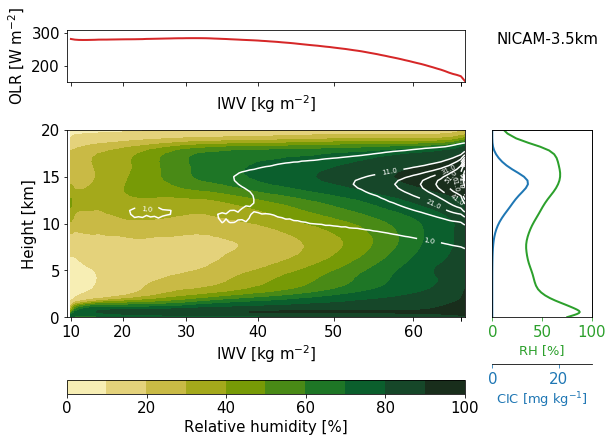

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec168.ss169.ax170, (left: 0.000) (bot: 0.773) (right: 0.771)  (top: 1.000) 
DEBUG:left 0.103723
DEBUG:right 0.010748
DEBUG:bottom 0.082639
DEBUG:LayoutBox:   gridspec168.ss171.ax172, (left: 0.024) (bot: 0.162) (right: 0.771)  (top: 0.766) 
DEBUG:left 0.079572
DEBUG:right 0.010748
DEBUG:bottom 0.117362
DEBUG:LayoutBox:   gridspec168.ss173.ax174, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.097223
DEBUG:LayoutBox:    gridspec168.ss171.cbar, (left: 0.024) (bot: 0.000) (right: 0.789)  (top: 0.150) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.101852
DEBUG:LayoutBox:   gridspec168.ss173.ax175, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.010748
DEBUG:bottom 0.229035
DEBUG:LayoutBox:   gridspec168.ss220.ax221, (left: 0.797) (bot: 0.840) (right: 0.982)  (top: 1.000) 
DEBUG:left 0.010748
DEBUG:right 0.010748
DEBU

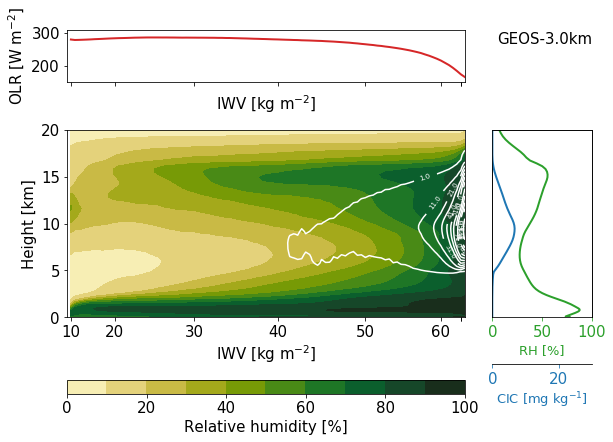

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec176.ss177.ax178, (left: 0.000) (bot: 0.773) (right: 0.771)  (top: 1.000) 
DEBUG:left 0.103723
DEBUG:right 0.010748
DEBUG:bottom 0.082639
DEBUG:LayoutBox:   gridspec176.ss179.ax180, (left: 0.024) (bot: 0.162) (right: 0.775)  (top: 0.766) 
DEBUG:left 0.079572
DEBUG:right 0.014099
DEBUG:bottom 0.117362
DEBUG:LayoutBox:   gridspec176.ss181.ax182, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.097223
DEBUG:LayoutBox:    gridspec176.ss179.cbar, (left: 0.024) (bot: 0.000) (right: 0.789)  (top: 0.150) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.101852
DEBUG:LayoutBox:   gridspec176.ss181.ax183, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.010748
DEBUG:bottom 0.229035
DEBUG:LayoutBox:   gridspec176.ss222.ax223, (left: 0.797) (bot: 0.840) (right: 0.982)  (top: 1.000) 
DEBUG:left 0.010748
DEBUG:right 0.010748
DEBU

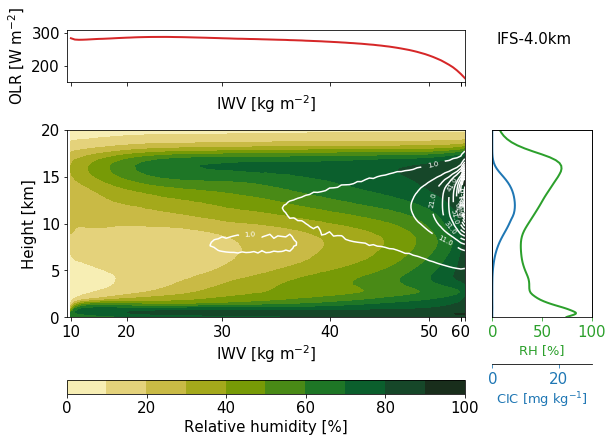

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec184.ss185.ax186, (left: 0.000) (bot: 0.773) (right: 0.771)  (top: 1.000) 
DEBUG:left 0.103723
DEBUG:right 0.010748
DEBUG:bottom 0.082639
DEBUG:LayoutBox:   gridspec184.ss187.ax188, (left: 0.024) (bot: 0.162) (right: 0.771)  (top: 0.766) 
DEBUG:left 0.079572
DEBUG:right 0.010748
DEBUG:bottom 0.117362
DEBUG:LayoutBox:   gridspec184.ss189.ax190, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.097223
DEBUG:LayoutBox:    gridspec184.ss187.cbar, (left: 0.024) (bot: 0.000) (right: 0.789)  (top: 0.150) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.101852
DEBUG:LayoutBox:   gridspec184.ss189.ax191, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.010748
DEBUG:bottom 0.229035
DEBUG:LayoutBox:   gridspec184.ss224.ax225, (left: 0.797) (bot: 0.840) (right: 0.982)  (top: 1.000) 
DEBUG:left 0.010748
DEBUG:right 0.010748
DEBU

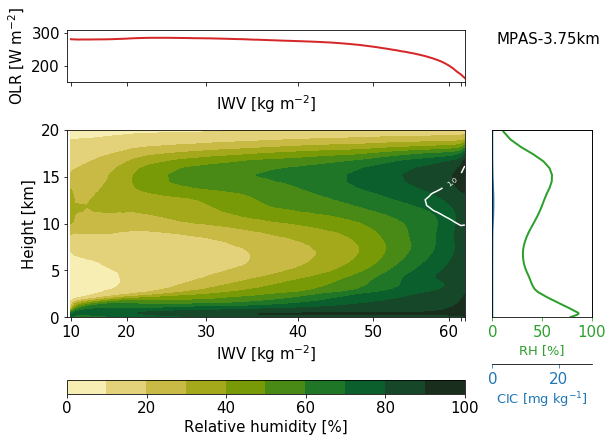

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec192.ss193.ax194, (left: 0.000) (bot: 0.773) (right: 0.771)  (top: 1.000) 
DEBUG:left 0.103723
DEBUG:right 0.010748
DEBUG:bottom 0.082639
DEBUG:LayoutBox:   gridspec192.ss195.ax196, (left: 0.024) (bot: 0.162) (right: 0.771)  (top: 0.766) 
DEBUG:left 0.079572
DEBUG:right 0.010748
DEBUG:bottom 0.117362
DEBUG:LayoutBox:   gridspec192.ss197.ax198, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.097223
DEBUG:LayoutBox:    gridspec192.ss195.cbar, (left: 0.024) (bot: 0.000) (right: 0.789)  (top: 0.150) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.101852
DEBUG:LayoutBox:   gridspec192.ss197.ax199, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.010748
DEBUG:bottom 0.229035
DEBUG:LayoutBox:   gridspec192.ss226.ax227, (left: 0.797) (bot: 0.840) (right: 0.982)  (top: 1.000) 
DEBUG:left 0.010748
DEBUG:right 0.010748
DEBU

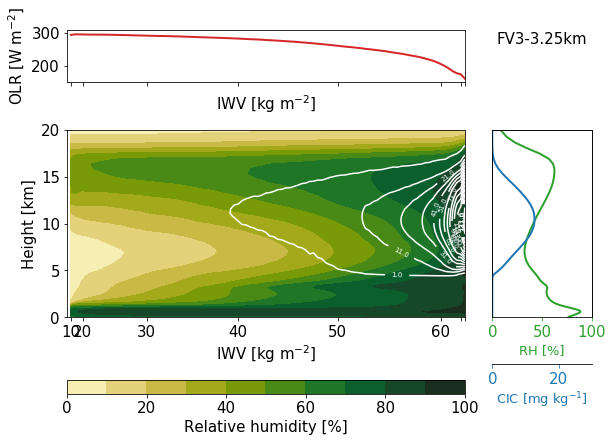

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec200.ss201.ax202, (left: 0.000) (bot: 0.773) (right: 0.786)  (top: 1.000) 
DEBUG:left 0.103723
DEBUG:right 0.010748
DEBUG:bottom 0.082639
DEBUG:LayoutBox:   gridspec200.ss203.ax204, (left: 0.024) (bot: 0.163) (right: 0.786)  (top: 0.766) 
DEBUG:left 0.079572
DEBUG:right 0.010748
DEBUG:bottom 0.117362
DEBUG:LayoutBox:   gridspec200.ss205.ax206, (left: 0.790) (bot: 0.045) (right: 1.000)  (top: 0.761) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.097223
DEBUG:LayoutBox:    gridspec200.ss203.cbar, (left: 0.024) (bot: 0.000) (right: 0.786)  (top: 0.150) 
DEBUG:left 0.012815
DEBUG:right 0.010748
DEBUG:bottom 0.101852
DEBUG:LayoutBox:   gridspec200.ss205.ax207, (left: 0.790) (bot: 0.045) (right: 1.000)  (top: 0.761) 
DEBUG:left 0.012815
DEBUG:right 0.010748
DEBUG:bottom 0.228898
DEBUG:LayoutBox:   gridspec200.ss228.ax229, (left: 0.793) (bot: 0.841) (right: 0.982)  (top: 1.000) 
DEBUG:left 0.010748
DEBUG:right 0.010748
DEBU

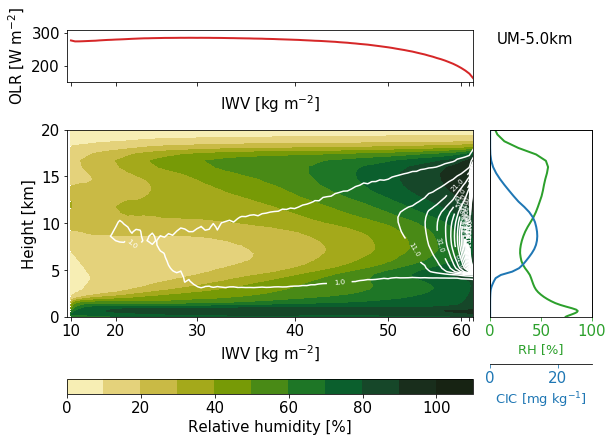

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec208.ss209.ax210, (left: 0.000) (bot: 0.773) (right: 0.771)  (top: 1.000) 
DEBUG:left 0.103723
DEBUG:right 0.010748
DEBUG:bottom 0.082639
DEBUG:LayoutBox:   gridspec208.ss211.ax212, (left: 0.024) (bot: 0.162) (right: 0.771)  (top: 0.766) 
DEBUG:left 0.079572
DEBUG:right 0.010748
DEBUG:bottom 0.117362
DEBUG:LayoutBox:   gridspec208.ss213.ax214, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.097223
DEBUG:LayoutBox:    gridspec208.ss211.cbar, (left: 0.024) (bot: 0.000) (right: 0.789)  (top: 0.150) 
DEBUG:left 0.012815
DEBUG:right 0.028522
DEBUG:bottom 0.101852
DEBUG:LayoutBox:   gridspec208.ss213.ax215, (left: 0.793) (bot: 0.045) (right: 1.000)  (top: 0.760) 
DEBUG:left 0.012815
DEBUG:right 0.010748
DEBUG:bottom 0.229035
DEBUG:LayoutBox:   gridspec208.ss230.ax231, (left: 0.797) (bot: 0.840) (right: 0.982)  (top: 1.000) 
DEBUG:left 0.010748
DEBUG:right 0.010748
DEBU

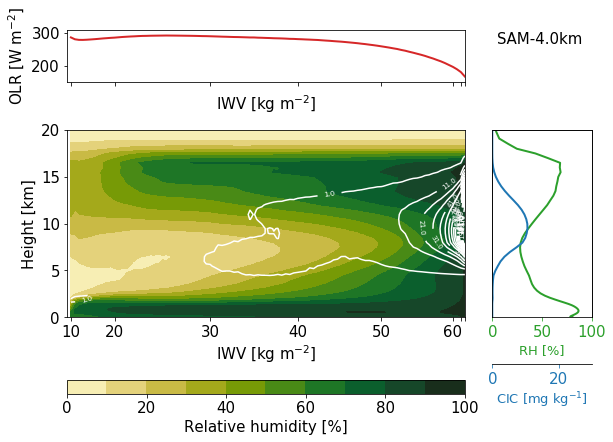

In [18]:
plt.rcParams.update({'font.size': 15})
for m in exps:
    fig = plt.figure(figsize=(1.4 * 6, 6), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=5, nrows=3, figure=fig)
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1:, :-1])
    ax3 = fig.add_subplot(gs[1:, 4])
    plt.annotate(m, xy=(0.81, 0.9), xycoords='figure fraction', fontsize=15)
    
    x_lims = [0, 100]
    y_lims = [150, 310]
    plots.moisture_space_line(ax1, perc_values, perc_mean[m]['OLR'],\
                              x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'OLR [W m$^{-2}$]', color='C3', lw=2)

    x_lims = [0, 100]
    y_lims = [0, 20]
    x_label = 'IWV [kg m$^{-2}$]'
    y_label = 'Height [km]'
    plots.moisture_space_contourf(fig, ax2, perc_values, height[m] * 1e-3, perc_mean[m]['RH'].T * 1e2, 10,\
                                  x_lims, y_lims, x_label, y_label, 'Relative humidity [%]',\
                                  cmap='speed', vmin=0, vmax=100)
    
    contours_ci = np.arange(1, 200, 10)
    contours_cl = np.arange(1, 120, 8)
    ci = plots.moisture_space_contour(fig, ax2, perc_values, height[m] * 1e-3, perc_mean[m]['QI'].T * 1e6, contours_ci,\
                                  x_lims, y_lims, x_label, y_label, 'w')
    #cl = plots.moisture_space_contour(fig, ax2, perc_values, height[m] * 1e-3, perc_mean[m]['QC'].T * 1e6, contours_cl,\
    #                              x_lims, y_lims, x_label, y_label, 'lightblue')
    
    ax2.clabel(ci, fontsize=7, fmt='%.1f')
    #ax2.clabel(cl, fontsize=7, fmt='%.1f')
    #plots.moisture_space_line(ax2, perc_values, perc_mean[m]['UTH_bnds'][0] * 1e-3,\
    #                          x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'OLR [W m$^{-2}$]', color='k', lw=1)
    #plots.moisture_space_line(ax2, perc_values, perc_mean[m]['UTH_bnds'][1] * 1e-3,\
    #                          x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'Height [m]', color='k', lw=1)
    
    x_lims = [0, 100]
    y_lims = [0, 20]
    mean_rh = np.nanmean(perc_mean[m]['RH'], axis=0)
    mean_qi = np.nanmean(perc_mean[m]['QI'], axis=0)
    mean_qc = np.nanmean(perc_mean[m]['QC'], axis=0)
    plots.moisture_space_line(ax3, mean_rh * 1e2, height[m] * 1e-3,\
                              x_lims, y_lims, 'RH [%]', '', color='C2', lw=2)
    ax3.set_xlabel('RH [%]', color='C2', fontsize=13)
    ax3.tick_params(axis='x', colors='C2')
    ax3.set_yticks([])
    ax4 = ax3.twiny()
    x_lims = [0, 30]
    plots.moisture_space_line(ax4, mean_qi * 1e6, height[m] * 1e-3,\
                              x_lims, y_lims, 'CIC [mg kg$^{-1}$]', '', color='C0', lw=2)    
    ax4.xaxis.set_ticks_position("bottom")
    ax4.xaxis.set_label_position("bottom")
    ax4.spines["bottom"].set_position(("axes", -0.25))
    ax4.tick_params(axis='x', colors='C0')
    ax4.set_xlabel('CIC [mg kg$^{-1}$]', color='C0', fontsize=13)
    ax4.set_yticks([])
    
#    ax5 = ax3.twiny()
#    x_lims = [0, 30]
#    plots.moisture_space_line(ax4, mean_qc * 1e6, height[m] * 1e-3,\
#                              x_lims, y_lims, 'CIC/CWC [mg kg$^{-1}$]', '', color='lightblue', lw=2)    
#    ax5.set_yticks([])
#    ax5.set_xticks([])
    
    tick_labels = np.arange(10, 81, 10)
    tick_idx = []
    for t in tick_labels:
        tick_idx.append(np.argmin(np.abs(percentiles[m] - t)))
    ax1.set_xticks(tick_idx)
    ax1.set_xticklabels([])
    ax2.set_xticks(tick_idx)
    ax2.set_xticklabels(tick_labels)
    for label in ax2.xaxis.get_ticklabels()[-2:]:
        label.set_visible(False)




### RH, QI, OLR and W in moisture space (Bins)

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec232.ss233.ax234, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec232.ss235.ax236, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.052219
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec232.ss237.ax238, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.052219
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec232.ss235.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.008410
DEBUG:right 0.018718
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec232.ss237.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec232.ss288.ax289, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:LayoutBox:   gridspec246.ss322.ax323, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:newpos (0.16531487027392103, 0.7652865107624929, 0.37265874324845666, 0.21908807257084018)
DEBUG:newpos (0.1653148702739198, 0.2167970322874787, 0.37265874324845666, 0.43817614514168035)
DEBUG:newpos (0.6111327715084885, 0.21679703228747882, 0.37265874324845666, 0.43817614514168035)
DEBUG:newpos (0.1653148702739198, 0.08802125000000027, 0.37265874324845666, 0.01

DEBUG:newpos (0.007053211805555626, 0.4358860963325928, 0.08092573664158975, 0.2190875768337039)
DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec267.ss268.ax269, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec267.ss270.ax271, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.052219
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec267.ss272.ax273, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.052219
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec267.ss270.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.008410
DEBUG:right 0.018786
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec267.ss272.cbar, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.022990
DEBUG:right 0.016141
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec267.ss348.ax349, (left

DEBUG:LayoutBox:   gridspec281.ss380.ax381, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:LayoutBox:   gridspec281.ss382.ax383, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.011285
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:rownum0min == rownumCmin
DEBUG:rownum0max == rownumCmax
DEBUG:newpos (0.16618141878858073, 0.7653435205331942, 0.3761249373070987, 0.21903106280013865)
DEBUG:newpos (0.16618141878858061, 0.21696806159958268, 0.3761249373070988, 0.4380621256002777)
DEBUG:newpos (0.6103114342206789, 0.216968061599583, 0.3761249373070985, 0.43

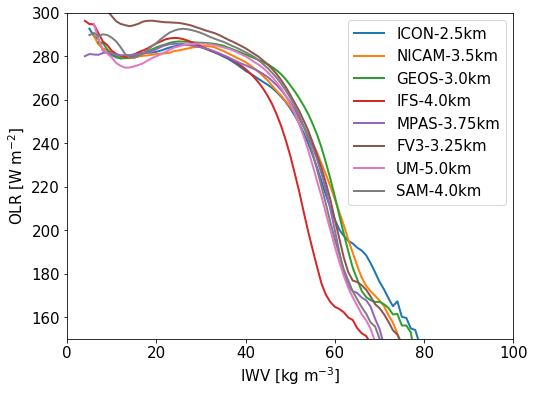

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec232.ss233.ax234, (left: 0.098) (bot: 0.677) (right: 0.553)  (top: 1.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec232.ss235.ax236, (left: 0.113) (bot: 0.129) (right: 0.553)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec232.ss237.ax238, (left: 0.560) (bot: 0.129) (right: 1.000)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec232.ss235.cbar, (left: 0.098) (bot: 0.012) (right: 0.558)  (top: 0.118) 
DEBUG:left 0.008410
DEBUG:right 0.018718
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec232.ss237.cbar, (left: 0.560) (bot: 0.000) (right: 1.000)  (top: 0.118) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec232.ss288.ax289, (left: -0.000) (bot: 0.754) (right: 0.095)  (top: 0.996) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEB

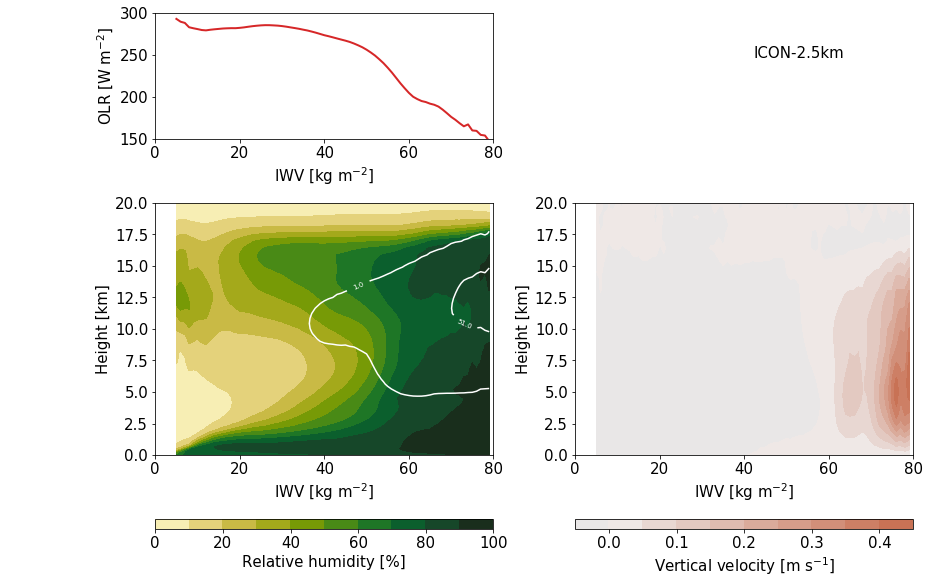

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec239.ss240.ax241, (left: 0.097) (bot: 0.677) (right: 0.549)  (top: 1.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec239.ss242.ax243, (left: 0.113) (bot: 0.129) (right: 0.549)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec239.ss244.ax245, (left: 0.556) (bot: 0.129) (right: 0.992)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec239.ss242.cbar, (left: 0.097) (bot: 0.012) (right: 0.554)  (top: 0.118) 
DEBUG:left 0.008410
DEBUG:right 0.018718
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec239.ss244.cbar, (left: 0.580) (bot: 0.000) (right: 1.000)  (top: 0.118) 
DEBUG:left 0.028144
DEBUG:right 0.021363
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec239.ss300.ax301, (left: 0.000) (bot: 0.754) (right: 0.094)  (top: 0.996) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

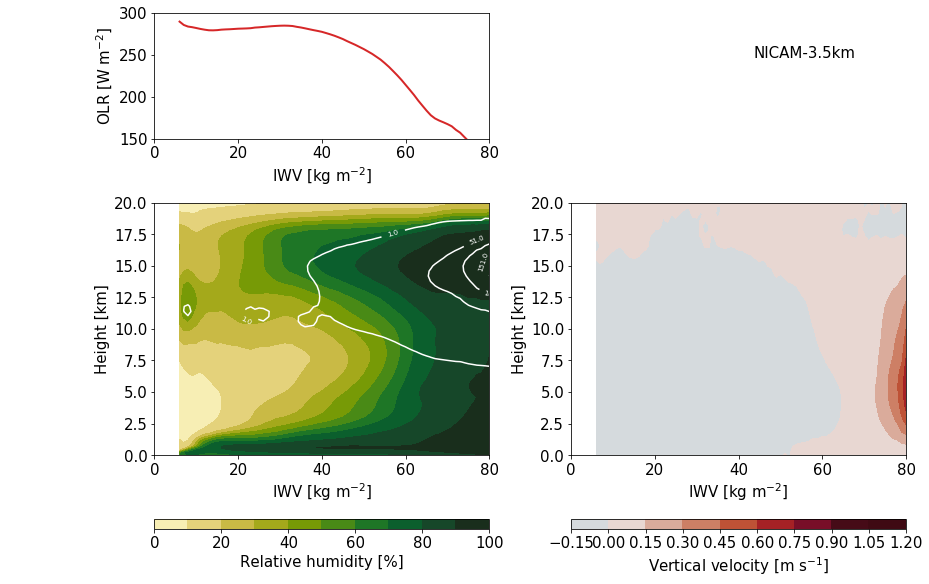

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec246.ss247.ax248, (left: 0.097) (bot: 0.677) (right: 0.552)  (top: 1.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec246.ss249.ax250, (left: 0.113) (bot: 0.129) (right: 0.552)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec246.ss251.ax252, (left: 0.559) (bot: 0.129) (right: 0.997)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec246.ss249.cbar, (left: 0.097) (bot: 0.012) (right: 0.557)  (top: 0.118) 
DEBUG:left 0.008410
DEBUG:right 0.018718
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec246.ss251.cbar, (left: 0.559) (bot: 0.000) (right: 1.000)  (top: 0.118) 
DEBUG:left 0.022990
DEBUG:right 0.016208
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec246.ss312.ax313, (left: 0.000) (bot: 0.754) (right: 0.095)  (top: 0.996) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

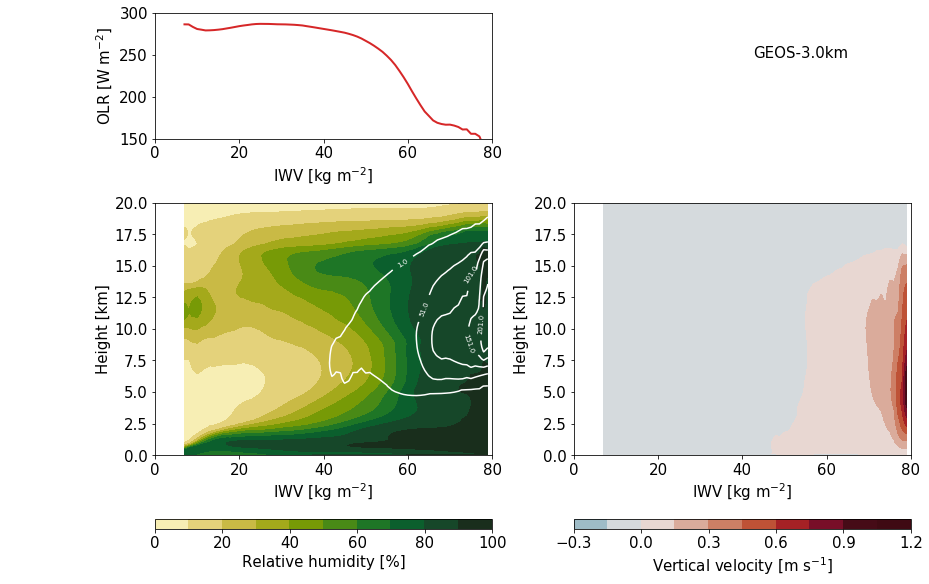

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec253.ss254.ax255, (left: 0.098) (bot: 0.677) (right: 0.554)  (top: 1.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec253.ss256.ax257, (left: 0.114) (bot: 0.129) (right: 0.554)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec253.ss258.ax259, (left: 0.557) (bot: 0.129) (right: 0.997)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec253.ss256.cbar, (left: 0.098) (bot: 0.012) (right: 0.554)  (top: 0.118) 
DEBUG:left 0.008410
DEBUG:right 0.007053
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec253.ss258.cbar, (left: 0.557) (bot: 0.000) (right: 1.000)  (top: 0.118) 
DEBUG:left 0.022990
DEBUG:right 0.016208
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec253.ss324.ax325, (left: 0.000) (bot: 0.754) (right: 0.096)  (top: 0.996) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

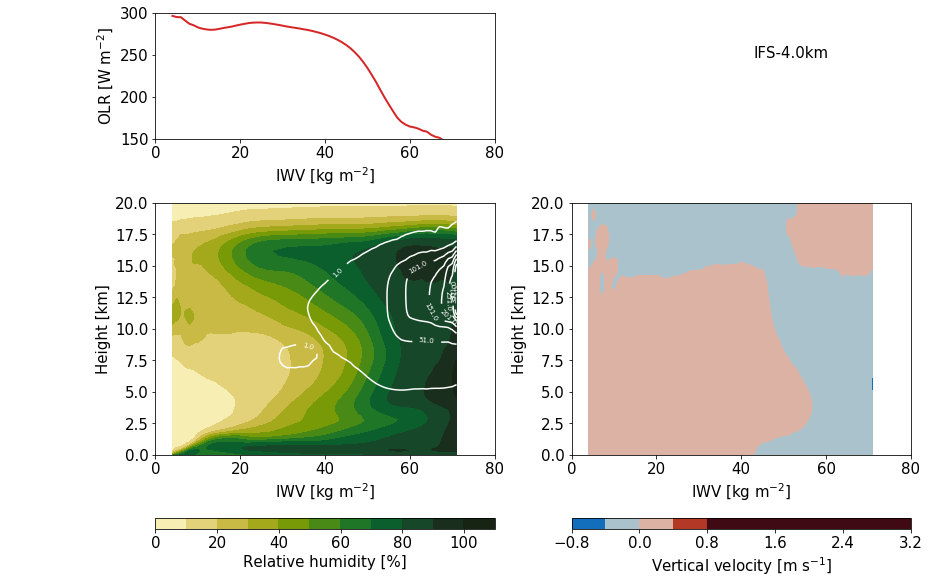

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec260.ss261.ax262, (left: 0.097) (bot: 0.677) (right: 0.552)  (top: 1.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec260.ss263.ax264, (left: 0.113) (bot: 0.129) (right: 0.552)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec260.ss265.ax266, (left: 0.559) (bot: 0.129) (right: 0.997)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec260.ss263.cbar, (left: 0.097) (bot: 0.012) (right: 0.557)  (top: 0.118) 
DEBUG:left 0.008410
DEBUG:right 0.018718
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec260.ss265.cbar, (left: 0.559) (bot: 0.000) (right: 1.000)  (top: 0.118) 
DEBUG:left 0.007053
DEBUG:right 0.016141
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec260.ss336.ax337, (left: 0.000) (bot: 0.754) (right: 0.095)  (top: 0.996) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

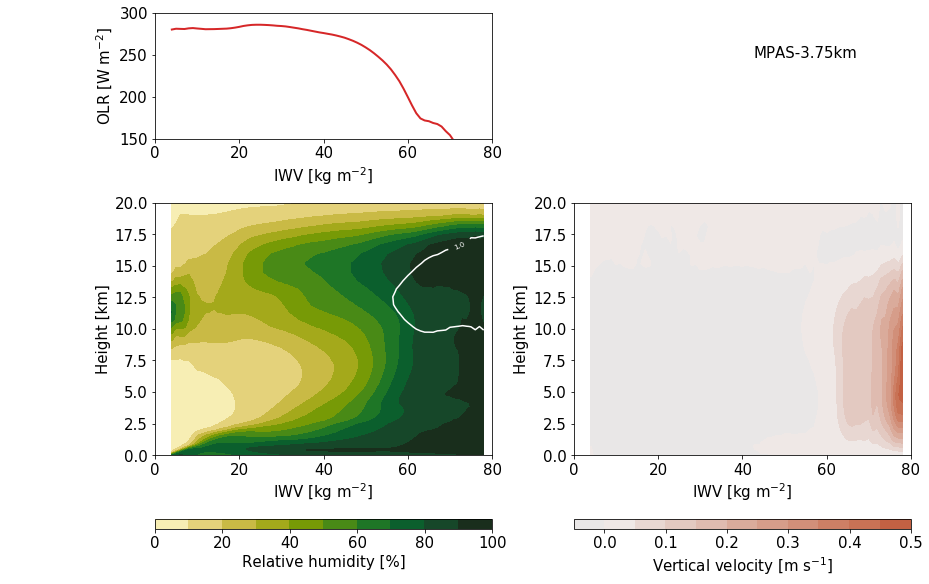

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec267.ss268.ax269, (left: 0.097) (bot: 0.677) (right: 0.552)  (top: 1.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec267.ss270.ax271, (left: 0.113) (bot: 0.129) (right: 0.552)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec267.ss272.ax273, (left: 0.559) (bot: 0.129) (right: 0.997)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec267.ss270.cbar, (left: 0.097) (bot: 0.012) (right: 0.557)  (top: 0.118) 
DEBUG:left 0.008410
DEBUG:right 0.018786
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec267.ss272.cbar, (left: 0.559) (bot: 0.000) (right: 1.000)  (top: 0.118) 
DEBUG:left 0.022990
DEBUG:right 0.016141
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec267.ss348.ax349, (left: -0.000) (bot: 0.754) (right: 0.095)  (top: 0.996) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEB

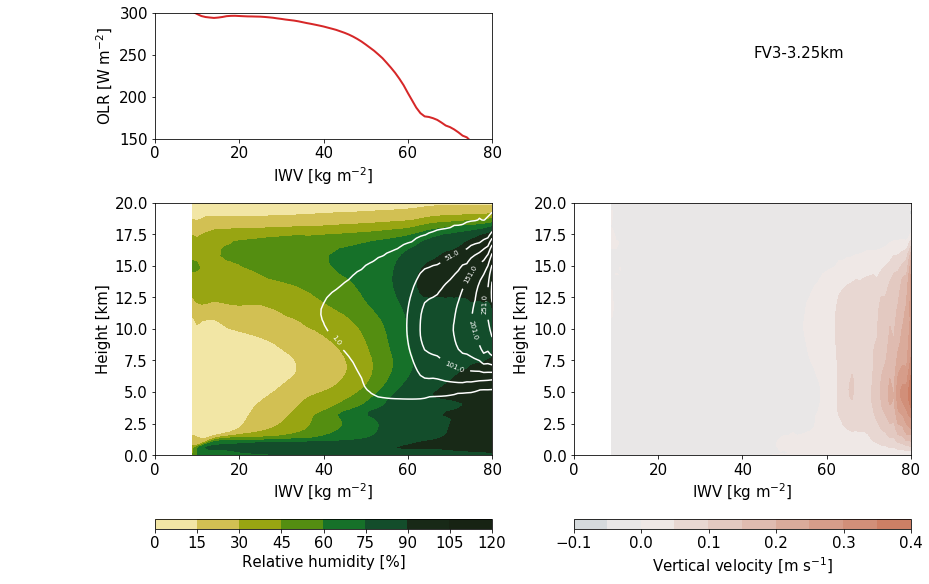

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec274.ss275.ax276, (left: 0.098) (bot: 0.677) (right: 0.556)  (top: 1.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec274.ss277.ax278, (left: 0.114) (bot: 0.129) (right: 0.556)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec274.ss279.ax280, (left: 0.558) (bot: 0.129) (right: 1.000)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec274.ss277.cbar, (left: 0.098) (bot: 0.012) (right: 0.556)  (top: 0.118) 
DEBUG:left 0.008410
DEBUG:right 0.007053
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec274.ss279.cbar, (left: 0.558) (bot: 0.000) (right: 1.000)  (top: 0.118) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec274.ss360.ax361, (left: 0.000) (bot: 0.754) (right: 0.096)  (top: 0.996) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

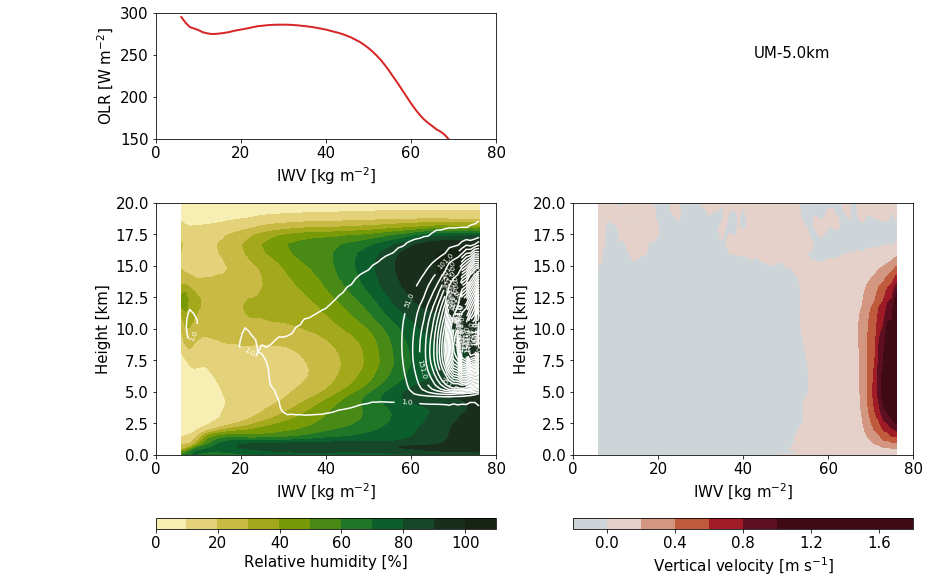

DEBUG:Executing constrainedlayout
DEBUG:LayoutBox:   gridspec281.ss282.ax283, (left: 0.098) (bot: 0.677) (right: 0.556)  (top: 1.000) 
DEBUG:left 0.068068
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec281.ss284.ax285, (left: 0.114) (bot: 0.129) (right: 0.556)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec281.ss286.ax287, (left: 0.558) (bot: 0.129) (right: 1.000)  (top: 0.671) 
DEBUG:left 0.067681
DEBUG:right 0.013564
DEBUG:bottom 0.088021
DEBUG:LayoutBox:    gridspec281.ss284.cbar, (left: 0.098) (bot: 0.012) (right: 0.556)  (top: 0.118) 
DEBUG:left 0.008410
DEBUG:right 0.007053
DEBUG:bottom 0.076389
DEBUG:LayoutBox:    gridspec281.ss286.cbar, (left: 0.558) (bot: 0.000) (right: 1.000)  (top: 0.118) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBUG:bottom 0.088021
DEBUG:LayoutBox:   gridspec281.ss372.ax373, (left: 0.000) (bot: 0.754) (right: 0.096)  (top: 0.996) 
DEBUG:left 0.007053
DEBUG:right 0.007053
DEBU

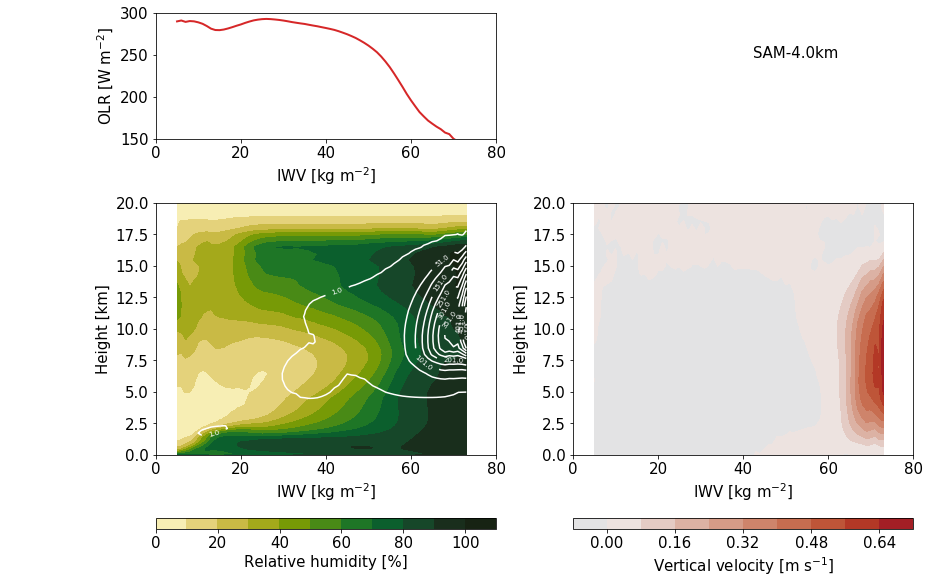

In [19]:
reload(plots)
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(8, 6))
x_lims = [0, 100]
y_lims = [150, 300]
for m in exps:
    plots.moisture_space_line(ax, bins, bin_mean_plot[m]['OLR'],\
                              x_lims, y_lims, 'IWV [kg m$^{-3}$]', 'OLR [W m$^{-2}$]', lw=2, label=m)
    #tick_labels = np.arange(10, 81, 10)
ax.legend()


for m in exps:
    fig = plt.figure(figsize=(1.6 * 8, 8), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=9, nrows=3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 1:5])
    ax2 = fig.add_subplot(gs[1:, 1:5])
    ax3 = fig.add_subplot(gs[1:, 5:9])
    plt.annotate(m, xy=(0.81, 0.9), xycoords='figure fraction', fontsize=15)
    
    x_lims = [0, 80]
    y_lims = [150, 300]
    plots.moisture_space_line(ax1, bins, bin_mean_plot[m]['OLR'],\
                              x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'OLR [W m$^{-2}$]', color='C3', lw=2)

    x_lims = [0, 80]
    y_lims = [0, 20]
    x_label = 'IWV [kg m$^{-2}$]'
    y_label = 'Height [km]'
    plots.moisture_space_contourf(fig, ax2, bins, height[m] * 1e-3, bin_mean_plot[m]['RH'] * 1e2, 10,\
                                  x_lims, y_lims, x_label, y_label, 'Relative humidity [%]',\
                                  cmap='speed', vmin=0, vmax=100)
    
    contours_ci = np.arange(1, 1800, 50)
    contours_cl = np.arange(1, 200, 10)
    ci = plots.moisture_space_contour(fig, ax2, bins, height[m] * 1e-3, bin_mean_plot[m]['QI'] * 1e6, contours_ci,\
                                  x_lims, y_lims, x_label, y_label, 'w')
    #cl = plots.moisture_space_contour(fig, ax2, bins, height[m] * 1e-3, bin_mean_plot[m]['QC'] * 1e6, contours_cl,\
    #                              x_lims, y_lims, x_label, y_label, 'lightblue')
    
    ax2.clabel(ci, fontsize=7, fmt='%.1f')
    #ax2.clabel(cl, fontsize=7, fmt='%.1f')
    #plots.moisture_space_line(ax2, bins, bin_mean_plot[m]['UTH_bnds'][0] * 1e-3,\
    #                          x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'OLR [W m$^{-2}$]', color='k', lw=1)
    #plots.moisture_space_line(ax2, bins, bin_mean_plot[m]['UTH_bnds'][1] * 1e-3,\
    #                          x_lims, y_lims, 'IWV [kg m$^{-2}$]', 'OLR [W m$^{-2}$]', color='k', lw=1)
    
    plots.moisture_space_contourf(fig, ax3, bins, height[m] * 1e-3, bin_mean_plot[m]['W'], 10,\
                                  x_lims, y_lims, x_label, y_label, 'Vertical velocity [m s$^{-1}$]',\
                                 cmap='difference', vmin=-1, vmax=1)

## Differences between individual models

### Two models

Text(0.5,1,'IFS-4.0km - UM-5.0km')

DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=24.0 to DejaVu Sans ('/work/um0878/sw/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


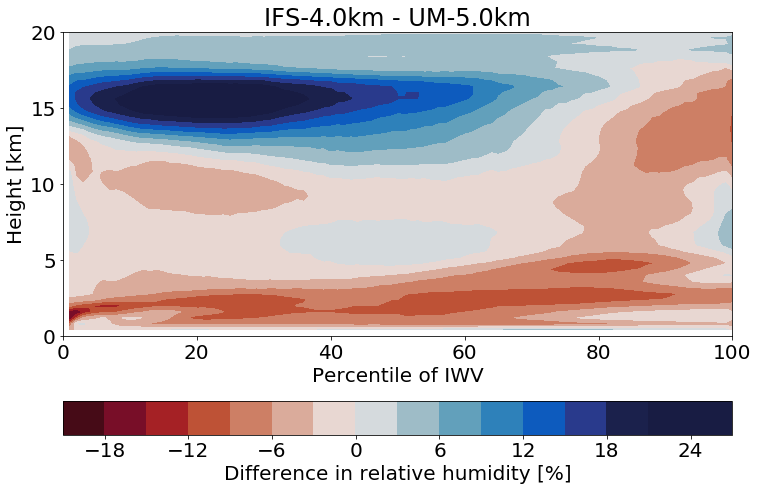

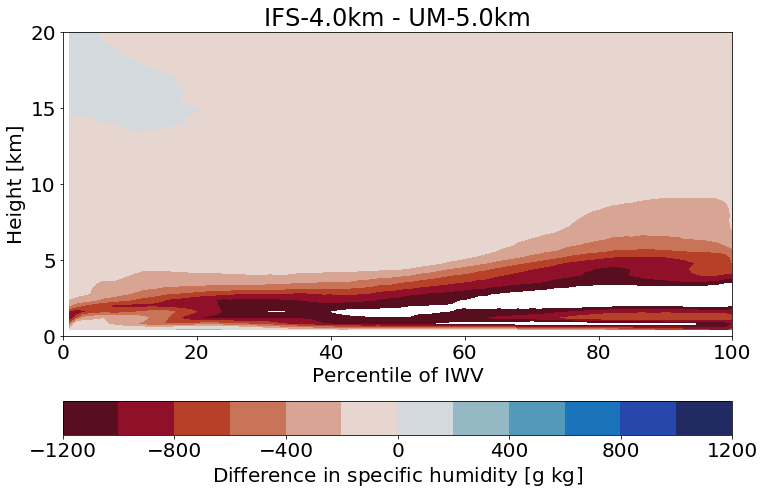

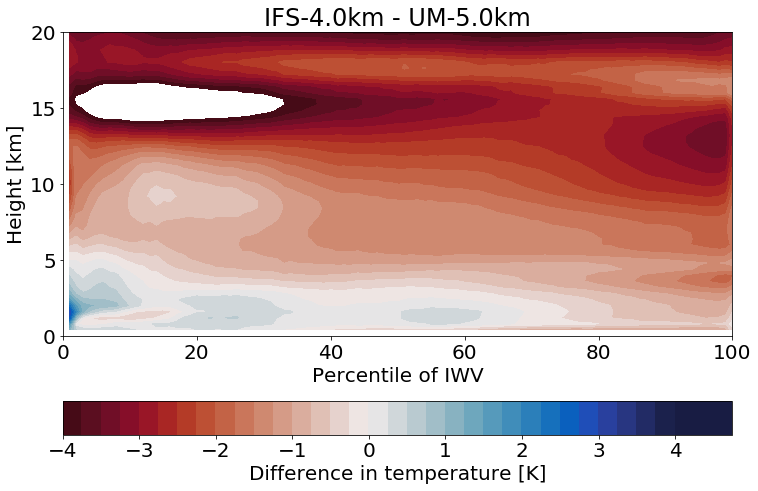

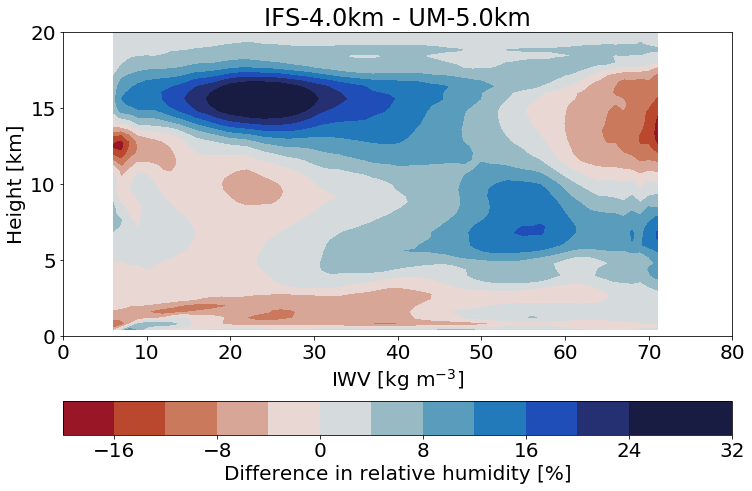

In [20]:
plt.rcParams.update({'font.size': 20})
model_1 = 'IFS-4.0km'
model_2 = 'UM-5.0km'
fig, ax = plt.subplots(figsize=(12, 8))
y_lims = [0, 20]
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, (perc_mean_interp[model_1]['RH'] - perc_mean_interp[model_2]['RH']) * 1e2, 15,\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Difference in relative humidity [%]',\
                                  cmap='difference_r', vmin=-20, vmax=20)
ax.set_title(f'{model_1} - {model_2}')

fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, (perc_mean_interp[model_1]['QV'] - perc_mean_interp[model_2]['QV']) * 1e6, np.arange(-1200, 1400, 200),\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Difference in specific humidity [g kg$^{}$]',\
                                  cmap='difference_r', vmin=-1200, vmax=1200)
ax.set_title(f'{model_1} - {model_2}')

fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, (perc_mean_interp[model_1]['TEMP'] - perc_mean_interp[model_2]['TEMP']), np.arange(-4, 5, 0.25),\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Difference in temperature [K]',\
                                  cmap='difference_r', vmin=-4, vmax=4)
ax.set_title(f'{model_1} - {model_2}')

fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, bins, h * 1e-3, (bin_mean_plot_interp[model_1]['RH'] - bin_mean_plot_interp[model_2]['RH']) * 1e2, 15,\
                                  [0, 80], y_lims, 'IWV [kg m$^{-3}$]', y_label, 'Difference in relative humidity [%]',\
                                  cmap='difference_r', vmin=-25, vmax=25)
ax.set_title(f'{model_1} - {model_2}')

Text(0.5,1,'IFS-4.0km - UM-5.0km')

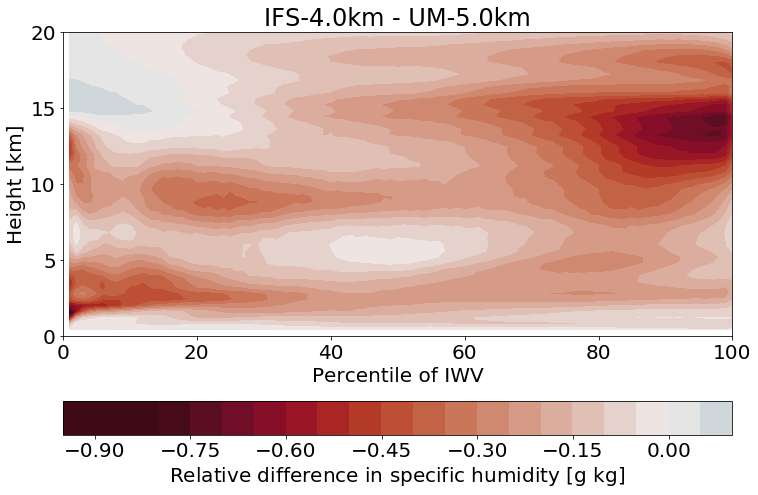

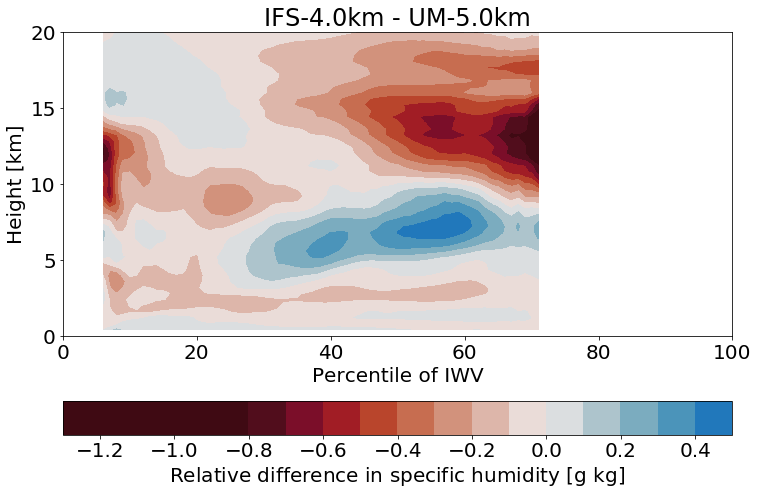

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, (perc_mean_interp[model_1]['QV'] - perc_mean_interp[model_2]['QV']) / perc_mean_interp[model_1]['QV'], 20,\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Relative difference in specific humidity [g kg$^{}$]',\
                                  cmap='difference_r', vmin=-0.8, vmax=0.8)
ax.set_title(f'{model_1} - {model_2}')

fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, bins, h * 1e-3, (bin_mean_plot_interp[model_1]['QV'] - bin_mean_plot_interp[model_2]['QV']) / perc_mean_interp[model_1]['QV'], 20,\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Relative difference in specific humidity [g kg$^{}$]',\
                                  cmap='difference_r', vmin=-0.8, vmax=0.8)
ax.set_title(f'{model_1} - {model_2}')

#### Shifted plot

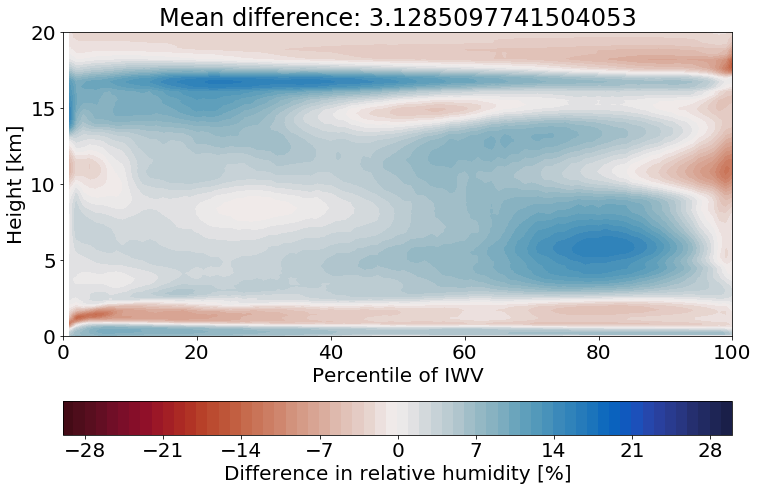

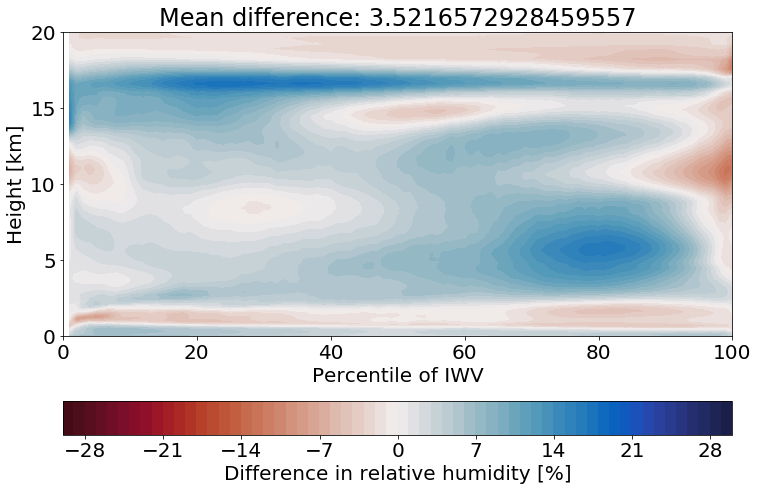

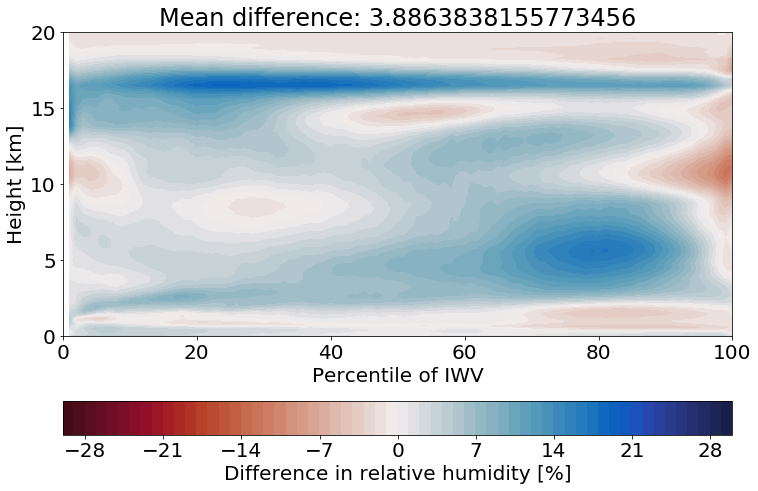

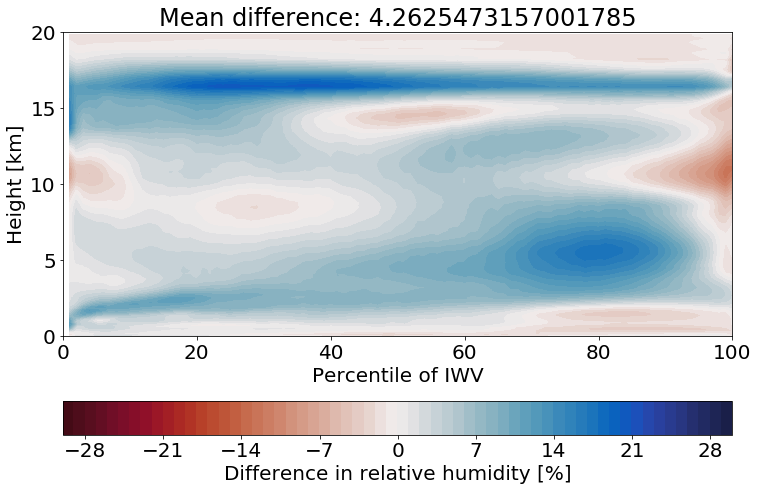

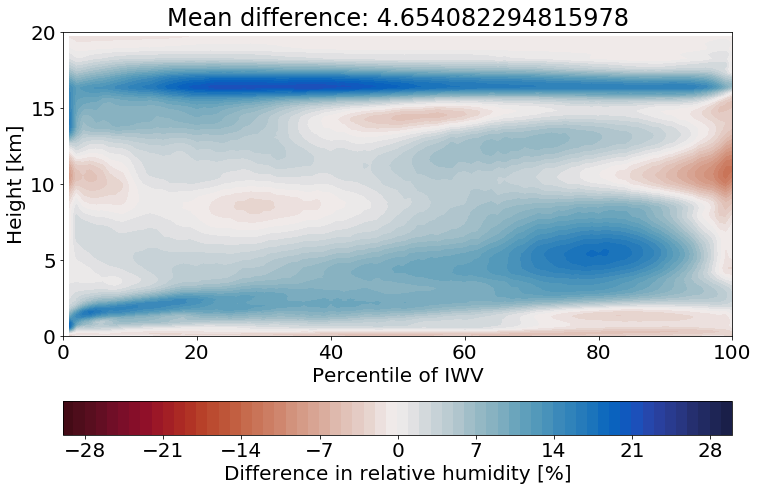

In [32]:
plt.rcParams.update({'font.size': 20})
model_1 = 'ICON-2.5km'
model_2 = 'GEOS-3.0km'
y_lims = [0, 20]

for s in range(0, 5):
    fig, ax = plt.subplots(figsize=(12, 8))
    if s == 0:
        diff = (perc_mean_interp[model_1]['RH'] - perc_mean_interp[model_2]['RH']) * 1e2
        plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, diff, np.arange(-30, 31),\
                                      [0, 100], y_lims, 'Percentile of IWV', y_label, 'Difference in relative humidity [%]',\
                                      cmap='difference_r', vmin=-30, vmax=30)
    else:
        diff = (perc_mean_interp[model_1]['RH'][0:-s] - perc_mean_interp[model_2]['RH'][s:]) * 1e2
        plots.moisture_space_contourf(fig, ax, perc_values, h[:-s] * 1e-3, diff, np.arange(-30, 31),\
                                      [0, 100], y_lims, 'Percentile of IWV', y_label, 'Difference in relative humidity [%]',\
                                      cmap='difference_r', vmin=-30, vmax=30)
    ax.set_title(f'Mean difference: {np.mean(diff)}')


### Difference to multi-model mean

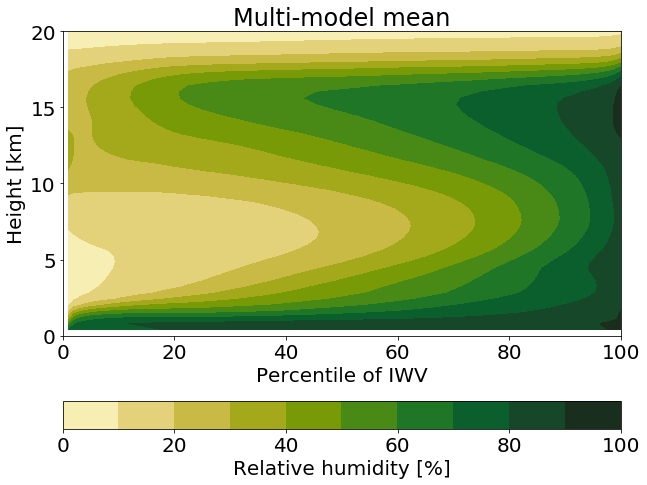

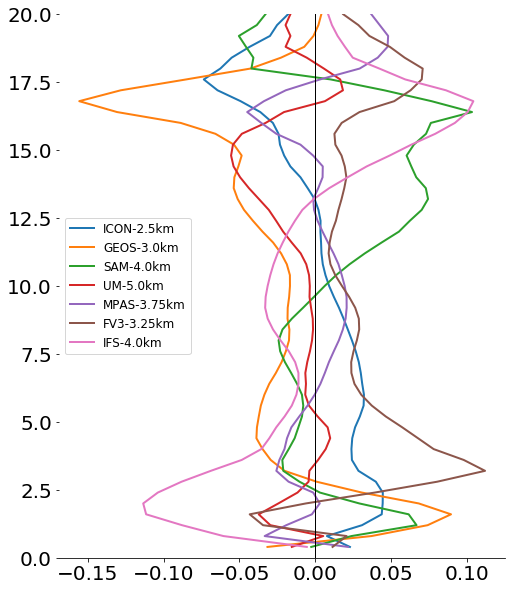

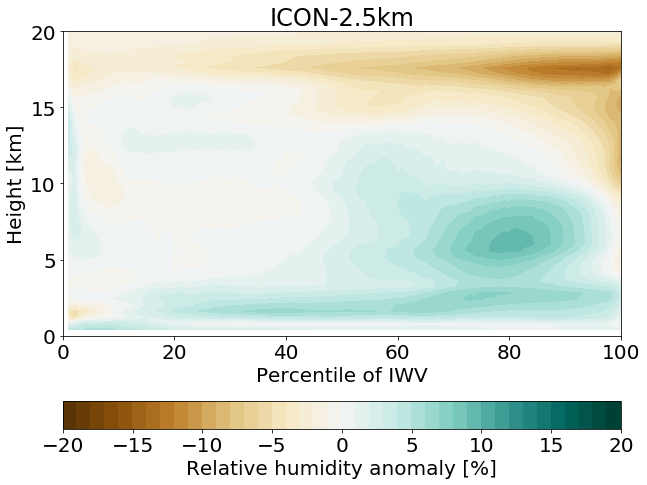

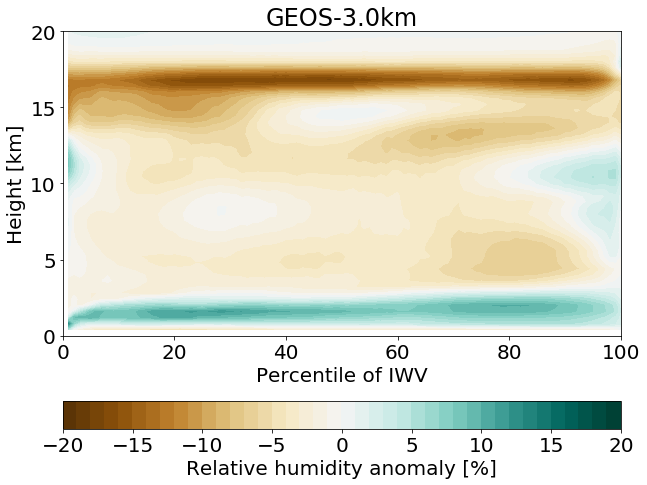

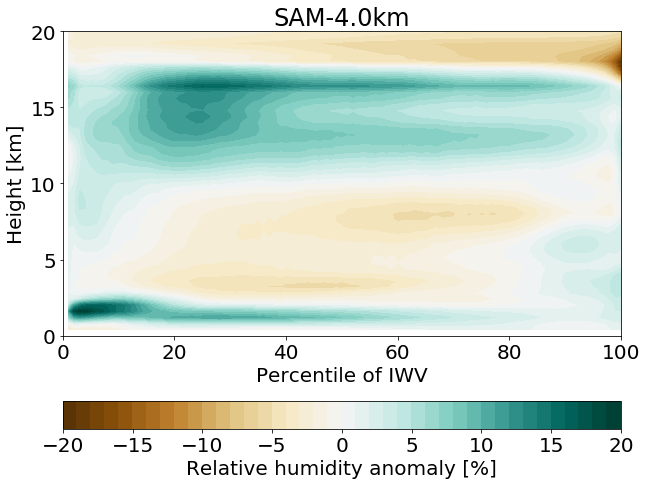

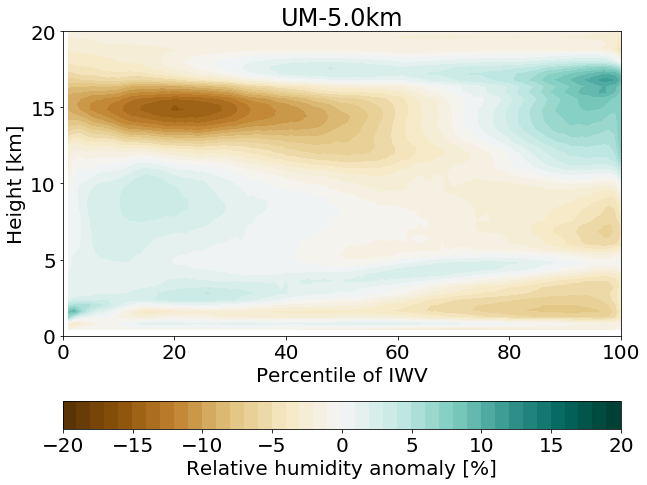

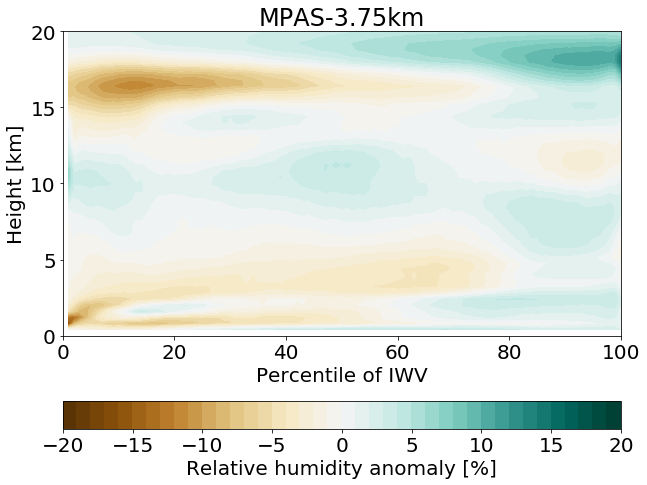

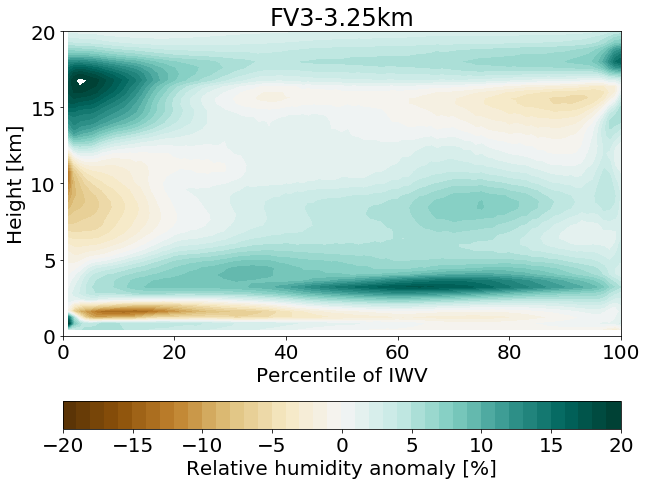

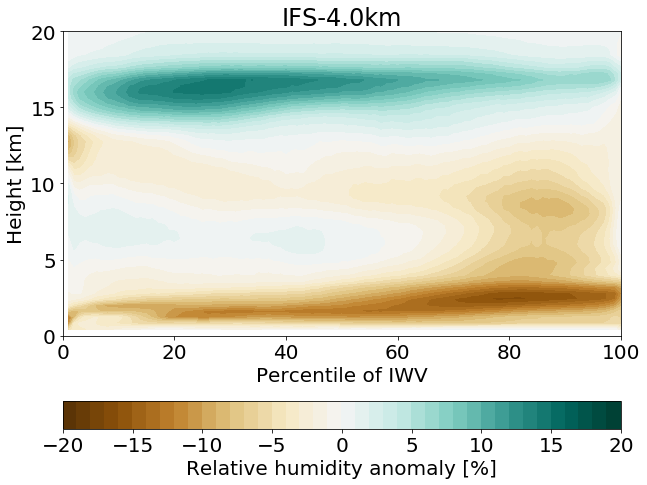

In [22]:
array_detrended = detrend(model_array['RH'], axis=0, type='constant')
array_detrended_qv = detrend(model_array['QV'], axis=0, type='constant')
array_mean = np.mean(model_array['RH'], axis=0)
array_mean_qv = np.mean(model_array['QV'], axis=0)
x_lims = [0, 100]
y_lims = [0, 20]
contours = np.arange(-20, 21, 1)
fig, ax = plt.subplots(figsize=(10, 8))
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, array_mean * 1e2, 10,\
                                  x_lims, y_lims, 'Percentile of IWV', y_label, 'Relative humidity [%]',\
                                  cmap='speed', vmin=0, vmax=100)
ax.set_title('Multi-model mean')
fig2, ax2 = plt.subplots(figsize=(8, 10))
for i, m in enumerate(models_variability):
    ax2.plot(np.mean(array_detrended[i], axis=1), h * 1e-3, lw=2, label=m)
    ax2.plot([0, 0], [0, 20], color='k', lw=1)
    seaborn.despine(ax=ax2, top=True, left=True, right=True)
    fig, ax = plt.subplots(figsize=(10, 8))
    plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, array_detrended[i] * 1e2, contours,\
                                  x_lims, y_lims, 'Percentile of IWV', y_label, 'Relative humidity anomaly [%]',\
                                  cmap='BrBG', vmin=-20, vmax=20)
    ax.set_title(m)
ax2.set_ylim(0, 20)
ax2.legend(fontsize=12)

## variability among several models

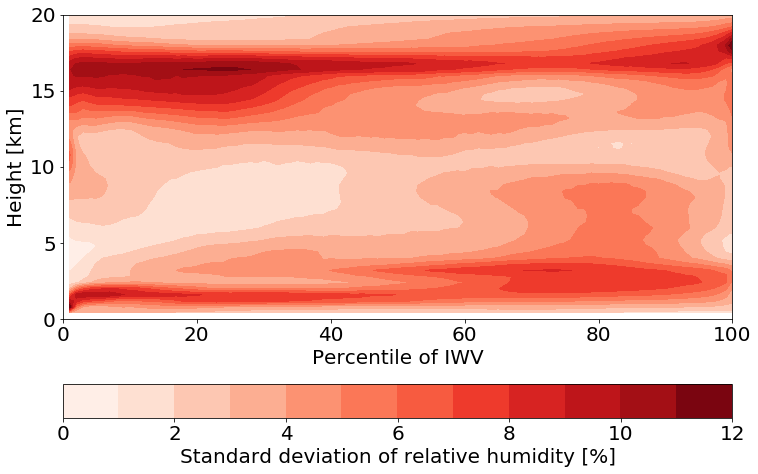

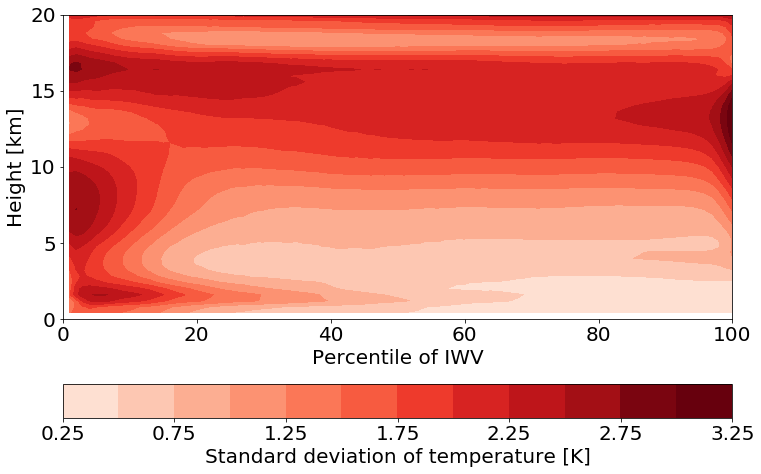

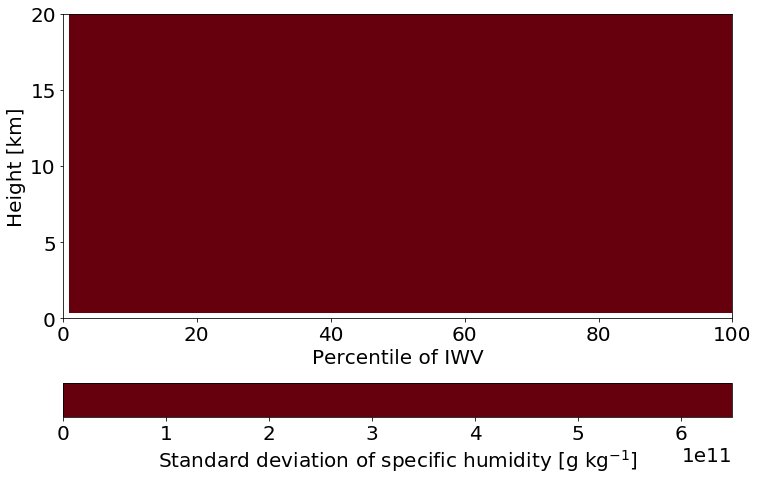

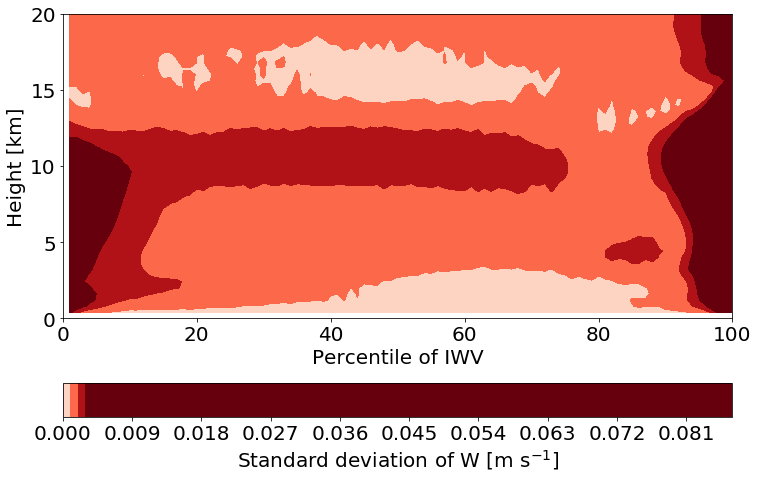

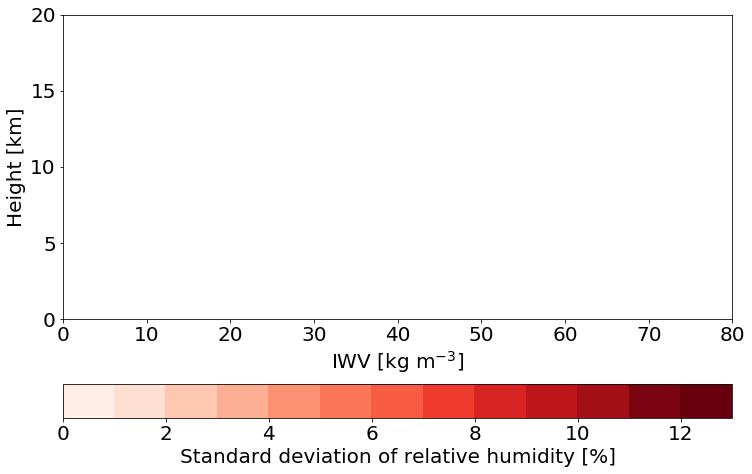

In [23]:
plt.rcParams.update({'font.size': 20})
y_lims = [0, 20]
y_label = 'Height [km]'
fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, np.std(model_array['RH'] * 1e2, axis=0), 12,\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Standard deviation of relative humidity [%]',\
                                  cmap='Reds', vmin=0, vmax=12)
fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, np.std(model_array['TEMP'], axis=0), 12,\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Standard deviation of temperature [K]',\
                                  cmap='Reds', vmin=0, vmax=3)
fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, np.std(model_array['QV'] * 1e6, axis=0) / model_array['QV'][0] * 1e6, 12,\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Standard deviation of specific humidity [g kg$^{-1}$]',\
                                  cmap='Reds', vmin=0, vmax=950)
fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, perc_values, h * 1e-3, np.std(model_array['W'], axis=0), 100,\
                                  [0, 100], y_lims, 'Percentile of IWV', y_label, 'Standard deviation of W [m s$^{-1}$]',\
                                  cmap='Reds', vmin=0, vmax=0.003)

fig, ax = plt.subplots(figsize=(12, 8))
plots.moisture_space_contourf(fig, ax, bins, h, np.std(model_array_bins['RH'] * 1e2, axis=0), 12,\
                                  [0, 80], y_lims, 'IWV [kg m$^{-3}$]', y_label, 'Standard deviation of relative humidity [%]',\
                                  cmap='Reds', vmin=0, vmax=12)

## EOFs

### Fraction of variability explained by different EOFs

/work/um0878/sw/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'Fraction of variability explained by EOF')

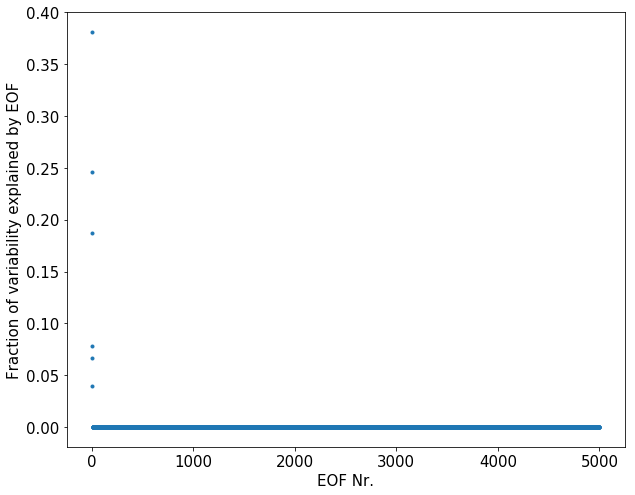

In [189]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(RH_EOF_frac, '.')
ax.set_xlabel('EOF Nr.')
ax.set_ylabel('Fraction of variability explained by EOF')

### EOFs 1-3

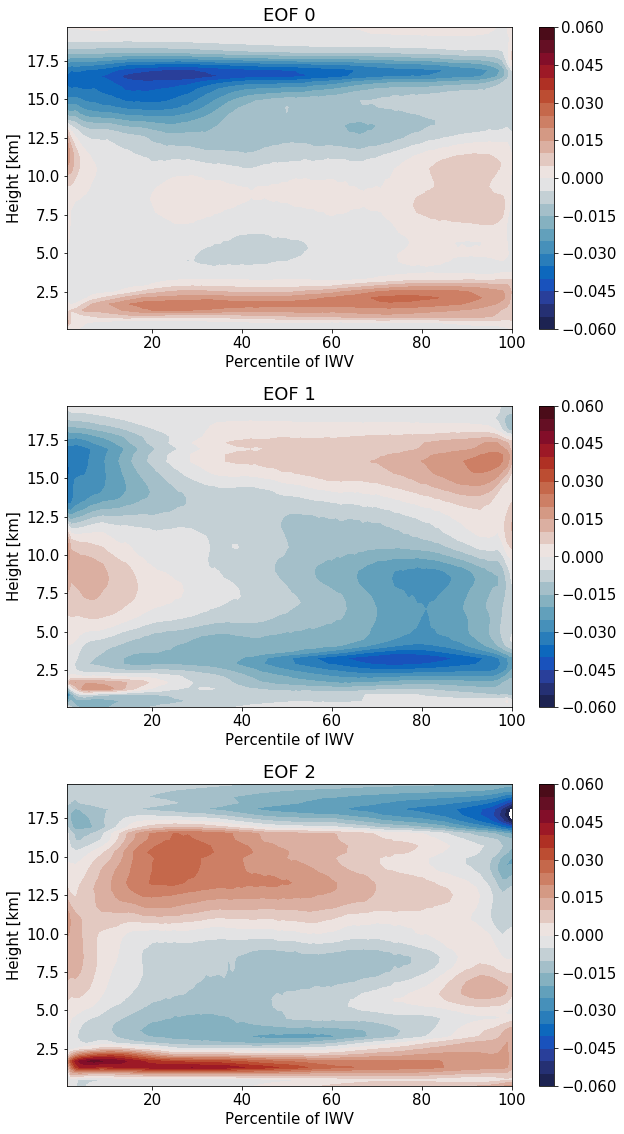

In [190]:
N = 3
fig, ax = plt.subplots(N, 1, figsize=(9, 16))
contours = np.arange(-0.06, 0.065, 0.005)
for i in range(N):    
    im = ax[i].contourf(perc_values, h * 1e-3, np.real(RH_EOFs[:, i].reshape((len(h), len(perc_values)))), contours, cmap='difference', vmin=-0.06, vmax=0.06)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_xlabel('Percentile of IWV')
    ax[i].set_ylabel('Height [km]')
    ax[i].set_title(f'EOF {i}')
plt.tight_layout()

### Expansion coefficients

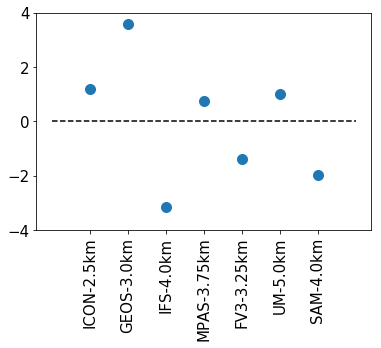

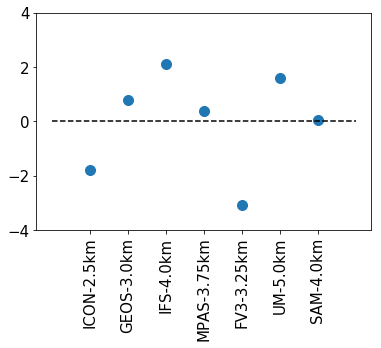

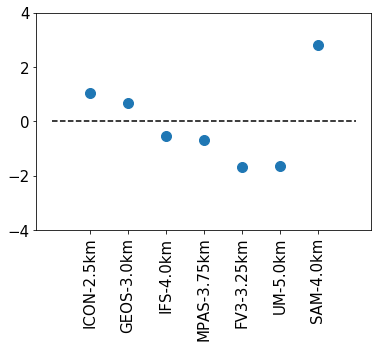

In [226]:
for i in range(N):
    fig, ax = plt.subplots()
    ax.plot(expansion_coeff[i], '.', markersize=20)
    ax.set_xticks(np.arange(0, 7))
    ax.set_xticklabels(models_variability, rotation=90)
    ax.plot([-1, 7], [0, 0], '--', color='k')
    ax.set_ylim(-4, 4)

In [206]:
expansion_coeff[1]

array([-1.78548175,  0.76272275,  2.09540598,  0.384208  , -3.08343372,
        1.5761635 ,  0.05041524])

## Groups of models

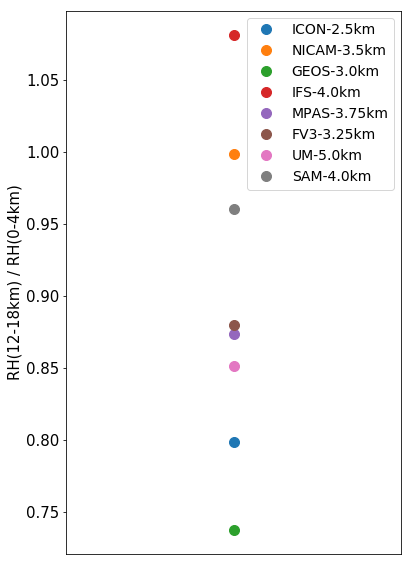

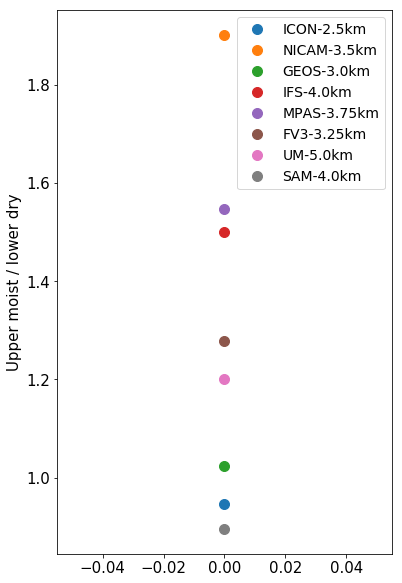

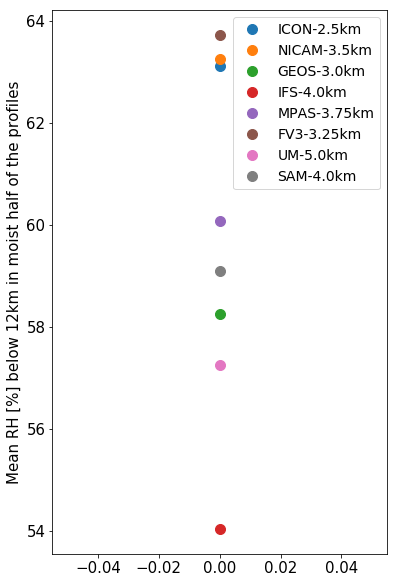

In [298]:
lower_ind = h <= 4000
lower_ind_2 = np.logical_and(h > 0, h < 12000)
upper_ind = np.logical_and(h > 12000, h < 18000)
tropo_ind = h <= 18000
mean_rh_lower = {}
mean_rh_upper = {}
for i, m in enumerate(exps):
    mean_rh = np.mean(perc_mean_interp[m]['RH'], axis=1)
    mean_rh_lower[m] = np.mean(mean_rh[lower_ind])
    mean_rh_upper[m] = np.mean(mean_rh[upper_ind]) #/ np.mean(mean_rh[tropo_ind])

    
fig, ax = plt.subplots(figsize=(6, 10))
for i, m in enumerate(exps):
    ax.plot([0], mean_rh_upper[m] / mean_rh_lower[m], '.', markersize=20, label=m)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('RH(12-18km) / RH(0-4km)')
ax.legend(fontsize=14)

fig, ax = plt.subplots(figsize=(6, 10))
uppermost_ind = np.logical_and(h > 16000, h < 20000)
lowermost_ind = h <= 3000
for i, m in enumerate(exps):
    mean_rh_moist_upper = np.nanmean(perc_mean_interp[m]['RH'][uppermost_ind, 95:])
    mean_rh_dry_lower = np.nanmean(perc_mean_interp[m]['RH'][lowermost_ind, :5])
    ax.plot([0], mean_rh_moist_upper/ mean_rh_dry_lower, '.', markersize=20, label=m)
ax.set_ylabel('Upper moist / lower dry')
ax.set_xlabel('')
ax.legend(fontsize=14)

fig, ax = plt.subplots(figsize=(6, 10))
for i, m in enumerate(exps):
    mean_rh_moist_upper = np.nanmean(perc_mean_interp[m]['RH'][upper_ind, 50:])
    mean_rh_moist_lower = np.nanmean(perc_mean_interp[m]['RH'][lower_ind_2, 50:])
    ax.plot([0], mean_rh_moist_lower * 1e2, '.', markersize=20, label=m)
ax.set_ylabel('Mean RH [%] below 12km in moist half of the profiles')
ax.set_xlabel('')
ax.legend(fontsize=14)

## Streamfunction

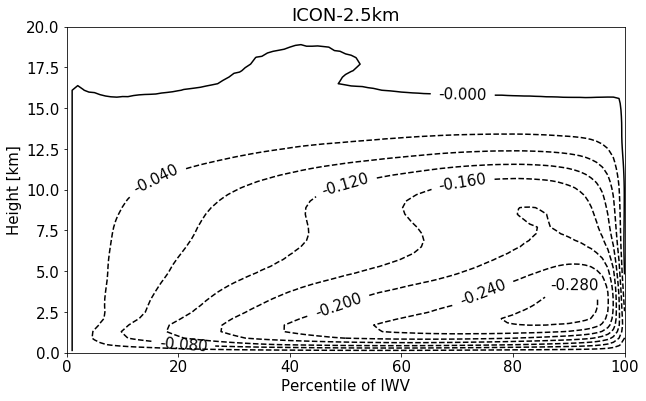

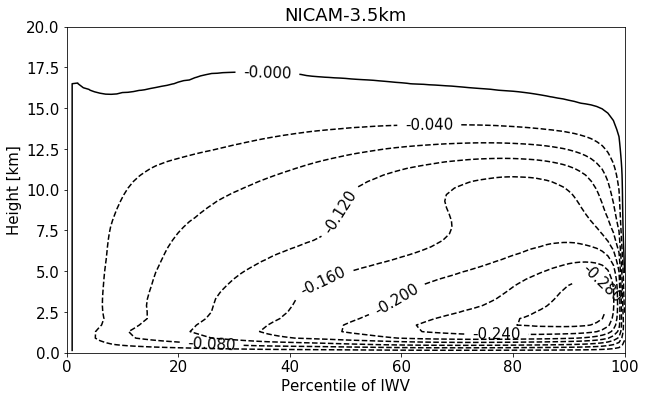

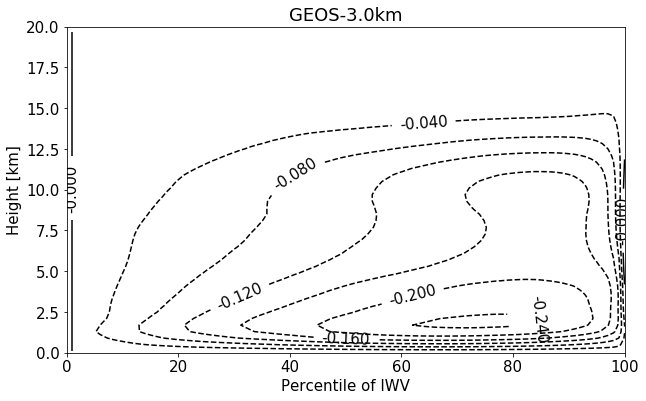

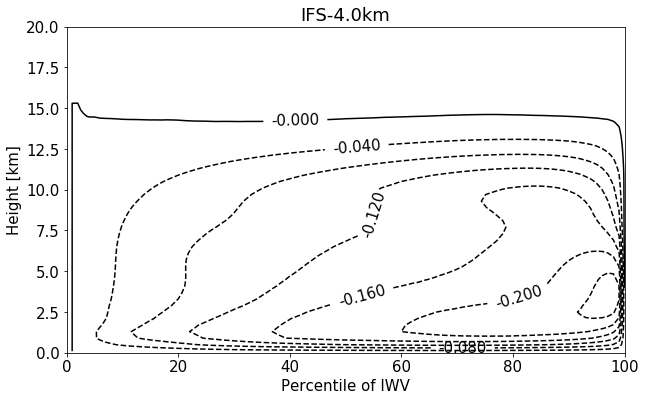

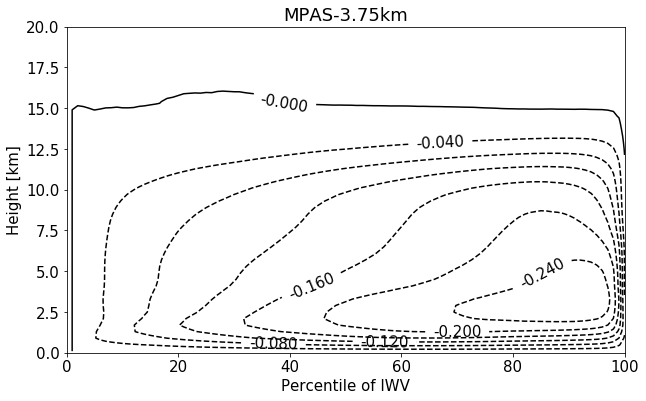

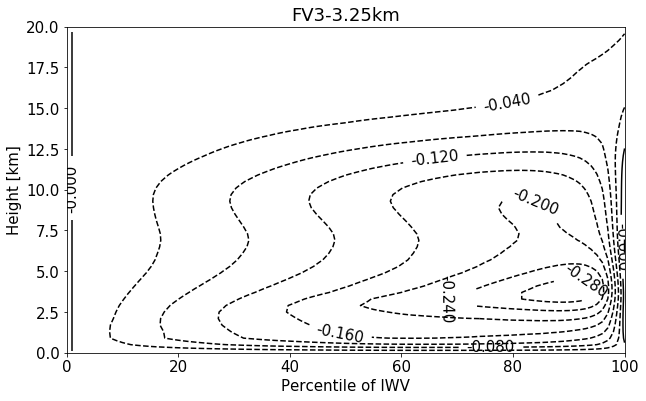

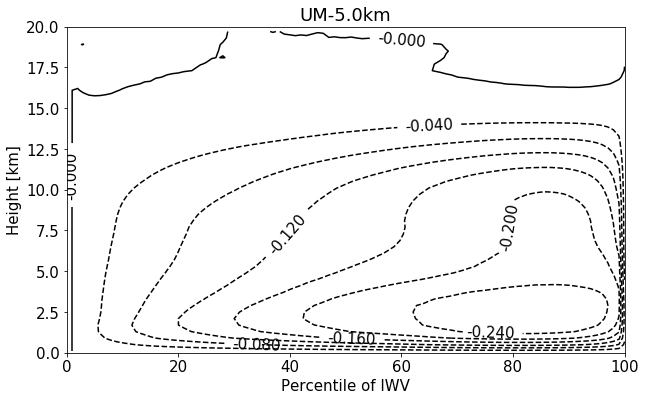

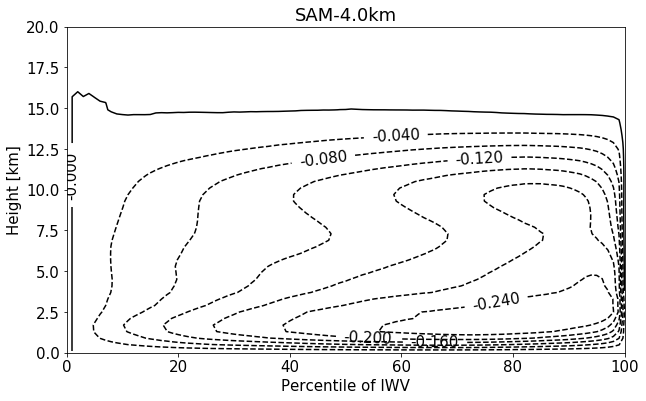

In [265]:
reload(plots)
x_lims = [0, 100]
y_lims = [0, 20]
x_label = 'Percentile of IWV'
y_label = 'Height [km]'
contours = np.arange(-0.4, 0.4, 0.04)
for m in exps:
    fig, ax = plt.subplots(figsize=(10, 6))
    cs = plots.moisture_space_contour(fig, ax, perc_values, h * 1e-3, streamfunction[m],\
                                 contours, x_lims, y_lims, x_label, y_label, 'k')
    ax.clabel(cs)
    ax.set_title(m)

In [286]:
groups = [
    ['FV3-3.25km', 'ICON-2.5km', 'NICAM-3.5km'],
    ['UM-5.0km', 'MPAS-3.75km', 'GEOS-3.0km', 'SAM-4.0km', 'IFS-4.0km']
]
mean_streamfunctions = []
for group in groups:
    num_models = len(group)
    sum_streamfunction = np.zeros((len(h), num_percs))
    for m in group:
        sum_streamfunction += streamfunction[m]
    mean_streamfunctions.append(sum_streamfunction / num_models)
        

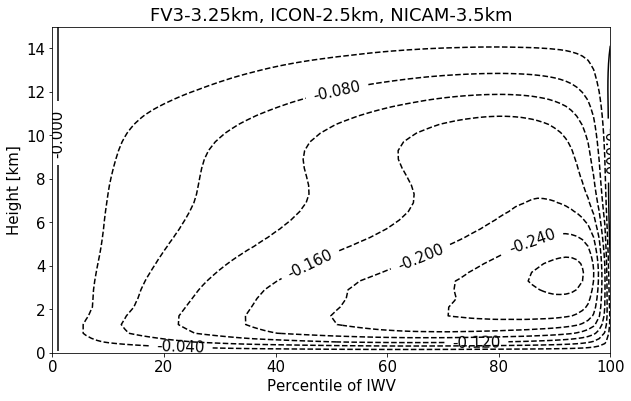

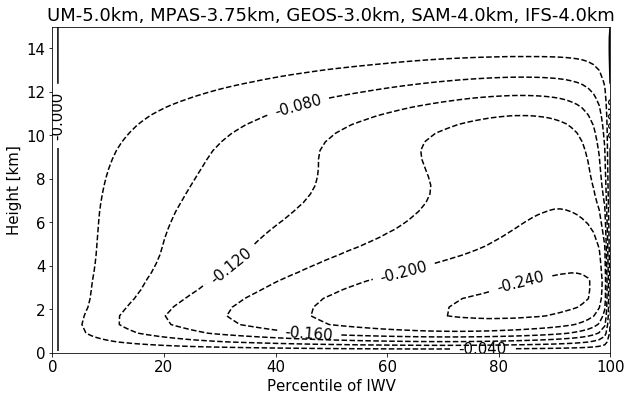

In [287]:
x_lims = [0, 100]
y_lims = [0, 15]
x_label = 'Percentile of IWV'
y_label = 'Height [km]'
for g in range(len(groups)):
    fig, ax = plt.subplots(figsize=(10, 6))
    cs = plots.moisture_space_contour(fig, ax, perc_values, h * 1e-3, mean_streamfunctions[g],\
                                 contours, x_lims, y_lims, x_label, y_label, 'k')
    ax.clabel(cs)
    ax.set_title(', '.join(groups[g]))
    ax.set_xlim(0, 100)

## Vertical velocity

In [260]:
reload(utils)
layer_bnds = [4500, 5500]
layer_mean_w = {}
frac_up = {}
mean_up = {}
for m in exps:
    print(m)
    layer_mean_w[m] = utils.get_mean_quantity_in_layer(perc_mean_interp[m]['W'], h, layer_bnds)
    percs_up = layer_mean_w[m] > 0
    frac_up[m] = np.sum(percs_up) / num_percs
    mean_up[m] = np.mean(layer_mean_w[m][percs_up])
    print(mean_up[m] )

ICON-2.5km
0.04527671900339439
NICAM-3.5km
0.06265464334713487
GEOS-3.0km
0.017901436515802976
IFS-4.0km
0.11484044539539752
MPAS-3.75km
0.03804058049795835
FV3-3.25km
0.04632164375557754
UM-5.0km
0.026824504905013126
SAM-4.0km
0.05638533073712477


(80, 100)

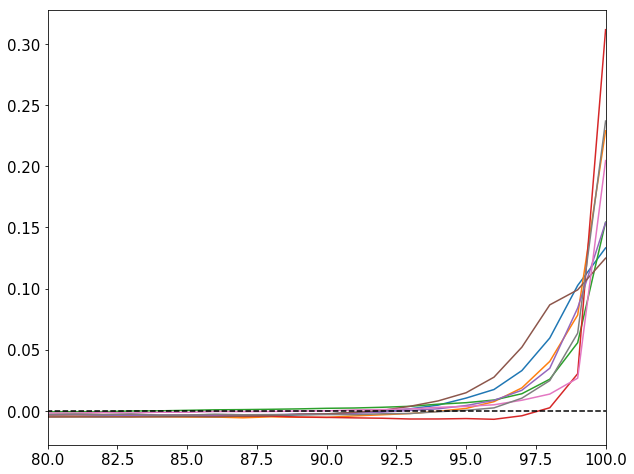

In [257]:
fig, ax = plt.subplots(figsize=(10, 8))
for m in exps:
    ax.plot(perc_values, layer_mean_w[m])
ax.plot([0, 100], [0, 0], '--', color='k')
ax.set_xlim(80, 100)
#ax.set_ylim(-0.02, 0.02)

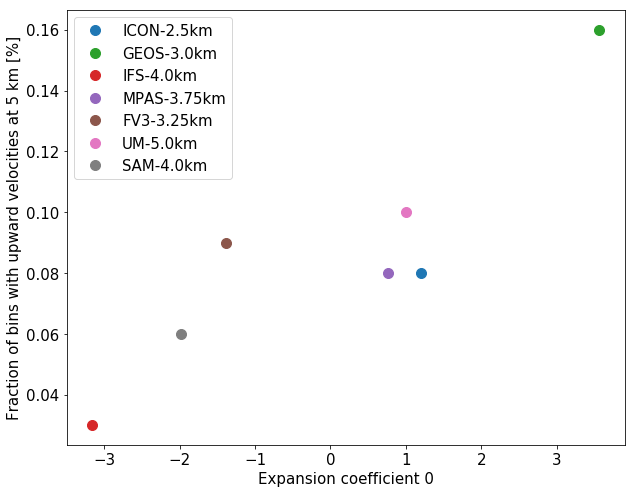

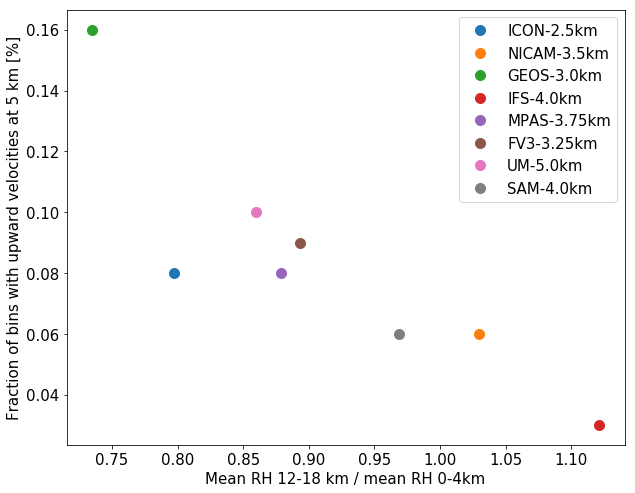

In [282]:
colors = {m: f'C{i}' for i, m in enumerate(exps)}
fig, ax = plt.subplots(figsize=(10, 8))
for i, m in enumerate(models_variability):
    ax.plot(expansion_coeff[0][i], frac_up[m], '.', markersize=20, color=colors[m], label=m)
    #ax.plot(expansion_coeff[0][i], mean_rh_upper[m] / mean_rh_lower[m], '.', markersize=20, color=colors[m], label=m)
#ax.set_ylim(0.01, 0.07)
ax.set_ylabel('Fraction of bins with upward velocities at 5 km [%]')
#ax.set_xlabel('Mean RH 12-18 km / mean RH 0-12km')
ax.set_xlabel('Expansion coefficient 0')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 8))
for i, m in enumerate(exps):
    ax.plot(mean_rh_upper[m] / mean_rh_lower[m], frac_up[m], '.', markersize=20, color=colors[m], label=m)
#ax.set_ylim(0.01, 0.07)
#ax.set_xlim(0, 20)
ax.set_ylabel('Fraction of bins with upward velocities at 5 km [%]')
ax.set_xlabel('Mean RH 12-18 km / mean RH 0-4km')
ax.legend()

# fig, ax = plt.subplots(figsize=(10, 8))
# for i, m in enumerate(exps):
#     ax.plot(frac_up[m] * 1e2, mean_up[m], '.', markersize=20, color=colors[m], label=m)
# #ax.set_ylim(0.01, 0.07)
# ax.set_xlim(0, 20)
# ax.set_xlabel('Fraction of bins with upward velocities at 5 km [%]')
# ax.set_ylabel('Mean upward velocity at 5 km altitude [m/s]')
# ax.legend()

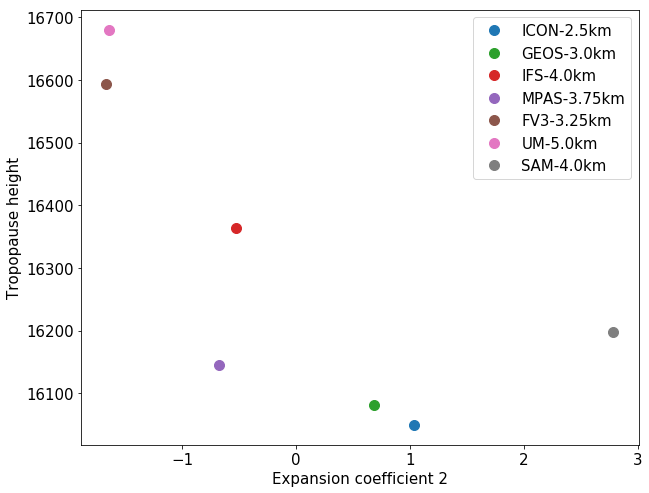

In [281]:
fig, ax = plt.subplots(figsize=(10, 8))
for i, m in enumerate(models_variability):
    ax.plot(expansion_coeff[2][i], np.mean(perc_mean[m]['H_tropo'][70:]), '.', markersize=20, color=colors[m], label=m)
#ax.set_ylim(0.01, 0.07)
#ax.set_xlim(0, 20)
ax.set_ylabel('Tropopause height')
ax.set_xlabel('Expansion coefficient 2')
ax.legend()

## Profiles in percentiles

### Temperature

Text(0,0.5,'Height [km]')

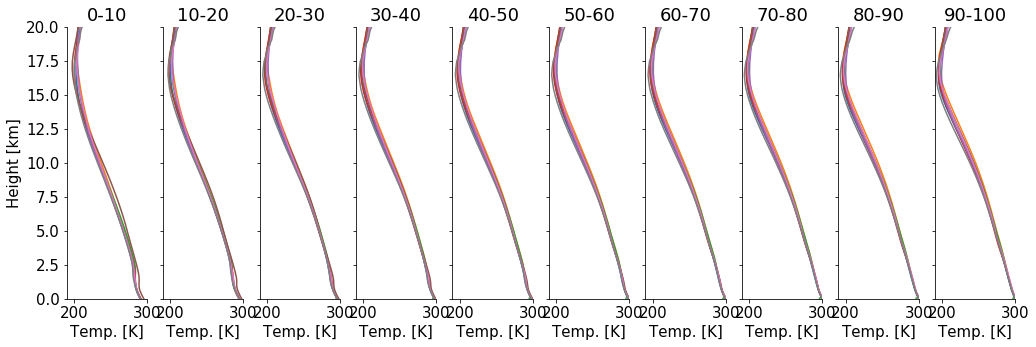

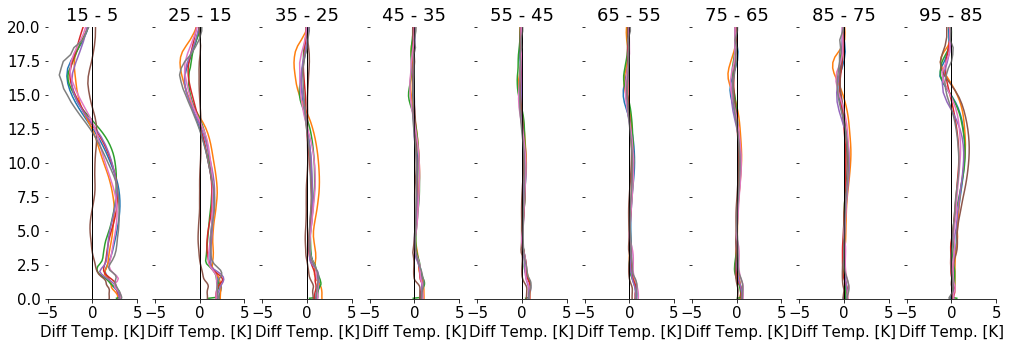

In [168]:
plt.rcParams.update({'font.size': 15})
start = 5
end = 95
step = 10
fig, ax = plt.subplots(1, len(range(start, end+1, step)), figsize=(17, 5), sharey=True)
fig2, ax2 = plt.subplots(1, len(range(start, end+1, step))-1, figsize=(17, 5), sharey=True)
for m in exps:
    for i, p in enumerate(np.arange(start, end+1, step)):
        temp_mean = np.mean(perc_mean[m]['TEMP'][p-step//2:p+step//2], axis=0)
        ax[i].plot(temp_mean, height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_mean[m]['RH'][p] * 1e2 - perc_std[m]['RH'][p] * 1e2, perc_mean[m]['RH'][p] * 1e2 + perc_std[m]['RH'][p] * 1e2, alpha=0.3)
        #ax[i].fill_betweenx(height[m] * 1e-3, (perc_mean[m]['TEMP'][p] - perc_std[m]['TEMP'][p]), (perc_mean[m]['TEMP'][p] + perc_std[m]['TEMP'][p]), alpha=0.3)
        ax[i].set_xlim(190, 300)
        ax[i].set_xlabel('Temp. [K]')
        ax[i].set_title(f'{p-step//2}-{p+step//2}')
        seaborn.despine(top=True, right=True, ax=ax[i])    
        
    for i, p in enumerate(np.arange(5, 100-step, step)):
        ax2[i].plot(np.mean(perc_mean[m]['TEMP'][p+step-step//2:p+step+step//2], axis=0) - np.mean(perc_mean[m]['TEMP'][p-step//2:p+step//2], axis=0), height[m] * 1e-3, label=m)
        ax2[i].set_xlim(-5, 5)
        
        ax2[i].set_title(f'{p+step} - {p}')
        ax2[i].set_xlabel('Diff Temp. [K]')
        seaborn.despine(top=True, right=True, left=True, ax=ax2[i])
        ax2[i].plot([0, 0], [0, 20], color='k', lw=0.5)
        
ax2[0].set_ylim(0, 20)        
ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')

### RH

Text(0,0.5,'Temperature K')

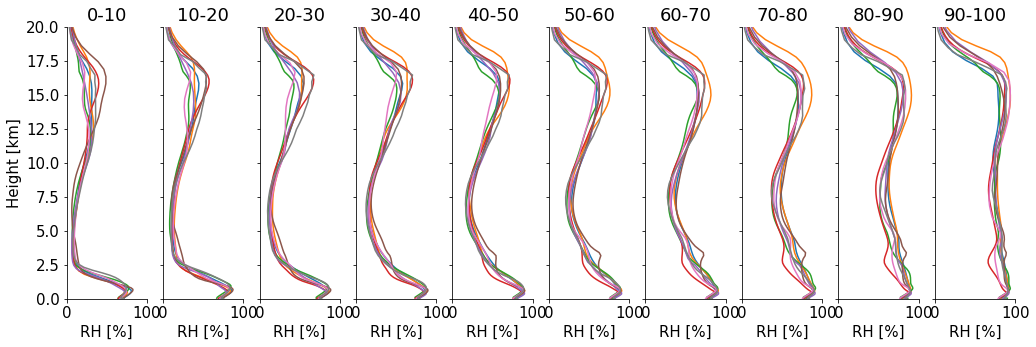

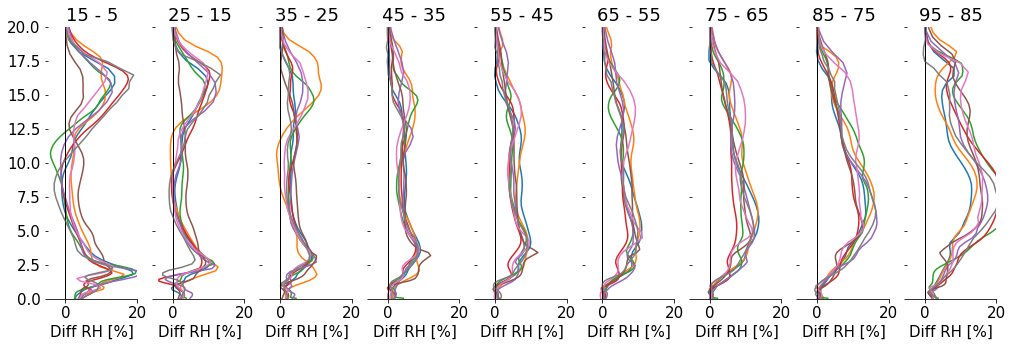

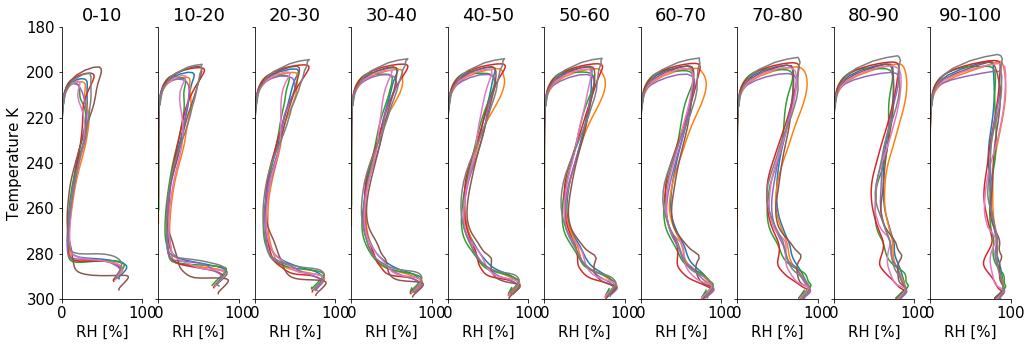

In [164]:
start = 5
end = 95
step = 10
fig, ax = plt.subplots(1, len(range(start, end+1, step)), figsize=(17, 5), sharey=True)
fig2, ax2 = plt.subplots(1, len(range(start, end+1, step))-1, figsize=(17, 5), sharey=True)
for m in exps:
    for i, p in enumerate(np.arange(start, end+1, step)):
        ax[i].plot(np.mean(perc_mean[m]['RH'][p-step//2:p+step//2], axis=0) * 1e2, height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_mean[m]['RH'][p] * 1e2 - perc_std[m]['RH'][p] * 1e2, perc_mean[m]['RH'][p] * 1e2 + perc_std[m]['RH'][p] * 1e2, alpha=0.3)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_quart25[m]['RH'][p] * 1e2, perc_quart75[m]['RH'][p] * 1e2, alpha=0.3)
        ax[i].set_xlim(0, 100)
        ax[i].set_xlabel('RH [%]')
        ax[i].set_title(f'{p-step//2}-{p+step//2}')
        seaborn.despine(top=True, right=True, ax=ax[i])
        
    for i, p in enumerate(np.arange(5, 100-step, step)):
        ax2[i].plot(np.mean(perc_mean[m]['RH'][p+step-step//2:p+step+step//2], axis=0) * 1e2 - np.mean(perc_mean[m]['RH'][p-step//2:p+step//2], axis=0) * 1e2, height[m] * 1e-3, label=m)
        ax2[i].set_xlim(-5, 20)
        
        ax2[i].set_title(f'{p+step} - {p}')
        ax2[i].set_xlabel('Diff RH [%]')
        seaborn.despine(top=True, right=True, left=True, ax=ax2[i])
        ax2[i].plot([0, 0], [0, 20], color='k', lw=0.5)

ax2[0].set_ylim(0, 20)
ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')

fig, ax = plt.subplots(1, 10, figsize=(17, 5), sharey=True)
for m in exps:
    for i, p in enumerate(np.arange(start, end+1, step)):
        ax[i].plot(np.mean(perc_mean[m]['RH'][p-step//2:p+step//2], axis=0) * 1e2, perc_mean[m]['TEMP'][p], label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_mean[m]['RH'][p] * 1e2 - perc_std[m]['RH'][p] * 1e2, perc_mean[m]['RH'][p] * 1e2 + perc_std[m]['RH'][p] * 1e2, alpha=0.3)
        #ax[i].fill_betweenx(perc_mean[m]['TEMP'][p], perc_quart25[m]['RH'][p] * 1e2, perc_quart75[m]['RH'][p] * 1e2, alpha=0.3)
        ax[i].set_xlim(0, 100)
        ax[i].set_xlabel('RH [%]')
        ax[i].set_title(f'{p-step//2}-{p+step//2}')
        seaborn.despine(top=True, right=True, ax=ax[i])

ax[0].set_ylim(300, 180)
ax[0].set_ylabel('Temperature K')

### Cloud ice content

Text(0,0.5,'Height [km]')

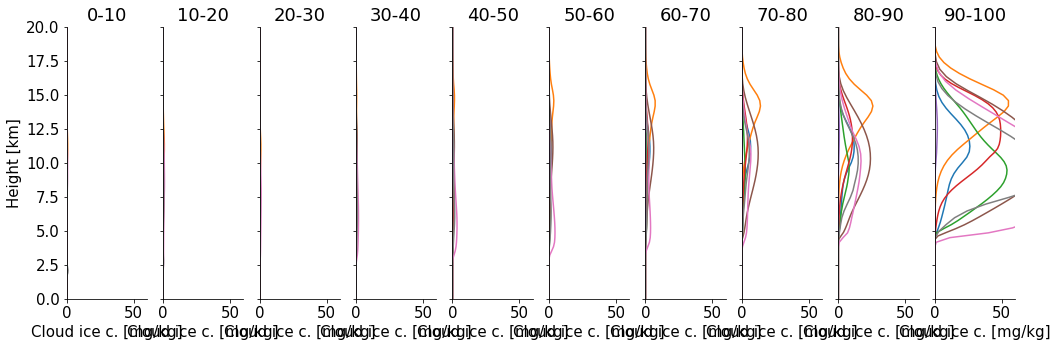

In [33]:
start = 5
end = 95
step = 10
fig, ax = plt.subplots(1, len(range(start, end+1, step)), figsize=(17, 5), sharey=True)
for m in exps:
    for i, p in enumerate(np.arange(start, end+1, step)):
        ax[i].plot(np.mean(perc_mean[m]['QI'][p-step//2:p+step//2], axis=0) * 1e6, height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_mean[m]['RH'][p] * 1e2 - perc_std[m]['RH'][p] * 1e2, perc_mean[m]['RH'][p] * 1e2 + perc_std[m]['RH'][p] * 1e2, alpha=0.3)
        #ax[i].fill_betweenx(height[m] * 1e-3, (perc_mean[m]['QI'][p] - perc_std[m]['QI'][p]) * 1e6, (perc_mean[m]['QI'][p] + perc_std[m]['QI'][p]) * 1e6, alpha=0.3)
        ax[i].set_xlim(0, 60)
        ax[i].set_xlabel('Cloud ice c. [mg/kg]')
        ax[i].set_title(f'{p-step//2}-{p+step//2}')
        seaborn.despine(top=True, right=True, ax=ax[i])

ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')

### Cloud water content

Text(0,0.5,'Height [km]')

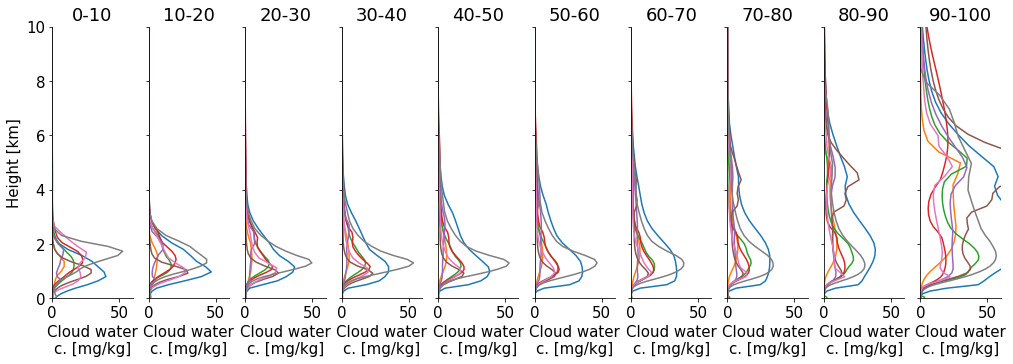

In [35]:
start = 5
end = 95
step = 10
fig, ax = plt.subplots(1, len(range(start, end+1, step)), figsize=(17, 5), sharey=True)
for m in exps:
    for i, p in enumerate(np.arange(start, end+1, step)):
        ax[i].plot(np.mean(perc_mean[m]['QC'][p-step//2:p+step//2], axis=0) * 1e6, height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_mean[m]['RH'][p] * 1e2 - perc_std[m]['RH'][p] * 1e2, perc_mean[m]['RH'][p] * 1e2 + perc_std[m]['RH'][p] * 1e2, alpha=0.3)
        #ax[i].fill_betweenx(height[m] * 1e-3, (perc_mean[m]['QI'][p] - perc_std[m]['QI'][p]) * 1e6, (perc_mean[m]['QI'][p] + perc_std[m]['QI'][p]) * 1e6, alpha=0.3)
        ax[i].set_xlim(0, 60)
        ax[i].set_xlabel('Cloud water\nc. [mg/kg]')
        ax[i].set_title(f'{p-step//2}-{p+step//2}')
        seaborn.despine(top=True, right=True, ax=ax[i])

ax[0].set_ylim(0, 10)
ax[0].set_ylabel('Height [km]')

### QV

Text(0,0.5,'Height [km]')

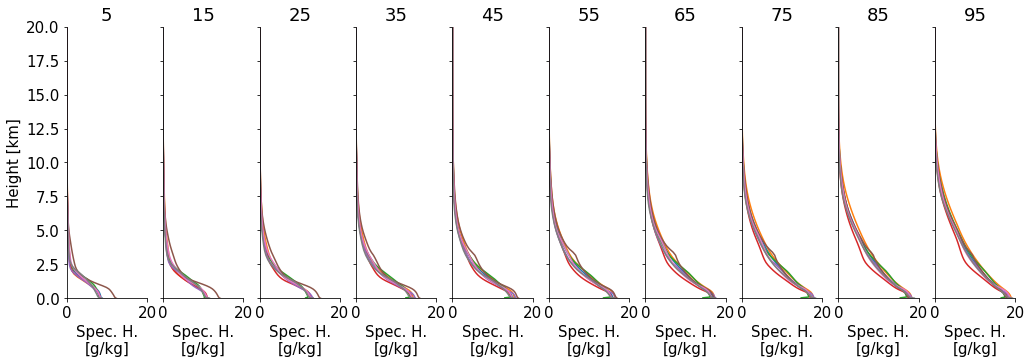

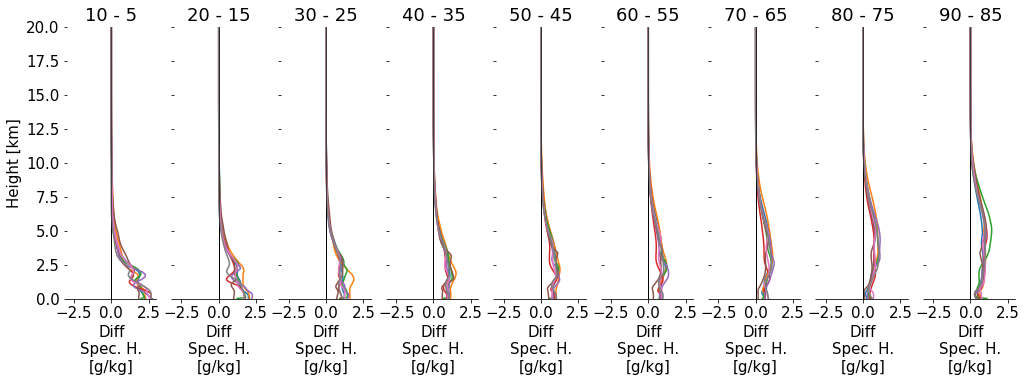

In [165]:
fig, ax = plt.subplots(1, 10, figsize=(17, 5), sharey=True)
fig2, ax2 = plt.subplots(1, 9, figsize=(17, 5), sharey=True)
step = 10
for m in exps:
    for i, p in enumerate(np.arange(5, 100, step)):
        ax[i].plot(perc_mean[m]['QV'][p] * 1e3, height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_mean[m]['RH'][p] * 1e2 - perc_std[m]['RH'][p] * 1e2, perc_mean[m]['RH'][p] * 1e2 + perc_std[m]['RH'][p] * 1e2, alpha=0.3)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_quart25[m]['QV'][p] * 1e3, perc_quart75[m]['QV'][p] * 1e3, alpha=0.3)
        ax[i].set_xlim(0, 20)
        ax[i].set_xlabel('Spec. H.\n[g/kg]')
        ax[i].set_title(p)
        seaborn.despine(top=True, right=True, ax=ax[i])
        
    for i, p in enumerate(np.arange(5, 100-step, step)):
        ax2[i].plot(perc_mean[m]['QV'][p+step] * 1e3 - perc_mean[m]['QV'][p] * 1e3, height[m] * 1e-3, label=m)
        ax2[i].set_xlim(-3, 3)
        
        ax2[i].set_title(f'{p+5} - {p}')
        ax2[i].set_xlabel('Diff\nSpec. H.\n[g/kg]')
        seaborn.despine(top=True, right=True, left=True, ax=ax2[i])
        ax2[i].plot([0, 0], [0, 20], color='k', lw=0.5)

ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')
ax2[0].set_ylim(0, 20)
ax2[0].set_ylabel('Height [km]')

#vmr = typhon.physics.specific_humidity2vmr(specific_humidity)
#rho = typhon.physics.thermodynamics.density(pressure, temperature, R=R_v)  


### VMR and water vapour density (used to calculate IWV)

Text(0,0.5,'Height [km]')

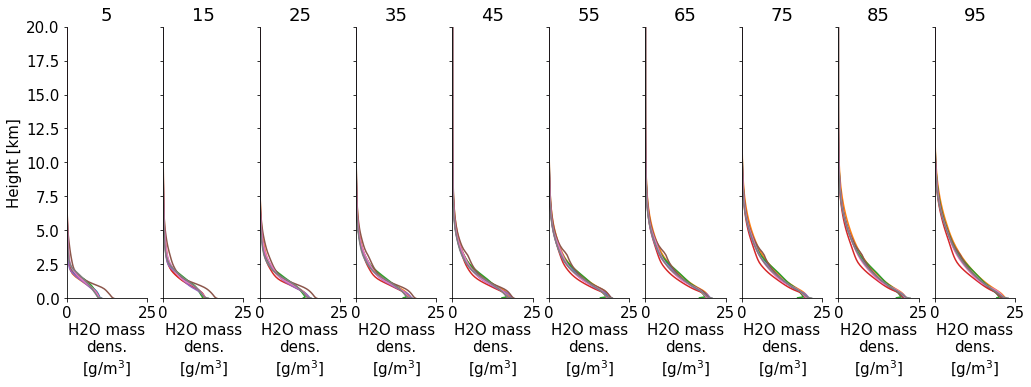

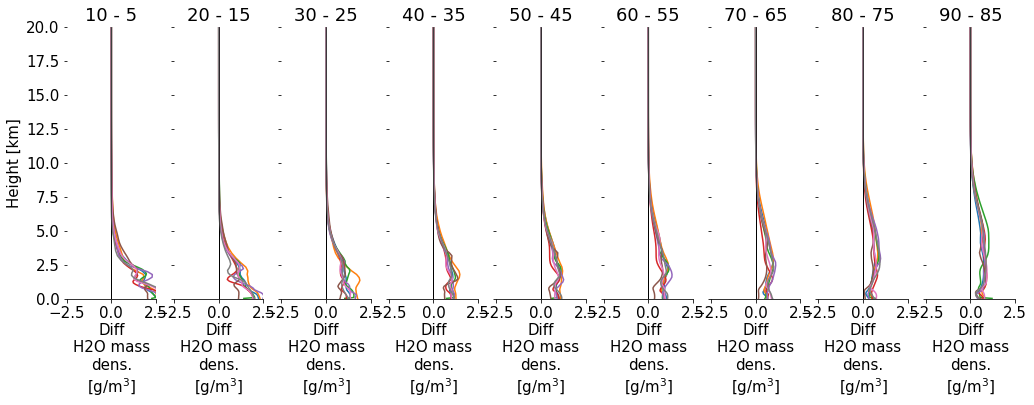

In [37]:
fig, ax = plt.subplots(1, 10, figsize=(17, 5), sharey=True)
fig2, ax2 = plt.subplots(1, 9, figsize=(17, 5), sharey=True)
step = 10
reload(utils)
for m in exps:
    for i, p in enumerate(np.arange(5, 100, step)):
        #ax[i].plot(perc_mean[m]['QV'][p] * 1e3, height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_mean[m]['RH'][p] * 1e2 - perc_std[m]['RH'][p] * 1e2, perc_mean[m]['RH'][p] * 1e2 + perc_std[m]['RH'][p] * 1e2, alpha=0.3)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_quart25[m]['QV'][p] * 1e3, perc_quart75[m]['QV'][p] * 1e3, alpha=0.3)
        vmr = typhon.physics.specific_humidity2vmr(perc_mean[m]['QV'][p])
        rho = typhon.physics.thermodynamics.density(perc_mean[m]['PRES'][p], perc_mean[m]['TEMP'][p], R=typhon.physics.constants.gas_constant_water_vapor)  
        ax[i].plot(vmr * rho * 1e3, height[m] * 1e-3, label=m)
        ax[i].set_xlim(0, 25)
        ax[i].set_xlabel('H2O mass\ndens.\n[g/m$^3$]')
        ax[i].set_title(p)
        seaborn.despine(top=True, right=True, ax=ax[i])
        
    for i, p in enumerate(np.arange(5, 100-step, step)):
        vmr = typhon.physics.specific_humidity2vmr(perc_mean[m]['QV'][p])
        rho = typhon.physics.thermodynamics.density(perc_mean[m]['PRES'][p], perc_mean[m]['TEMP'][p], R=typhon.physics.constants.gas_constant_water_vapor)  
        vmr_next = typhon.physics.specific_humidity2vmr(perc_mean[m]['QV'][p+step])
        rho_next = typhon.physics.thermodynamics.density(perc_mean[m]['PRES'][p+step], perc_mean[m]['TEMP'][p+step], R=typhon.physics.constants.gas_constant_water_vapor)  
        ax2[i].plot(vmr_next * rho_next * 1e3 - vmr * rho * 1e3, height[m] * 1e-3, label=m)
        ax2[i].set_xlim(-2.5, 2.5)
        
        ax2[i].set_title(f'{p+5} - {p}')
        ax2[i].set_xlabel('Diff\nH2O mass\ndens.\n[g/m$^3$]')
        seaborn.despine(top=True, right=True, left=True, ax=ax2[i])
        ax2[i].plot([0, 0], [0, 20], color='k', lw=0.5)

ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')
ax2[0].set_ylim(0, 20)
ax2[0].set_ylabel('Height [km]')

### W

Text(0,0.5,'Height [km]')

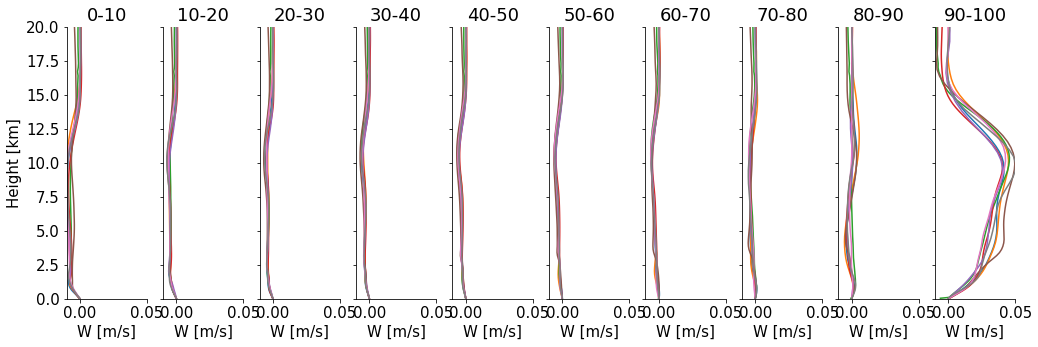

In [264]:
start = 5
end = 95
step = 10
fig, ax = plt.subplots(1, len(range(start, end+1, step)), figsize=(17, 5), sharey=True)
for m in exps:
    for i, p in enumerate(np.arange(start, end+1, step)):
        w = perc_mean[m]['W'][p-step//2:p+step//2]
        ax[i].plot(np.mean(w, axis=0), height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, perc_mean[m]['RH'][p] * 1e2 - perc_std[m]['RH'][p] * 1e2, perc_mean[m]['RH'][p] * 1e2 + perc_std[m]['RH'][p] * 1e2, alpha=0.3)
        #ax[i].fill_betweenx(height[m] * 1e-3, (perc_mean[m]['QI'][p] - perc_std[m]['QI'][p]) * 1e6, (perc_mean[m]['QI'][p] + perc_std[m]['QI'][p]) * 1e6, alpha=0.3)
        ax[i].set_xlim(-0.01, 0.05)
        ax[i].set_xlabel('W [m/s]')
        ax[i].set_title(f'{p-step//2}-{p+step//2}')
        seaborn.despine(top=True, right=True, ax=ax[i])

ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')

Text(0,0.5,'W at 5 km [m/s]')

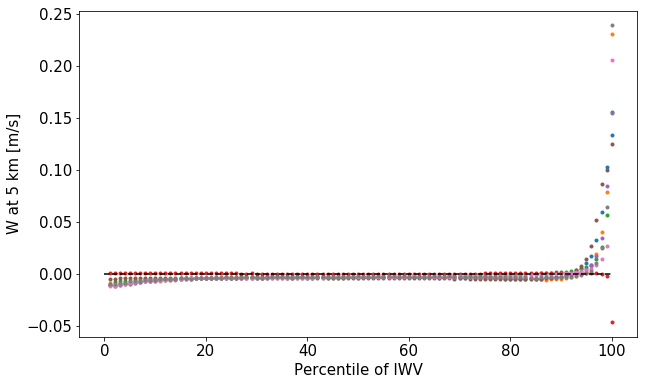

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
for m in exps:
    w_5km = utils.get_quantity_at_level(perc_mean_interp[m]['W'], h, 5 * 1e3)
    ax.plot(perc_values, w_5km, '.', lw=2, label=m)
ax.plot([0, 100], [0, 0], '--', color='k')
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('W at 5 km [m/s]')
#ax.set_ylim(-0.01, 0.05)
#ax.set_xlim(80, 102)


## Profiles in Bins

### RH

Text(0,0.5,'Height [km]')

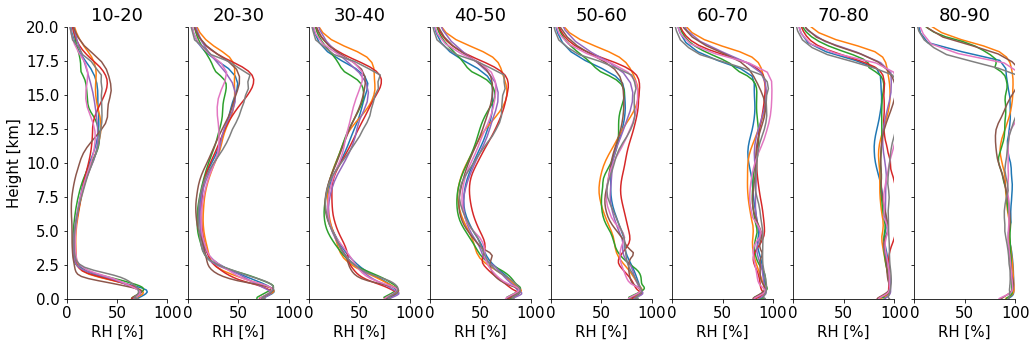

In [42]:
start = 15
end = 85
step = 10
fig, ax = plt.subplots(1, len(range(start, end+1, step)), figsize=(17, 5), sharey=True)
for m in exps:
    for i, b in enumerate(np.arange(start, end+1, step)):
        ax[i].plot(np.mean(bin_mean[m]['RH'][:, b-step//2:b+step//2], axis=1) * 1e2, height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, bin_mean[m]['RH'][:, b] * 1e2 - bin_std[m]['RH'][:, b] * 1e2, bin_mean[m]['RH'][:, b] * 1e2 + bin_std[m]['RH'][:, b] * 1e2, alpha=0.3)
        ax[i].set_xlim(0, 100)
        ax[i].set_xlabel('RH [%]')
        ax[i].set_title(f'{b-step//2}-{b+step//2}')
        seaborn.despine(top=True, right=True, ax=ax[i])

ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')

### W

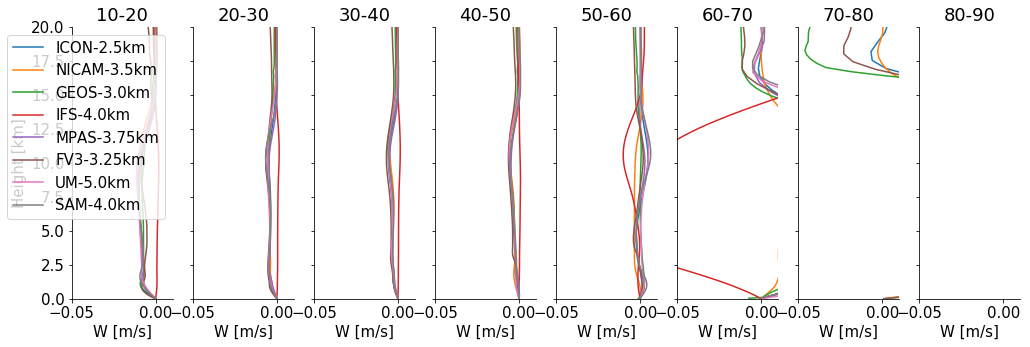

In [45]:
start = 15
end = 85
step = 10
fig, ax = plt.subplots(1, len(range(start, end+1, step)), figsize=(17, 5), sharey=True)
for m in exps:
    for i, b in enumerate(np.arange(start, end+1, step)):
        ax[i].plot(np.mean(bin_mean_plot[m]['W'][:, b-step//2:b+step//2], axis=1), height[m] * 1e-3, label=m)
        #ax[i].fill_betweenx(height[m] * 1e-3, bin_mean_plot[m]['W'][:, b] - bin_std_plot[m]['W'][:, b], bin_mean_plot[m]['W'][:, b] + bin_std_plot[m]['W'][:, b], alpha=0.3)
        ax[i].set_xlim(-0.05, 0.01)
        ax[i].set_xlabel('W [m/s]')
        ax[i].set_title(f'{b-step//2}-{b+step//2}')
        seaborn.despine(top=True, right=True, ax=ax[i])

ax[0].set_ylim(0, 20)
ax[0].set_ylabel('Height [km]')
ax[0].legend()

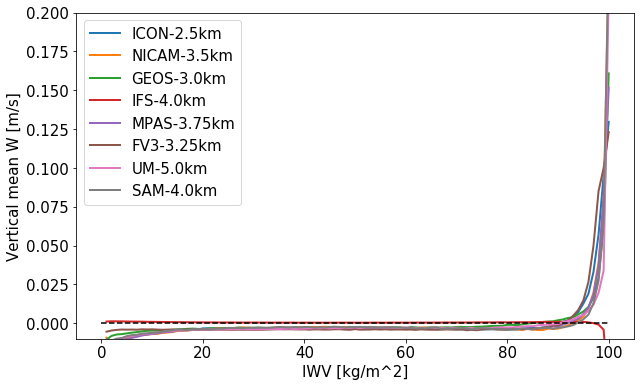

In [47]:
mean_pressure = {}
h_500hPa = {}
height_idx = {}
for m in exps:
    mean_pressure[m] = np.mean(perc_mean[m]['PRES'], axis=0)
    ph_interp = interp1d(mean_pressure[m], height[m])
    h_500hPa[m] = ph_interp(500e2)
    height_idx[m] = np.argmin(np.abs(height[m] - h_500hPa[m]))

fig, ax = plt.subplots(figsize=(10, 6))
for m in exps:
    #mean_w = atools.calc_vertical_mean(bin_mean[m]['W'], height[m])
    ax.plot(perc_values, perc_mean[m]['W'][:, height_idx[m]], lw=2, label=m)
ax.plot([0, 100], [0, 0], '--', color='k')
ax.set_xlabel('IWV [kg/m^2]')
ax.set_ylabel('Vertical mean W [m/s]')
ax.set_ylim(-0.01, 0.2)
ax.legend()

## In cloud ice content and cloud fraction

### Percentiles

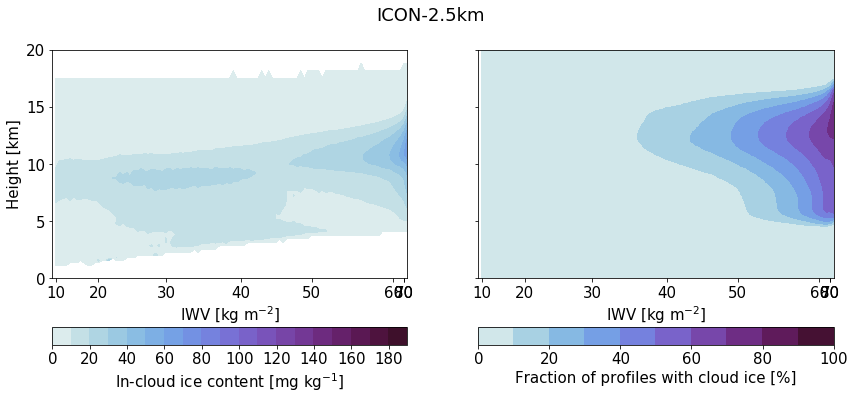

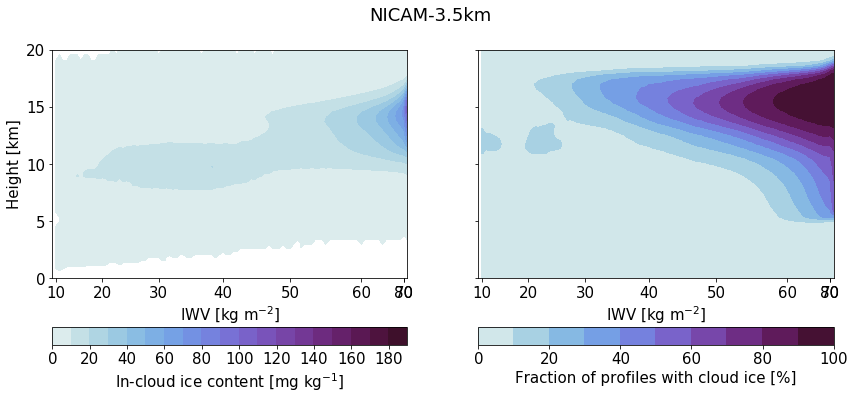

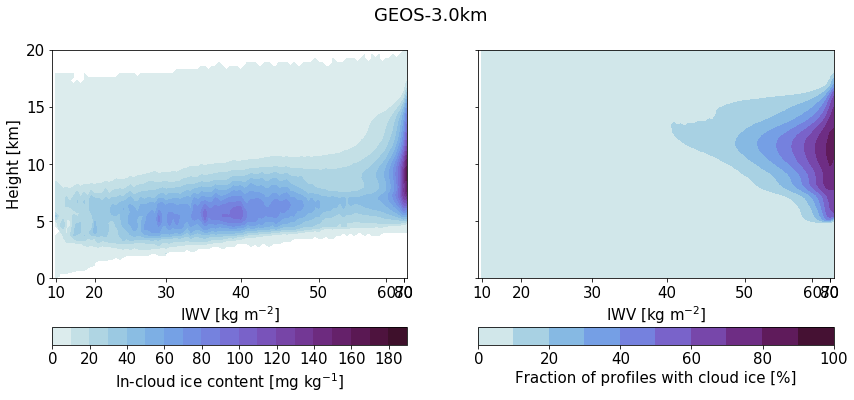

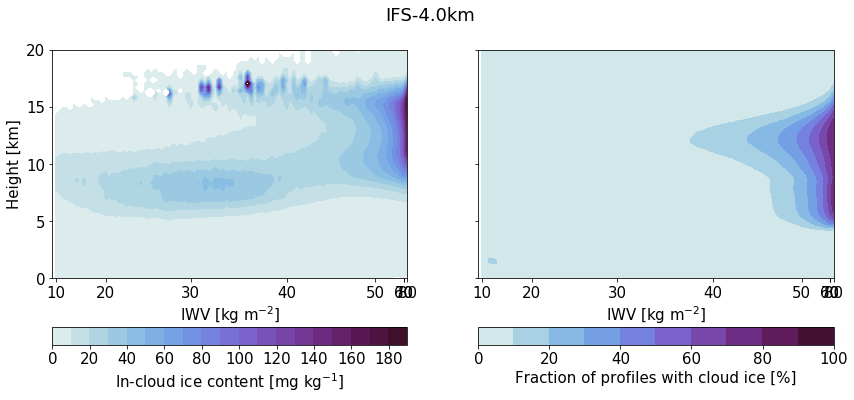

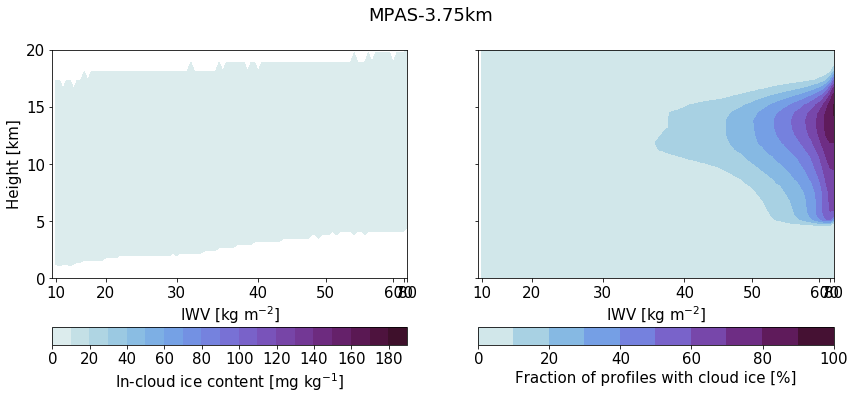

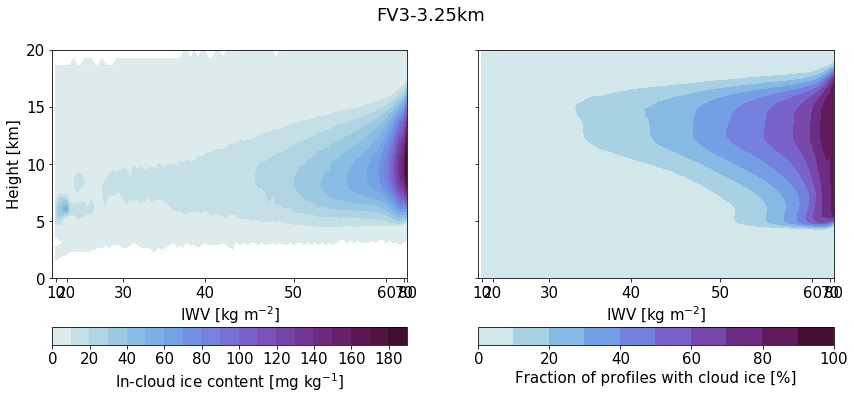

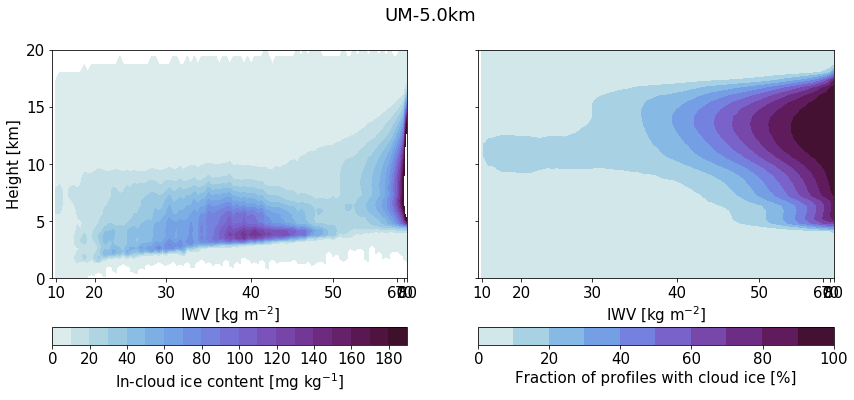

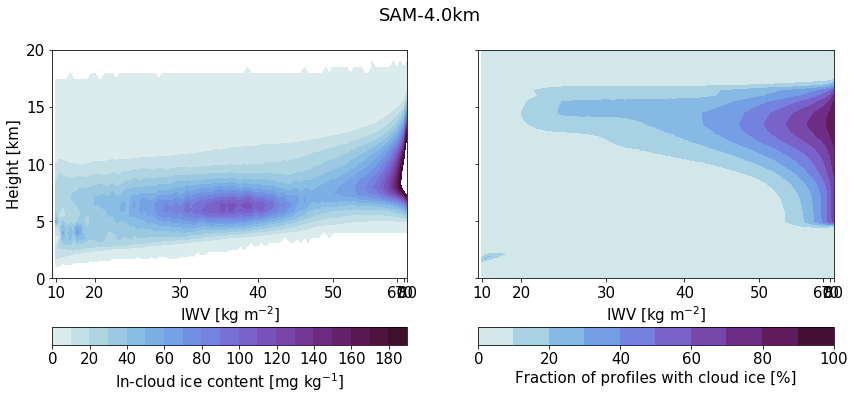

In [49]:
plt.rcParams.update({'font.size': 15})
for m in exps:
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
  
    x_lims = [0, 100]
    y_lims = [0, 20]
    x_label = 'IWV [kg m$^{-2}$]'
    y_label = 'Height [km]'
    contours_content = np.arange(0, 200, 10)
    contours_frac = np.arange(0, 110, 10)
    plots.moisture_space_contourf(fig, ax[0], perc_values, height[m] * 1e-3, perc_mean[m]['ICQI'].T * 1e6,\
                                  contours_content, x_lims, y_lims, x_label, y_label,\
                                  'In-cloud ice content [mg kg$^{-1}$]', cmap='density', vmin=0, vmax=190)
    plots.moisture_space_contourf(fig, ax[1], perc_values, height[m] * 1e-3, perc_mean[m]['CFI'].T * 1e2,\
                                  contours_frac, x_lims, y_lims, x_label, '',\
                                  'Fraction of profiles with cloud ice [%]', cmap='density', vmin=0, vmax=100)
   
    tick_labels = np.arange(10, 81, 10)
    tick_idx = []
    for t in tick_labels:
        tick_idx.append(np.argmin(np.abs(percentiles[m] - t)))
    ax[0].set_xticks(tick_idx)
    ax[0].set_xticklabels(tick_labels)
    ax[1].set_xticks(tick_idx)
    ax[1].set_xticklabels(tick_labels)
    ax[0].set_ylim(0, 20)
    fig.suptitle(m)
    

### IWV bins

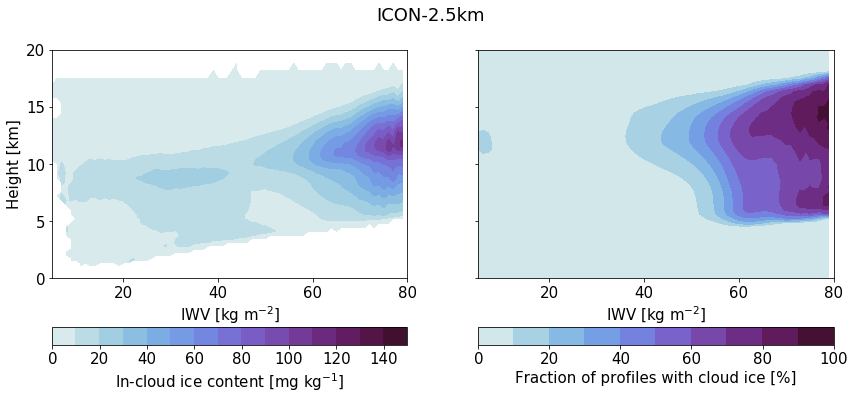

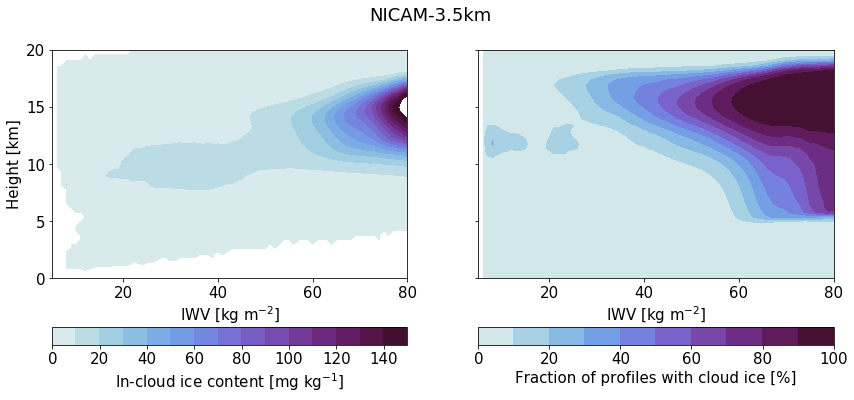

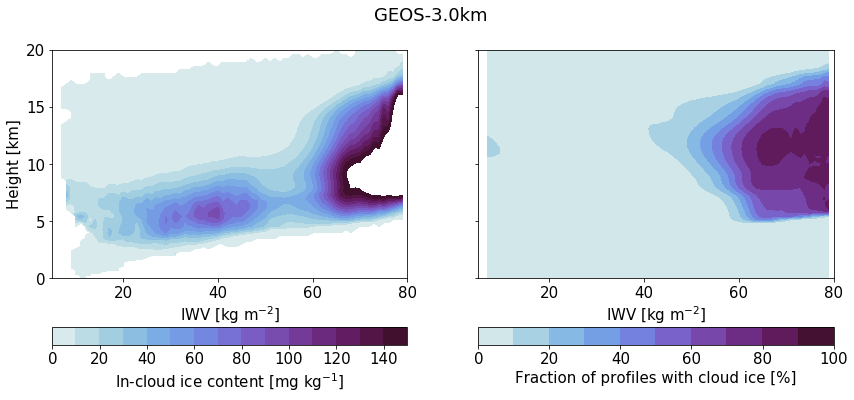

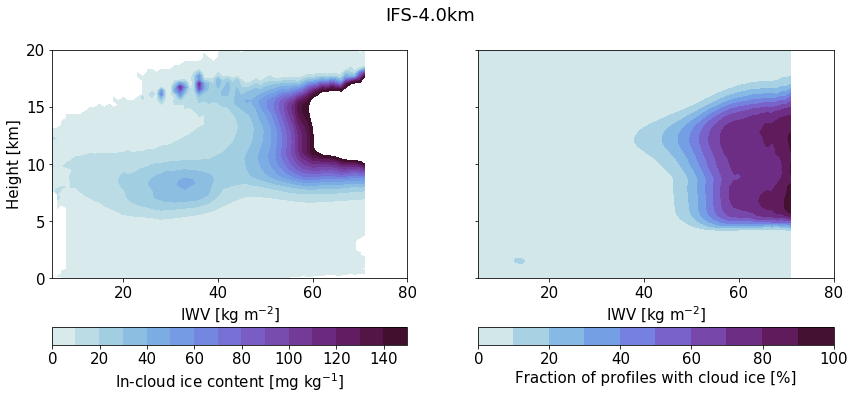

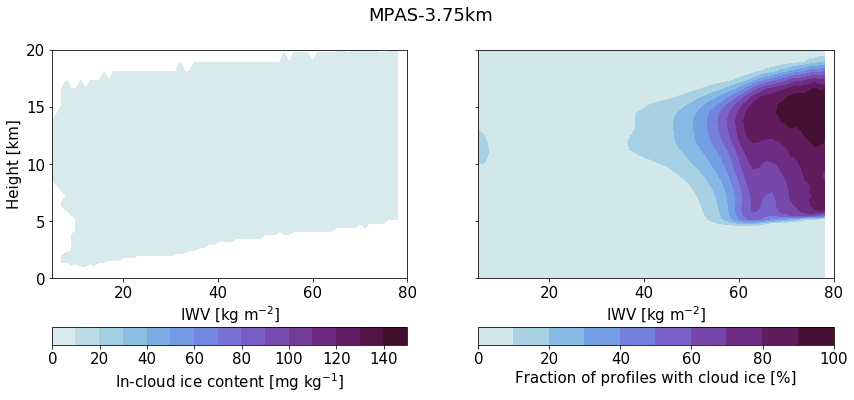

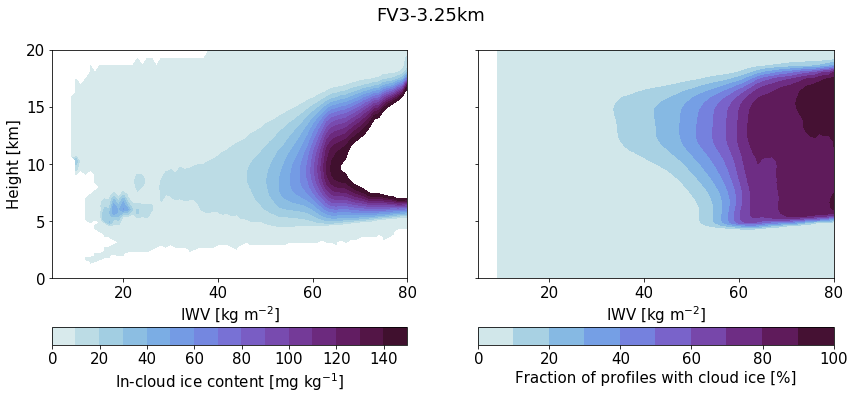

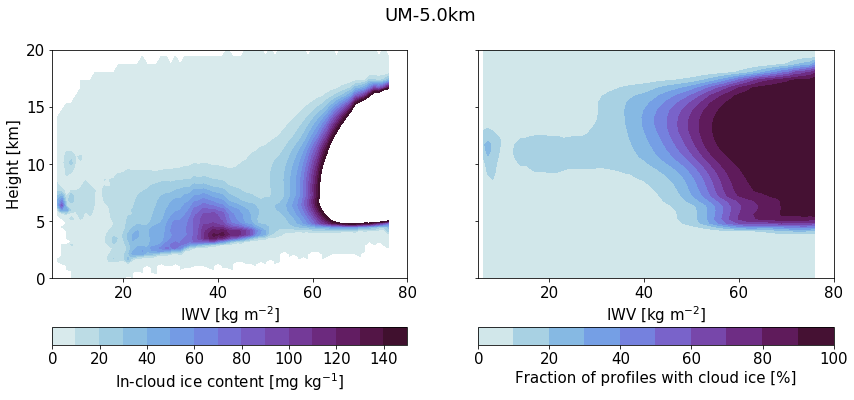

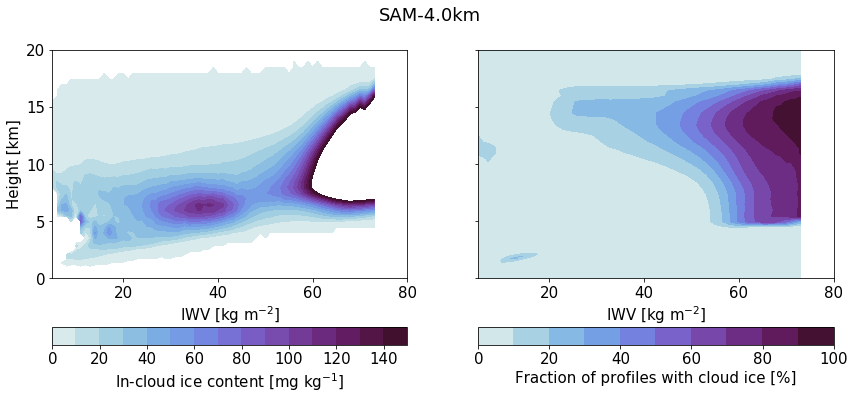

In [50]:
for m in exps:
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    x_lims = [5, 80]
    y_lims = [0, 20]
    x_label = 'IWV [kg m$^{-2}$]'
    y_label = 'Height [km]'
    contours_content = np.arange(0, 160, 10)
    contours_frac = np.arange(0, 110, 10)
    plots.moisture_space_contourf(fig, ax[0], bins, height[m] * 1e-3, bin_mean_plot[m]['ICQI'] * 1e6,\
                                  contours_content, x_lims, y_lims, x_label, y_label,\
                                  'In-cloud ice content [mg kg$^{-1}$]', cmap='density', vmin=0, vmax=150)
    plots.moisture_space_contourf(fig, ax[1], bins, height[m] * 1e-3, bin_mean_plot[m]['CFI'] * 1e2,\
                                  contours_frac, x_lims, y_lims, x_label, '',\
                                  'Fraction of profiles with cloud ice [%]', cmap='density', vmin=0, vmax=100)
    fig.suptitle(m)

## In cloud water content and cloud fraction

### Percentiles

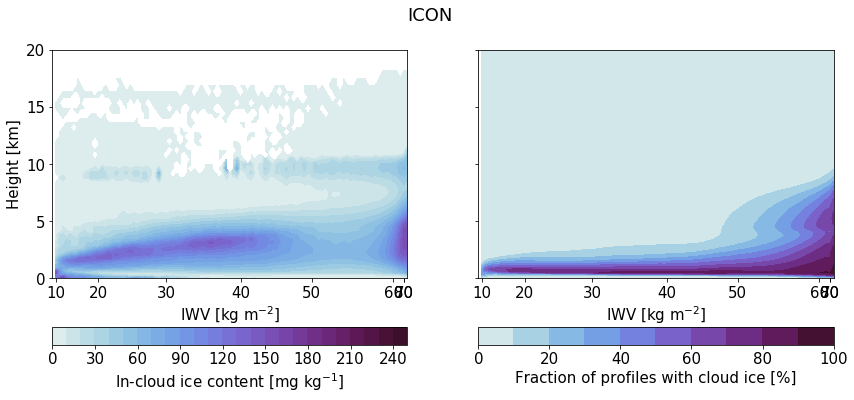

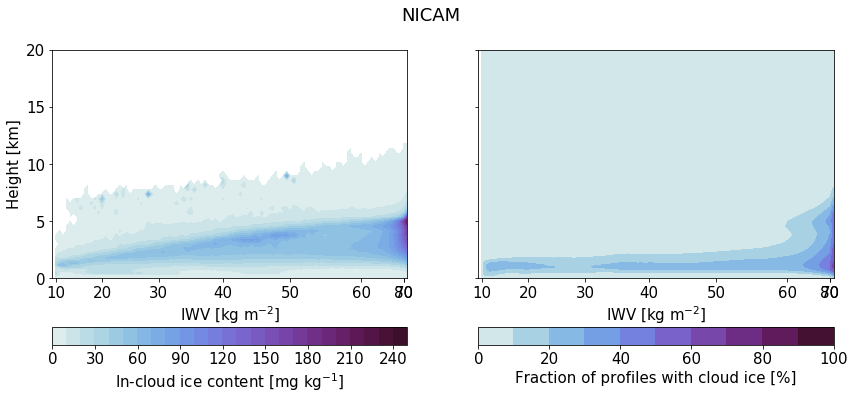

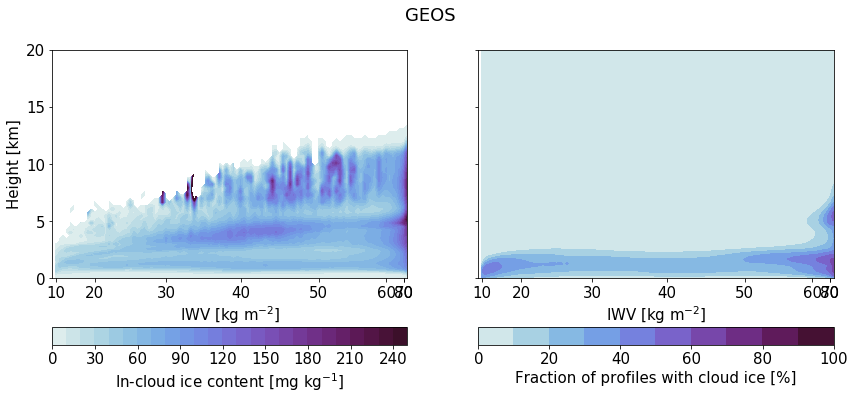

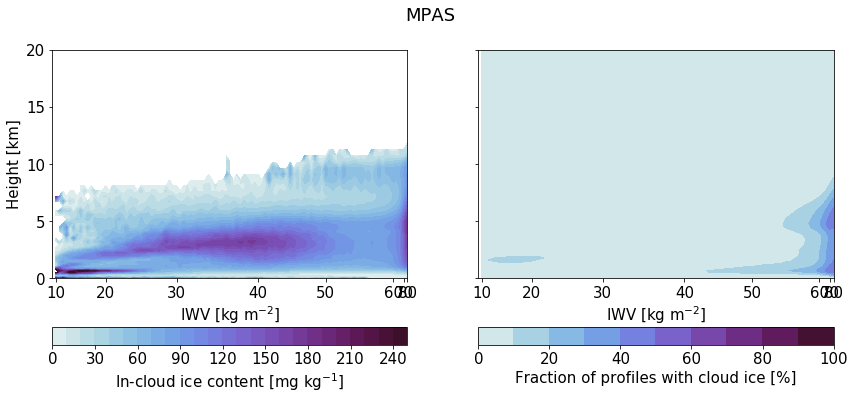

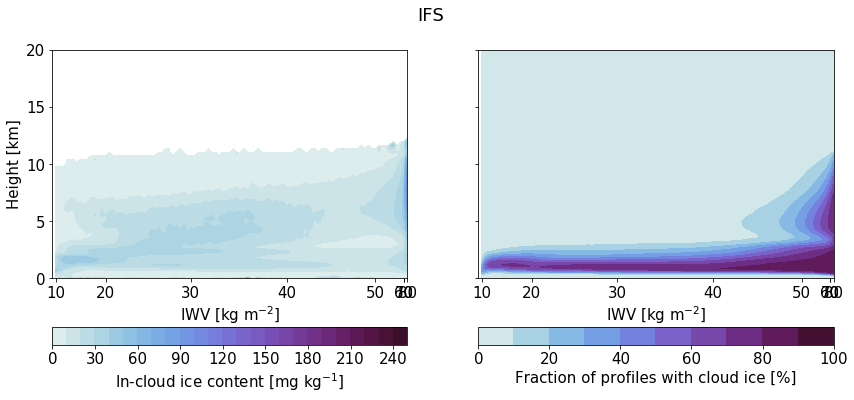

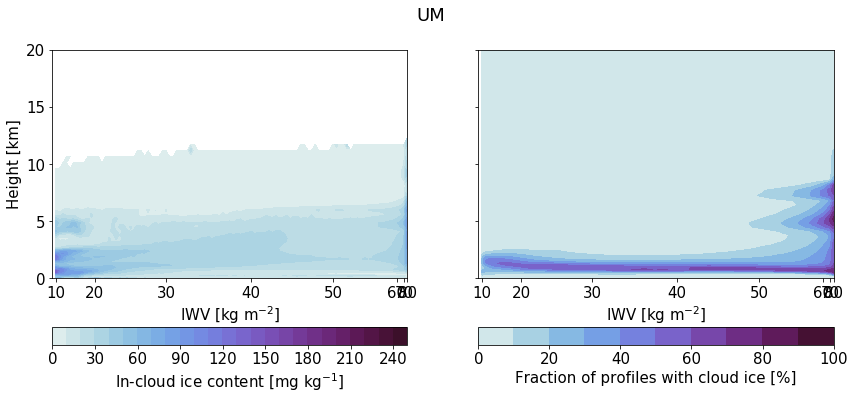

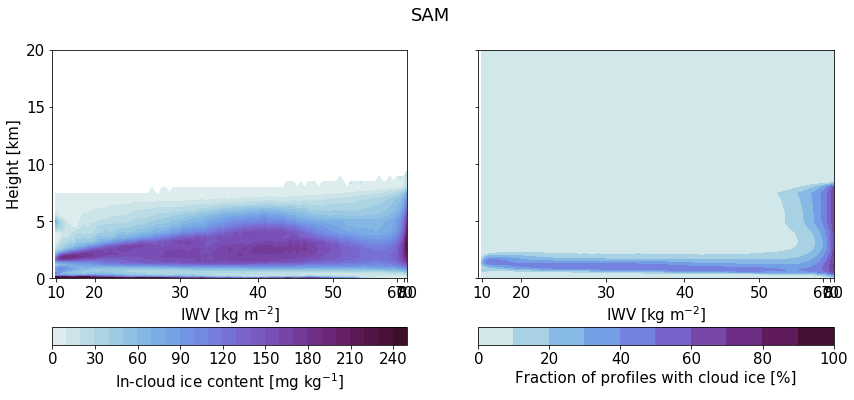

In [28]:
for m in models:
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
  
    x_lims = [0, 100]
    y_lims = [0, 20]
    x_label = 'IWV [kg m$^{-2}$]'
    y_label = 'Height [km]'
    contours_content = np.arange(0, 260, 10)
    contours_frac = np.arange(0, 110, 10)
    plots.moisture_space_contourf(fig, ax[0], perc_values, height[m] * 1e-3, perc_mean[m]['ICQC'].T * 1e6,\
                                  contours_content, x_lims, y_lims, x_label, y_label,\
                                  'In-cloud ice content [mg kg$^{-1}$]', cmap='density', vmin=0, vmax=250)
    plots.moisture_space_contourf(fig, ax[1], perc_values, height[m] * 1e-3, perc_mean[m]['CFL'].T * 1e2,\
                                  contours_frac, x_lims, y_lims, x_label, '',\
                                  'Fraction of profiles with cloud ice [%]', cmap='density', vmin=0, vmax=100)
   
    tick_labels = np.arange(10, 81, 10)
    tick_idx = []
    for t in tick_labels:
        tick_idx.append(np.argmin(np.abs(percentiles[m] - t)))
    ax[0].set_xticks(tick_idx)
    ax[0].set_xticklabels(tick_labels)
    ax[1].set_xticks(tick_idx)
    ax[1].set_xticklabels(tick_labels)
    ax[0].set_ylim(0, 20)
    fig.suptitle(m)

### IWV bins

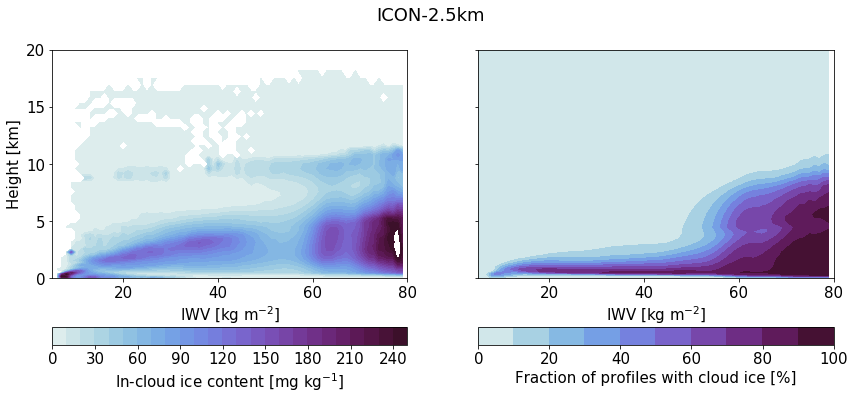

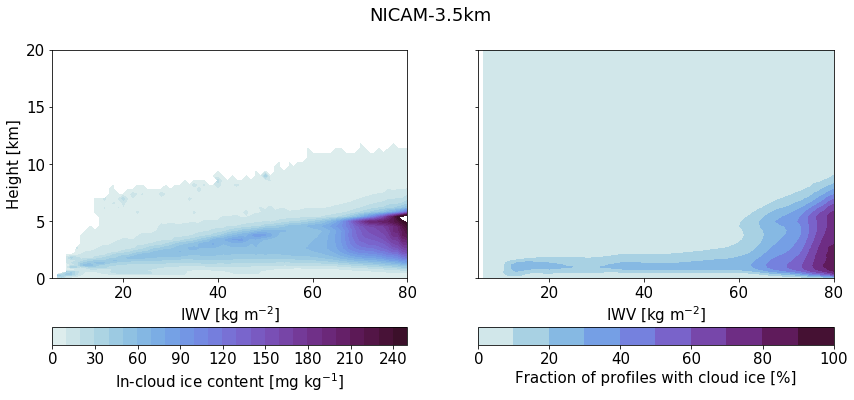

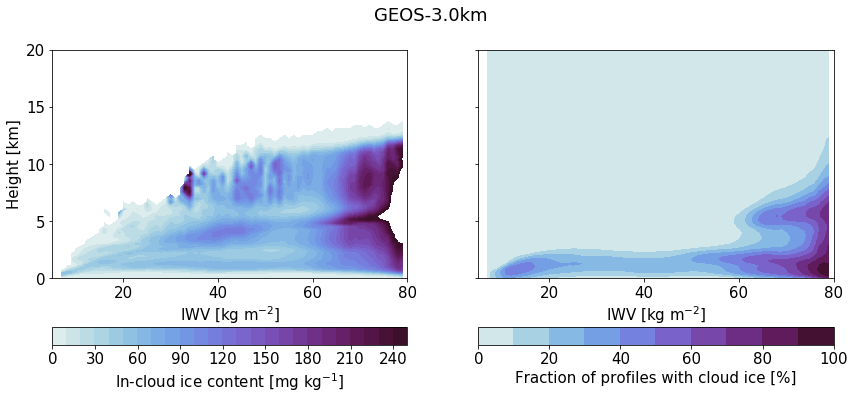

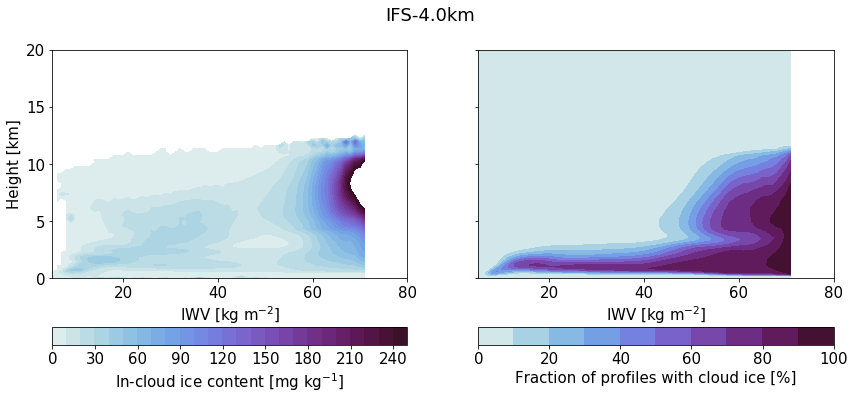

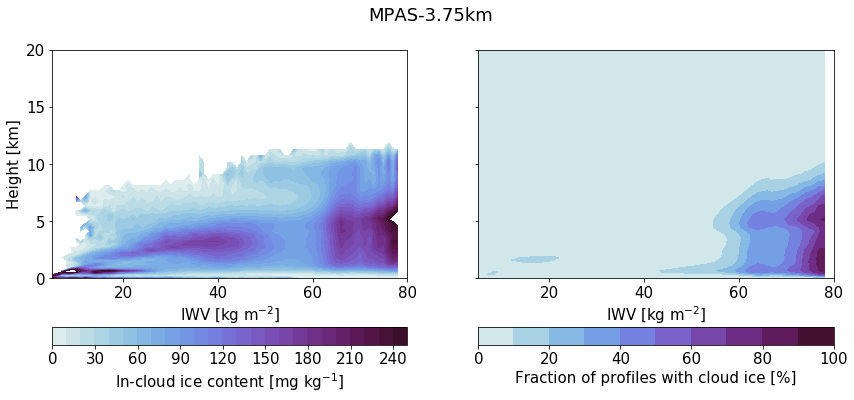

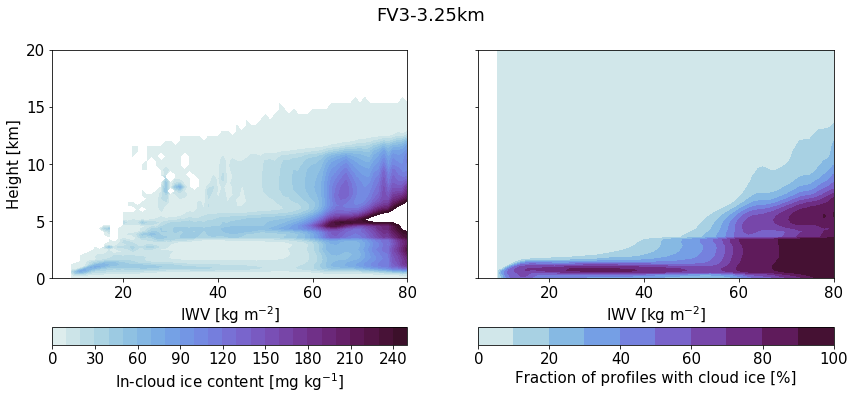

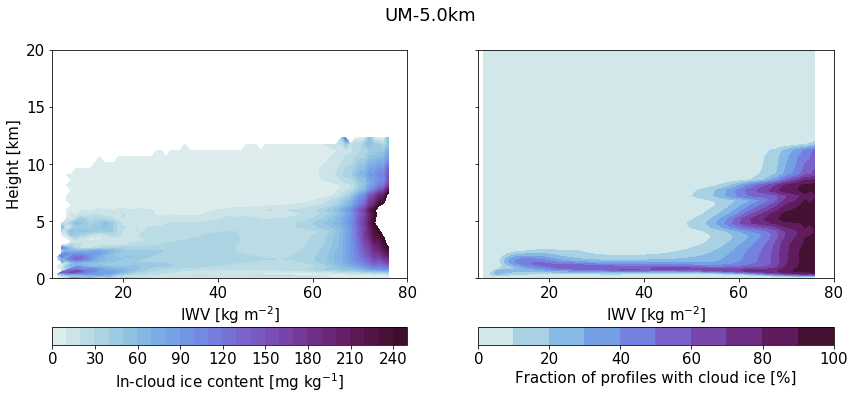

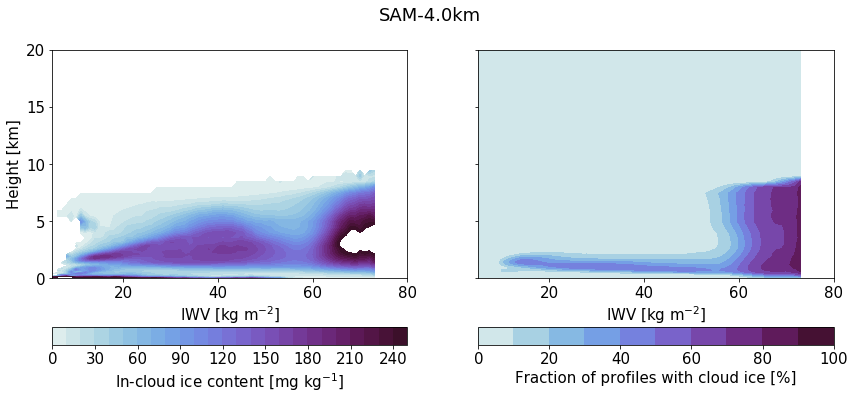

In [52]:
for m in exps:
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    x_lims = [5, 80]
    y_lims = [0, 20]
    x_label = 'IWV [kg m$^{-2}$]'
    y_label = 'Height [km]'
    contours_content = np.arange(0, 260, 10)
    contours_frac = np.arange(0, 110, 10)
    plots.moisture_space_contourf(fig, ax[0], bins, height[m] * 1e-3, bin_mean_plot[m]['ICQC'] * 1e6,\
                                  contours_content, x_lims, y_lims, x_label, y_label,\
                                  'In-cloud ice content [mg kg$^{-1}$]', cmap='density', vmin=0, vmax=250)
    plots.moisture_space_contourf(fig, ax[1], bins, height[m] * 1e-3, bin_mean_plot[m]['CFL'] * 1e2,\
                                  contours_frac, x_lims, y_lims, x_label, '',\
                                  'Fraction of profiles with cloud ice [%]', cmap='density', vmin=0, vmax=100)
    fig.suptitle(m)